In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import preprocessing
from numpy import mean
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Import data and preprocess

Create separate dataframes for each year of output since 2017. The final model can then learn off of 5 years of data before making its predictions for 2022. 
#### Let's get this shit

In [3]:
qb_df = pd.read_csv('qb_fantasy.csv')
qb_df

,Full Name,Position,Team,Draft Pick,Age,Breakout Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),...,Games (2020),Games (2021),Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020),Rushing Touchdowns (2021)
0,A.J. McCarron,QB,-,5.24,31.7,21,-,8.2,-,1.3,...,2,-,-,0,-,0,0,1,0,-
1,Aaron Rodgers,QB,Green Bay Packers,1.24,38.5,19.8,22.3,18.8,23.9,19.4,...,16,16,2,1,4,0,2,1,3,3
2,Alex Smith,QB,-,1.01,38.1,19.3,15.1,17.1,15.2,20,...,8,-,1,2,5,1,1,-,0,-
3,Alex Tanney,QB,-,Undrafted,34.6,-,-,8,-,-,...,-,-,-,0,-,-,-,0,-,-
4,Andrew Luck,QB,-,1.01,32.7,20,23,20.1,21.1,-,...,-,-,3,0,2,-,0,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,Tyler Huntley,QB,Baltimore Ravens,Undrafted,24.3,21.6,-,-,-,-,...,2,7,-,-,-,-,-,-,0,2
171,Tyrod Taylor,QB,New York Giants,6.15,32.8,20.1,-0.3,19.6,18.2,15.1,...,2,6,0,4,6,4,1,0,0,3
172,Will Grier,QB,Dallas Cowboys,3.36,27.2,22.4,-,-,-,-,...,-,-,-,-,-,-,-,0,-,-
173,Zach Mettenberger,QB,-,6.02,30.9,22.1,11.1,7,-,-,...,-,-,0,1,-,-,-,-,-,-


In [4]:
qb_df_w_team = qb_df.copy()

In [5]:
qb_clean = qb_df.replace({'-':np.nan,'15 gms':15,'9 gms':9,'1 gms':1,'7 gms':7,'2 gms':2,'3 gms':3,'13 gms':13,
                         '5 gms':5,'4.7 vol':4.7,'6.8 vol':6.8,'0.0 vol':0.0,'10.4 vol':10.4,'1.0 vol':1.0,
                          '12.4 vol':12.4,'1.6 vol':1.6,'8.9 vol':8.9,'3.7 vol':3.7,'5.8 vol':5.8,
                         '1.1 vol':1.1,'6.6 vol':6.6,'Undrafted':np.nan
                         }).set_index('Full Name').drop(columns=['Position'])
qb_final_df = qb_clean.drop(columns=['Team']).apply(lambda x: pd.to_numeric(x))
qb_final_df

,Draft Pick,Age,Breakout Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),...,Games (2020),Games (2021),Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020),Rushing Touchdowns (2021)
Full Name,,,,,,,,,,,,,,,,,,,,,
A.J. McCarron,5.24,31.7,21.0,NaN,8.2,NaN,1.3,0.1,8.9,0.4000,...,2.0,NaN,NaN,0.0,NaN,0.0,0.0,1.0,0.0,NaN
Aaron Rodgers,1.24,38.5,19.8,22.3,18.8,23.9,19.4,19.3,17.3,24.2662,...,16.0,16.0,2.0,1.0,4.0,0.0,2.0,1.0,3.0,3.0
Alex Smith,1.01,38.1,19.3,15.1,17.1,15.2,20.0,14.3,NaN,9.9475,...,8.0,NaN,1.0,2.0,5.0,1.0,1.0,NaN,0.0,NaN
Alex Tanney,NaN,34.6,NaN,NaN,8.0,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
Andrew Luck,1.01,32.7,20.0,23.0,20.1,21.1,NaN,21.1,NaN,NaN,...,NaN,NaN,3.0,0.0,2.0,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tyler Huntley,NaN,24.3,21.6,NaN,NaN,NaN,NaN,NaN,NaN,1.4500,...,2.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0
Tyrod Taylor,6.15,32.8,20.1,-0.3,19.6,18.2,15.1,10.9,1.5,4.5100,...,2.0,6.0,0.0,4.0,6.0,4.0,1.0,0.0,0.0,3.0
Will Grier,3.36,27.2,22.4,NaN,NaN,NaN,NaN,NaN,2.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [6]:
qb_final_df['fpts_2014'] = qb_final_df['Fantasy Points Per Game (2014)'] * qb_final_df['Games (2014)']
qb_final_df['fpts_2015'] = qb_final_df['Fantasy Points Per Game (2015)'] * qb_final_df['Games (2015)']
qb_final_df['fpts_2016'] = qb_final_df['Fantasy Points Per Game (2016)'] * qb_final_df['Games (2016)']
qb_final_df['fpts_2017'] = qb_final_df['Fantasy Points Per Game (2017)'] * qb_final_df['Games (2017)']
qb_final_df['fpts_2018'] = qb_final_df['Fantasy Points Per Game (2018)'] * qb_final_df['Games (2018)']
qb_final_df['fpts_2019'] = qb_final_df['Fantasy Points Per Game (2019)'] * qb_final_df['Games (2019)']
qb_final_df['fpts_2020'] = qb_final_df['Fantasy Points Per Game (2020)'] * qb_final_df['Games (2020)']
qb_final_df['fpts_2021'] = qb_final_df['Fantasy Points Per Game (2021)'] * qb_final_df['Games (2021)']
qb_final_df = qb_final_df.reset_index()

In [7]:
qb_final_df.columns

Index(['Full Name', 'Draft Pick', 'Age', 'Breakout Age',
       'Fantasy Points Per Game (2014)', 'Fantasy Points Per Game (2015)',
       'Fantasy Points Per Game (2016)', 'Fantasy Points Per Game (2017)',
       'Fantasy Points Per Game (2018)', 'Fantasy Points Per Game (2019)',
       'Fantasy Points Per Game (2020)', 'Fantasy Points Per Game (2021)',
       'Games (2014)', 'Games (2015)', 'Games (2016)', 'Games (2017)',
       'Games (2018)', 'Games (2019)', 'Games (2020)', 'Games (2021)',
       'Rushing Touchdowns (2014)', 'Rushing Touchdowns (2015)',
       'Rushing Touchdowns (2016)', 'Rushing Touchdowns (2017)',
       'Rushing Touchdowns (2018)', 'Rushing Touchdowns (2019)',
       'Rushing Touchdowns (2020)', 'Rushing Touchdowns (2021)', 'fpts_2014',
       'fpts_2015', 'fpts_2016', 'fpts_2017', 'fpts_2018', 'fpts_2019',
       'fpts_2020', 'fpts_2021'],
      dtype='object')

In [8]:
qb_final_df['Team'] = qb_df_w_team['Team']
qb_final_df

,Full Name,Draft Pick,Age,Breakout Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),...,Rushing Touchdowns (2021),fpts_2014,fpts_2015,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,fpts_2021,Team
0,A.J. McCarron,5.24,31.7,21.0,NaN,8.2,NaN,1.3,0.1,8.9,...,NaN,NaN,57.4,NaN,2.6,0.2,17.8,0.8000,NaN,-
1,Aaron Rodgers,1.24,38.5,19.8,22.3,18.8,23.9,19.4,19.3,17.3,...,3.0,356.8,300.8,382.4,135.8,308.8,276.8,388.2592,337.3008,Green Bay Packers
2,Alex Smith,1.01,38.1,19.3,15.1,17.1,15.2,20.0,14.3,NaN,...,NaN,226.5,273.6,228.0,300.0,143.0,NaN,79.5800,NaN,-
3,Alex Tanney,NaN,34.6,NaN,NaN,8.0,NaN,NaN,NaN,0.0,...,NaN,NaN,8.0,NaN,NaN,NaN,0.0,NaN,NaN,-
4,Andrew Luck,1.01,32.7,20.0,23.0,20.1,21.1,NaN,21.1,NaN,...,NaN,368.0,140.7,316.5,NaN,337.6,NaN,NaN,NaN,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,Tyler Huntley,NaN,24.3,21.6,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.9000,86.6397,Baltimore Ravens
171,Tyrod Taylor,6.15,32.8,20.1,-0.3,19.6,18.2,15.1,10.9,1.5,...,3.0,-0.3,274.4,273.0,226.5,43.6,6.0,9.0200,86.7402,New York Giants
172,Will Grier,3.36,27.2,22.4,NaN,NaN,NaN,NaN,NaN,2.7,...,NaN,NaN,NaN,NaN,NaN,NaN,5.4,NaN,NaN,Dallas Cowboys
173,Zach Mettenberger,6.02,30.9,22.1,11.1,7.0,NaN,NaN,NaN,NaN,...,NaN,77.7,49.0,NaN,NaN,NaN,NaN,NaN,NaN,-


In [181]:
final_data = pd.DataFrame()
final_data_id = pd.DataFrame()

### 2017 predictions

In [182]:
qb_2017 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
    'Games (2014)', 'Games (2015)','Games (2016)', 
    'fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','Draft Pick','Breakout Age','Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)'
                      ]].dropna(subset=['Fantasy Points Per Game (2017)'])
qb_2017

,Full Name,Age,Team,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Games (2014),Games (2015),Games (2016),fpts_2014,fpts_2015,fpts_2016,fpts_2017,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016)
0,A.J. McCarron,31.7,-,NaN,8.2,NaN,1.3,NaN,7.0,NaN,NaN,57.4,NaN,2.6,5.24,21.0,NaN,0.0,NaN
1,Aaron Rodgers,38.5,Green Bay Packers,22.3,18.8,23.9,19.4,16.0,16.0,16.0,356.8,300.8,382.4,135.8,1.24,19.8,2.0,1.0,4.0
2,Alex Smith,38.1,-,15.1,17.1,15.2,20.0,15.0,16.0,15.0,226.5,273.6,228.0,300.0,1.01,19.3,1.0,2.0,5.0
5,Andy Dalton,34.6,New Orleans Saints,15.0,19.3,16.8,13.9,16.0,13.0,16.0,240.0,250.9,268.8,222.4,2.03,20.9,4.0,3.0,4.0
6,Austin Davis,33.0,-,13.0,7.4,NaN,-0.1,9.0,3.0,NaN,117.0,22.2,NaN,-0.1,NaN,21.3,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,Tom Brady,44.8,Tampa Bay Buccaneers,17.9,22.0,21.5,18.7,16.0,16.0,12.0,286.4,352.0,258.0,299.2,6.33,21.1,0.0,3.0,0.0
161,Tom Savage,32.1,-,0.7,NaN,5.9,7.1,2.0,NaN,3.0,1.4,NaN,17.7,56.8,4.35,23.4,0.0,NaN,0.0
166,Trevor Siemian,30.4,Chicago Bears,NaN,-0.1,14.0,12.7,NaN,1.0,14.0,NaN,-0.1,196.0,139.7,NaN,21.7,NaN,0.0,0.0
169,Tyler Bray,30.4,-,NaN,NaN,NaN,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,NaN,18.7,NaN,NaN,NaN


In [183]:
qb_2017_team = pd.read_csv('qb_2017_team.csv').drop(columns=['Unnamed: 0'])
qb_2017_team

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Games (2014),Games (2015),Games (2016),fpts_2014,fpts_2015,fpts_2016,fpts_2017,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016)
0,A.J. McCarron,31.7,Cincinnati Bengals,0,NaN,8.2,NaN,1.3,NaN,7.0,NaN,NaN,57.4,NaN,2.6,5.24,21.0,NaN,0.0,NaN
1,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,16.0,16.0,16.0,356.8,300.8,382.4,135.8,1.24,19.8,2.0,1.0,4.0
2,Alex Smith,38.1,Kansas City Chiefs,1,15.1,17.1,15.2,20.0,15.0,16.0,15.0,226.5,273.6,228.0,300.0,1.01,19.3,1.0,2.0,5.0
3,Andy Dalton,34.6,Cincinnati Bengals,1,15.0,19.3,16.8,13.9,16.0,13.0,16.0,240.0,250.9,268.8,222.4,2.03,20.9,4.0,3.0,4.0
4,Austin Davis,33.0,Seattle Seahawks,0,13.0,7.4,NaN,-0.1,9.0,3.0,NaN,117.0,22.2,NaN,-0.1,NaN,21.3,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Tom Brady,44.8,New England Patriots,1,17.9,22.0,21.5,18.7,16.0,16.0,12.0,286.4,352.0,258.0,299.2,6.33,21.1,0.0,3.0,0.0
69,Tom Savage,32.1,Houston Texans,0,0.7,NaN,5.9,7.1,2.0,NaN,3.0,1.4,NaN,17.7,56.8,4.35,23.4,0.0,NaN,0.0
70,Trevor Siemian,30.4,Denver Broncos,1,NaN,-0.1,14.0,12.7,NaN,1.0,14.0,NaN,-0.1,196.0,139.7,NaN,21.7,NaN,0.0,0.0
71,Tyler Bray,30.4,Kansas City Chiefs,0,NaN,NaN,NaN,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,NaN,18.7,NaN,NaN,NaN


In [184]:
qb_2017_final = qb_2017_team.copy()
qb_2017_final

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Games (2014),Games (2015),Games (2016),fpts_2014,fpts_2015,fpts_2016,fpts_2017,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016)
0,A.J. McCarron,31.7,Cincinnati Bengals,0,NaN,8.2,NaN,1.3,NaN,7.0,NaN,NaN,57.4,NaN,2.6,5.24,21.0,NaN,0.0,NaN
1,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,16.0,16.0,16.0,356.8,300.8,382.4,135.8,1.24,19.8,2.0,1.0,4.0
2,Alex Smith,38.1,Kansas City Chiefs,1,15.1,17.1,15.2,20.0,15.0,16.0,15.0,226.5,273.6,228.0,300.0,1.01,19.3,1.0,2.0,5.0
3,Andy Dalton,34.6,Cincinnati Bengals,1,15.0,19.3,16.8,13.9,16.0,13.0,16.0,240.0,250.9,268.8,222.4,2.03,20.9,4.0,3.0,4.0
4,Austin Davis,33.0,Seattle Seahawks,0,13.0,7.4,NaN,-0.1,9.0,3.0,NaN,117.0,22.2,NaN,-0.1,NaN,21.3,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Tom Brady,44.8,New England Patriots,1,17.9,22.0,21.5,18.7,16.0,16.0,12.0,286.4,352.0,258.0,299.2,6.33,21.1,0.0,3.0,0.0
69,Tom Savage,32.1,Houston Texans,0,0.7,NaN,5.9,7.1,2.0,NaN,3.0,1.4,NaN,17.7,56.8,4.35,23.4,0.0,NaN,0.0
70,Trevor Siemian,30.4,Denver Broncos,1,NaN,-0.1,14.0,12.7,NaN,1.0,14.0,NaN,-0.1,196.0,139.7,NaN,21.7,NaN,0.0,0.0
71,Tyler Bray,30.4,Kansas City Chiefs,0,NaN,NaN,NaN,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,NaN,18.7,NaN,NaN,NaN


In [185]:
j_2017 = pd.read_csv('j_scores_2017_hermes.csv')
j_2017

,Unnamed: 0,Full Name,0,1,fpts_2017
0,0,Le'Veon Bell,0.101645,0.898355,342.0
1,1,Ezekiel Elliott,0.114394,0.885606,203.0
2,2,Antonio Brown,0.125034,0.874966,308.0
3,3,David Johnson,0.139751,0.860249,13.0
4,4,LeSean McCoy,0.182422,0.817578,264.0
...,...,...,...,...,...
468,468,Jeff Heuerman,0.998154,0.001846,35.0
469,469,Orson Charles,0.998154,0.001846,7.2
470,470,Jalston Fowler,0.998154,0.001846,6.3
471,471,Jeff Cumberland,0.998176,0.001824,2.4


In [186]:
team_2017 = pd.read_csv('hermes_j_2017.csv')
team_2017

,Unnamed: 0,Full Name,0,1,Position,Team
0,0,Mike Evans,0.189278,0.810722,WR,Tampa Bay Buccaneers
1,1,Devonta Freeman,0.234855,0.765145,RB,Atlanta Falcons
2,2,Ezekiel Elliott,0.245903,0.754097,RB,Dallas Cowboys
3,3,Julio Jones,0.280293,0.719707,WR,Atlanta Falcons
4,4,Odell Beckham,0.283363,0.716637,WR,New York Giants
...,...,...,...,...,...,...
470,470,Rex Burkhead,0.993949,0.006051,RB,-
471,471,Fitzgerald Toussaint,0.993949,0.006051,RB,-
472,472,Fozzy Whittaker,0.993949,0.006051,RB,-
473,473,J.D. McKissic,0.993949,0.006051,RB,-


In [187]:
j_2017_df = j_2017.merge(team_2017[['Full Name','Team']],on='Full Name',how='left')
j_2017_df

,Unnamed: 0,Full Name,0,1,fpts_2017,Team
0,0,Le'Veon Bell,0.101645,0.898355,342.0,Pittsburgh Steelers
1,1,Ezekiel Elliott,0.114394,0.885606,203.0,Dallas Cowboys
2,2,Antonio Brown,0.125034,0.874966,308.0,Pittsburgh Steelers
3,3,David Johnson,0.139751,0.860249,13.0,Arizona Cardinals
4,4,LeSean McCoy,0.182422,0.817578,264.0,Buffalo Bills
...,...,...,...,...,...,...
482,468,Jeff Heuerman,0.998154,0.001846,35.0,-
483,469,Orson Charles,0.998154,0.001846,7.2,-
484,470,Jalston Fowler,0.998154,0.001846,6.3,-
485,471,Jeff Cumberland,0.998176,0.001824,2.4,-


In [188]:
j_2017_group = j_2017_df.groupby(['Team']).agg({'1':'sum'}).drop('-')
j_2017_group

,1
Team,
Arizona Cardinals,1.028204
Atlanta Falcons,1.238300
Baltimore Ravens,0.335370
Buffalo Bills,1.044655
Carolina Panthers,0.571957
Chicago Bears,0.382557
Cincinnati Bengals,1.208344
Cleveland Browns,0.342539
Dallas Cowboys,1.272160


In [189]:
qb_team_2017 = qb_2017_final.merge(j_2017_group, on='Team', how='left').rename(columns={'1':'supporting_cast'})
qb_team_2017

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Games (2014),Games (2015),...,fpts_2014,fpts_2015,fpts_2016,fpts_2017,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),supporting_cast
0,A.J. McCarron,31.7,Cincinnati Bengals,0,NaN,8.2,NaN,1.3,NaN,7.0,...,NaN,57.4,NaN,2.6,5.24,21.0,NaN,0.0,NaN,1.208344
1,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,16.0,16.0,...,356.8,300.8,382.4,135.8,1.24,19.8,2.0,1.0,4.0,1.003515
2,Alex Smith,38.1,Kansas City Chiefs,1,15.1,17.1,15.2,20.0,15.0,16.0,...,226.5,273.6,228.0,300.0,1.01,19.3,1.0,2.0,5.0,1.144170
3,Andy Dalton,34.6,Cincinnati Bengals,1,15.0,19.3,16.8,13.9,16.0,13.0,...,240.0,250.9,268.8,222.4,2.03,20.9,4.0,3.0,4.0,1.208344
4,Austin Davis,33.0,Seattle Seahawks,0,13.0,7.4,NaN,-0.1,9.0,3.0,...,117.0,22.2,NaN,-0.1,NaN,21.3,0.0,0.0,NaN,0.277540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Tom Brady,44.8,New England Patriots,1,17.9,22.0,21.5,18.7,16.0,16.0,...,286.4,352.0,258.0,299.2,6.33,21.1,0.0,3.0,0.0,1.052971
69,Tom Savage,32.1,Houston Texans,0,0.7,NaN,5.9,7.1,2.0,NaN,...,1.4,NaN,17.7,56.8,4.35,23.4,0.0,NaN,0.0,0.728726
70,Trevor Siemian,30.4,Denver Broncos,1,NaN,-0.1,14.0,12.7,NaN,1.0,...,NaN,-0.1,196.0,139.7,NaN,21.7,NaN,0.0,0.0,0.803322
71,Tyler Bray,30.4,Kansas City Chiefs,0,NaN,NaN,NaN,-2.0,NaN,NaN,...,NaN,NaN,NaN,-2.0,NaN,18.7,NaN,NaN,NaN,1.144170


In [190]:
qb_2017_final['y'] = np.where(qb_2017_final['fpts_2017'] > 300,1,0)
qb_2017_final['y'].value_counts()

0    71
1     2
Name: y, dtype: int64

In [191]:
fpts_df_2017 = qb_2017_final[['fpts_2014','fpts_2015', 'fpts_2016']]

In [192]:
konami_df_2017 = qb_2017_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)']]

In [193]:
fppg_df_2017 = qb_2017_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)']]

In [194]:
games_df_2017 = qb_2017_final[['Games (2014)','Games (2015)','Games (2016)']]

In [195]:
konami_df_2017_final = pd.DataFrame()
konami_df_2017_final['2014'] = konami_df_2017['Rushing Touchdowns (2014)'] / games_df_2017['Games (2014)']
konami_df_2017_final['2015'] = konami_df_2017['Rushing Touchdowns (2015)'] / games_df_2017['Games (2015)']
konami_df_2017_final['2016'] = konami_df_2017['Rushing Touchdowns (2016)'] / games_df_2017['Games (2016)']
konami_df_2017_final

,2014,2015,2016
0,NaN,0.000000,NaN
1,0.125000,0.062500,0.250000
2,0.066667,0.125000,0.333333
3,0.250000,0.230769,0.250000
4,0.000000,0.000000,NaN
...,...,...,...
68,0.000000,0.187500,0.000000
69,0.000000,NaN,0.000000
70,NaN,0.000000,0.000000
71,NaN,NaN,NaN


In [196]:
df_2017 = qb_2017_final[['y','starter']]
df_2017

,y,starter
0,0,0
1,0,1
2,0,1
3,0,1
4,0,0
...,...,...
68,0,1
69,0,0
70,0,1
71,0,0


In [197]:
df_2017['age'] = qb_2017_final['Age'] - 5
df_2017

,y,starter,age
0,0,0,26.7
1,0,1,33.5
2,0,1,33.1
3,0,1,29.6
4,0,0,28.0
...,...,...,...
68,0,1,39.8
69,0,0,27.1
70,0,1,25.4
71,0,0,25.4


In [198]:
df_2017['max_pts'] = fpts_df_2017.max(axis=1)
df_2017

,y,starter,age,max_pts
0,0,0,26.7,57.4
1,0,1,33.5,382.4
2,0,1,33.1,273.6
3,0,1,29.6,268.8
4,0,0,28.0,117.0
...,...,...,...,...
68,0,1,39.8,352.0
69,0,0,27.1,17.7
70,0,1,25.4,196.0
71,0,0,25.4,NaN


In [199]:
df_2017['last_pts'] = fpts_df_2017['fpts_2016']
df_2017

,y,starter,age,max_pts,last_pts
0,0,0,26.7,57.4,NaN
1,0,1,33.5,382.4,382.4
2,0,1,33.1,273.6,228.0
3,0,1,29.6,268.8,268.8
4,0,0,28.0,117.0,NaN
...,...,...,...,...,...
68,0,1,39.8,352.0,258.0
69,0,0,27.1,17.7,17.7
70,0,1,25.4,196.0,196.0
71,0,0,25.4,NaN,NaN


In [200]:
df_2017['3_yr_trail_avg_fppg'] = fppg_df_2017.mean(axis=1)
df_2017

,y,starter,age,max_pts,last_pts,3_yr_trail_avg_fppg
0,0,0,26.7,57.4,NaN,8.200000
1,0,1,33.5,382.4,382.4,21.666667
2,0,1,33.1,273.6,228.0,15.800000
3,0,1,29.6,268.8,268.8,17.033333
4,0,0,28.0,117.0,NaN,10.200000
...,...,...,...,...,...,...
68,0,1,39.8,352.0,258.0,20.466667
69,0,0,27.1,17.7,17.7,3.300000
70,0,1,25.4,196.0,196.0,6.950000
71,0,0,25.4,NaN,NaN,NaN


In [201]:
df_2017['hit_rate'] = fpts_df_2017[fpts_df_2017 > 300].count(axis = 1) / fpts_df_2017.count(axis=1)
df_2017

,y,starter,age,max_pts,last_pts,3_yr_trail_avg_fppg,hit_rate
0,0,0,26.7,57.4,NaN,8.200000,0.000000
1,0,1,33.5,382.4,382.4,21.666667,1.000000
2,0,1,33.1,273.6,228.0,15.800000,0.000000
3,0,1,29.6,268.8,268.8,17.033333,0.000000
4,0,0,28.0,117.0,NaN,10.200000,0.000000
...,...,...,...,...,...,...,...
68,0,1,39.8,352.0,258.0,20.466667,0.333333
69,0,0,27.1,17.7,17.7,3.300000,0.000000
70,0,1,25.4,196.0,196.0,6.950000,0.000000
71,0,0,25.4,NaN,NaN,NaN,NaN


In [202]:
df_2017['Draft Pick'] = qb_2017_final['Draft Pick']
df_2017

,y,starter,age,max_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick
0,0,0,26.7,57.4,NaN,8.200000,0.000000,5.24
1,0,1,33.5,382.4,382.4,21.666667,1.000000,1.24
2,0,1,33.1,273.6,228.0,15.800000,0.000000,1.01
3,0,1,29.6,268.8,268.8,17.033333,0.000000,2.03
4,0,0,28.0,117.0,NaN,10.200000,0.000000,NaN
...,...,...,...,...,...,...,...,...
68,0,1,39.8,352.0,258.0,20.466667,0.333333,6.33
69,0,0,27.1,17.7,17.7,3.300000,0.000000,4.35
70,0,1,25.4,196.0,196.0,6.950000,0.000000,NaN
71,0,0,25.4,NaN,NaN,NaN,NaN,NaN


In [203]:
df_2017['breakout_age'] = qb_2017_final['Breakout Age']
df_2017

,y,starter,age,max_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,breakout_age
0,0,0,26.7,57.4,NaN,8.200000,0.000000,5.24,21.0
1,0,1,33.5,382.4,382.4,21.666667,1.000000,1.24,19.8
2,0,1,33.1,273.6,228.0,15.800000,0.000000,1.01,19.3
3,0,1,29.6,268.8,268.8,17.033333,0.000000,2.03,20.9
4,0,0,28.0,117.0,NaN,10.200000,0.000000,NaN,21.3
...,...,...,...,...,...,...,...,...,...
68,0,1,39.8,352.0,258.0,20.466667,0.333333,6.33,21.1
69,0,0,27.1,17.7,17.7,3.300000,0.000000,4.35,23.4
70,0,1,25.4,196.0,196.0,6.950000,0.000000,NaN,21.7
71,0,0,25.4,NaN,NaN,NaN,NaN,NaN,18.7


In [204]:
df_2017['konami'] = konami_df_2017_final.mean(axis=1)
df_2017

,y,starter,age,max_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,breakout_age,konami
0,0,0,26.7,57.4,NaN,8.200000,0.000000,5.24,21.0,0.000000
1,0,1,33.5,382.4,382.4,21.666667,1.000000,1.24,19.8,0.145833
2,0,1,33.1,273.6,228.0,15.800000,0.000000,1.01,19.3,0.175000
3,0,1,29.6,268.8,268.8,17.033333,0.000000,2.03,20.9,0.243590
4,0,0,28.0,117.0,NaN,10.200000,0.000000,NaN,21.3,0.000000
...,...,...,...,...,...,...,...,...,...,...
68,0,1,39.8,352.0,258.0,20.466667,0.333333,6.33,21.1,0.062500
69,0,0,27.1,17.7,17.7,3.300000,0.000000,4.35,23.4,0.000000
70,0,1,25.4,196.0,196.0,6.950000,0.000000,NaN,21.7,0.000000
71,0,0,25.4,NaN,NaN,NaN,NaN,NaN,18.7,NaN


In [205]:
df_2017['supporting_cast'] = qb_team_2017['supporting_cast']

In [206]:
df_2017['games_played_rate'] = games_df_2017.sum(axis=1)/(games_df_2017.count(axis=1)*16)

In [207]:
df_2017_id = df_2017.copy()
df_2017_id['id'] = qb_2017_final['Full Name']
df_2017_id['year'] = 2017
df_2017_id

,y,starter,age,max_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,breakout_age,konami,supporting_cast,games_played_rate,id,year
0,0,0,26.7,57.4,NaN,8.200000,0.000000,5.24,21.0,0.000000,1.208344,0.437500,A.J. McCarron,2017
1,0,1,33.5,382.4,382.4,21.666667,1.000000,1.24,19.8,0.145833,1.003515,1.000000,Aaron Rodgers,2017
2,0,1,33.1,273.6,228.0,15.800000,0.000000,1.01,19.3,0.175000,1.144170,0.958333,Alex Smith,2017
3,0,1,29.6,268.8,268.8,17.033333,0.000000,2.03,20.9,0.243590,1.208344,0.937500,Andy Dalton,2017
4,0,0,28.0,117.0,NaN,10.200000,0.000000,NaN,21.3,0.000000,0.277540,0.375000,Austin Davis,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,1,39.8,352.0,258.0,20.466667,0.333333,6.33,21.1,0.062500,1.052971,0.916667,Tom Brady,2017
69,0,0,27.1,17.7,17.7,3.300000,0.000000,4.35,23.4,0.000000,0.728726,0.156250,Tom Savage,2017
70,0,1,25.4,196.0,196.0,6.950000,0.000000,NaN,21.7,0.000000,0.803322,0.468750,Trevor Siemian,2017
71,0,0,25.4,NaN,NaN,NaN,NaN,NaN,18.7,NaN,1.144170,NaN,Tyler Bray,2017


In [208]:
final_data = final_data.append(df_2017)
final_data

,y,starter,age,max_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,breakout_age,konami,supporting_cast,games_played_rate
0,0,0,26.7,57.4,NaN,8.200000,0.000000,5.24,21.0,0.000000,1.208344,0.437500
1,0,1,33.5,382.4,382.4,21.666667,1.000000,1.24,19.8,0.145833,1.003515,1.000000
2,0,1,33.1,273.6,228.0,15.800000,0.000000,1.01,19.3,0.175000,1.144170,0.958333
3,0,1,29.6,268.8,268.8,17.033333,0.000000,2.03,20.9,0.243590,1.208344,0.937500
4,0,0,28.0,117.0,NaN,10.200000,0.000000,NaN,21.3,0.000000,0.277540,0.375000
...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,1,39.8,352.0,258.0,20.466667,0.333333,6.33,21.1,0.062500,1.052971,0.916667
69,0,0,27.1,17.7,17.7,3.300000,0.000000,4.35,23.4,0.000000,0.728726,0.156250
70,0,1,25.4,196.0,196.0,6.950000,0.000000,NaN,21.7,0.000000,0.803322,0.468750
71,0,0,25.4,NaN,NaN,NaN,NaN,NaN,18.7,NaN,1.144170,NaN


In [209]:
final_data_id = final_data_id.append(df_2017_id)
final_data_id

,y,starter,age,max_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,breakout_age,konami,supporting_cast,games_played_rate,id,year
0,0,0,26.7,57.4,NaN,8.200000,0.000000,5.24,21.0,0.000000,1.208344,0.437500,A.J. McCarron,2017
1,0,1,33.5,382.4,382.4,21.666667,1.000000,1.24,19.8,0.145833,1.003515,1.000000,Aaron Rodgers,2017
2,0,1,33.1,273.6,228.0,15.800000,0.000000,1.01,19.3,0.175000,1.144170,0.958333,Alex Smith,2017
3,0,1,29.6,268.8,268.8,17.033333,0.000000,2.03,20.9,0.243590,1.208344,0.937500,Andy Dalton,2017
4,0,0,28.0,117.0,NaN,10.200000,0.000000,NaN,21.3,0.000000,0.277540,0.375000,Austin Davis,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,1,39.8,352.0,258.0,20.466667,0.333333,6.33,21.1,0.062500,1.052971,0.916667,Tom Brady,2017
69,0,0,27.1,17.7,17.7,3.300000,0.000000,4.35,23.4,0.000000,0.728726,0.156250,Tom Savage,2017
70,0,1,25.4,196.0,196.0,6.950000,0.000000,NaN,21.7,0.000000,0.803322,0.468750,Trevor Siemian,2017
71,0,0,25.4,NaN,NaN,NaN,NaN,NaN,18.7,NaN,1.144170,NaN,Tyler Bray,2017


### 2018

In [210]:
qb_2018 = qb_final_df[['Full Name','Age', 'Team','Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','Draft Pick',
                      'Breakout Age','Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)'
                      ]].dropna(subset=['Fantasy Points Per Game (2018)'])
qb_2018

,Full Name,Age,Team,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Games (2014),Games (2015),...,fpts_2015,fpts_2016,fpts_2017,fpts_2018,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017)
0,A.J. McCarron,31.7,-,NaN,8.2,NaN,1.3,0.1,NaN,7.0,...,57.4,NaN,2.6,0.2,5.24,21.0,NaN,0.0,NaN,0.0
1,Aaron Rodgers,38.5,Green Bay Packers,22.3,18.8,23.9,19.4,19.3,16.0,16.0,...,300.8,382.4,135.8,308.8,1.24,19.8,2.0,1.0,4.0,0.0
2,Alex Smith,38.1,-,15.1,17.1,15.2,20.0,14.3,15.0,16.0,...,273.6,228.0,300.0,143.0,1.01,19.3,1.0,2.0,5.0,1.0
4,Andrew Luck,32.7,-,23.0,20.1,21.1,NaN,21.1,16.0,7.0,...,140.7,316.5,NaN,337.6,1.01,20.0,3.0,0.0,2.0,NaN
5,Andy Dalton,34.6,New Orleans Saints,15.0,19.3,16.8,13.9,16.9,16.0,13.0,...,250.9,268.8,222.4,185.9,2.03,20.9,4.0,3.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,Sean Mannion,30.1,Minnesota Vikings,NaN,1.2,-0.3,1.0,0.0,NaN,1.0,...,1.2,-0.3,5.0,0.0,3.25,20.4,NaN,0.0,0.0,0.0
156,Taylor Heinicke,29.2,Washington Commanders,NaN,NaN,NaN,0.6,3.4,NaN,NaN,...,NaN,NaN,0.6,17.0,NaN,19.5,NaN,NaN,NaN,0.0
157,Teddy Bridgewater,29.6,Miami Dolphins,14.4,13.0,NaN,-1.3,2.1,13.0,16.0,...,208.0,NaN,-1.3,8.4,1.32,18.8,1.0,3.0,NaN,0.0
160,Tom Brady,44.8,Tampa Bay Buccaneers,17.9,22.0,21.5,18.7,18.2,16.0,16.0,...,352.0,258.0,299.2,291.2,6.33,21.1,0.0,3.0,0.0,0.0


In [211]:
qb_2018_team = pd.read_csv('qb_2018_team.csv').drop(columns=['Unnamed: 0'])

team_2018 = pd.read_csv('brady_input_2018.csv')

qb_2018_final = qb_2018_team.copy()
qb_2018_final

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Games (2014),...,fpts_2015,fpts_2016,fpts_2017,fpts_2018,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017)
0,A.J. McCarron,31.7,Buffalo Bills,0,NaN,8.2,NaN,1.3,0.1,NaN,...,57.4,NaN,2.6,0.2,5.24,21.0,NaN,0.0,NaN,0.0
1,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,16.0,...,300.8,382.4,135.8,308.8,1.24,19.8,2.0,1.0,4.0,0.0
2,Alex Smith,38.1,Washington Commanders,1,15.1,17.1,15.2,20.0,14.3,15.0,...,273.6,228.0,300.0,143.0,1.01,19.3,1.0,2.0,5.0,1.0
3,Andrew Luck,32.7,Indianapolis Colts,1,23.0,20.1,21.1,NaN,21.1,16.0,...,140.7,316.5,NaN,337.6,1.01,20.0,3.0,0.0,2.0,NaN
4,Andy Dalton,34.6,Cincinnati Bengals,1,15.0,19.3,16.8,13.9,16.9,16.0,...,250.9,268.8,222.4,185.9,2.03,20.9,4.0,3.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Sean Mannion,30.1,Los Angeles Rams,0,NaN,1.2,-0.3,1.0,0.0,NaN,...,1.2,-0.3,5.0,0.0,3.25,20.4,NaN,0.0,0.0,0.0
68,Taylor Heinicke,29.2,Carolina Panthers,0,NaN,NaN,NaN,0.6,3.4,NaN,...,NaN,NaN,0.6,17.0,NaN,19.5,NaN,NaN,NaN,0.0
69,Teddy Bridgewater,29.6,New Orleans Saints,0,14.4,13.0,NaN,-1.3,2.1,13.0,...,208.0,NaN,-1.3,8.4,1.32,18.8,1.0,3.0,NaN,0.0
70,Tom Brady,44.8,New England Patriots,1,17.9,22.0,21.5,18.7,18.2,16.0,...,352.0,258.0,299.2,291.2,6.33,21.1,0.0,3.0,0.0,0.0


In [212]:
j_2018 = pd.read_csv('j_scores_2018_hermes.csv')

team_2018 = pd.read_csv('hermes_j_2018.csv')

j_2018_df = j_2018.merge(team_2018[['Full Name','Team']],on='Full Name',how='left')

j_2018_group = j_2018_df.groupby(['Team']).agg({'1':'sum'}).drop('-')

qb_team_2018 = qb_2018_final.merge(j_2018_group, on='Team', how='left').rename(columns={'1':'supporting_cast'})
qb_team_2018

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Games (2014),...,fpts_2016,fpts_2017,fpts_2018,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),supporting_cast
0,A.J. McCarron,31.7,Buffalo Bills,0,NaN,8.2,NaN,1.3,0.1,NaN,...,NaN,2.6,0.2,5.24,21.0,NaN,0.0,NaN,0.0,0.438415
1,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,16.0,...,382.4,135.8,308.8,1.24,19.8,2.0,1.0,4.0,0.0,0.920371
2,Alex Smith,38.1,Washington Commanders,1,15.1,17.1,15.2,20.0,14.3,15.0,...,228.0,300.0,143.0,1.01,19.3,1.0,2.0,5.0,1.0,0.352026
3,Andrew Luck,32.7,Indianapolis Colts,1,23.0,20.1,21.1,NaN,21.1,16.0,...,316.5,NaN,337.6,1.01,20.0,3.0,0.0,2.0,NaN,0.164788
4,Andy Dalton,34.6,Cincinnati Bengals,1,15.0,19.3,16.8,13.9,16.9,16.0,...,268.8,222.4,185.9,2.03,20.9,4.0,3.0,4.0,0.0,1.265841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Sean Mannion,30.1,Los Angeles Rams,0,NaN,1.2,-0.3,1.0,0.0,NaN,...,-0.3,5.0,0.0,3.25,20.4,NaN,0.0,0.0,0.0,2.713352
68,Taylor Heinicke,29.2,Carolina Panthers,0,NaN,NaN,NaN,0.6,3.4,NaN,...,NaN,0.6,17.0,NaN,19.5,NaN,NaN,NaN,0.0,1.143515
69,Teddy Bridgewater,29.6,New Orleans Saints,0,14.4,13.0,NaN,-1.3,2.1,13.0,...,NaN,-1.3,8.4,1.32,18.8,1.0,3.0,NaN,0.0,2.463180
70,Tom Brady,44.8,New England Patriots,1,17.9,22.0,21.5,18.7,18.2,16.0,...,258.0,299.2,291.2,6.33,21.1,0.0,3.0,0.0,0.0,0.603063


In [213]:
qb_2018_final['y'] = np.where(qb_2018_final['fpts_2018'] > 300,1,0)
qb_2018_final['y'].value_counts()

0    63
1     9
Name: y, dtype: int64

In [214]:
fpts_df_2018 = qb_2018_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017']]

konami_df_2018 = qb_2018_final[[
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)']]

fppg_df_2018 = qb_2018_final[['Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)']]

games_df_2018 = qb_2018_final[['Games (2015)','Games (2016)','Games (2017)']]

konami_df_2018_final = pd.DataFrame()
konami_df_2018_final['2015'] = konami_df_2018['Rushing Touchdowns (2015)'] / games_df_2018['Games (2015)']
konami_df_2018_final['2016'] = konami_df_2018['Rushing Touchdowns (2016)'] / games_df_2018['Games (2016)']
konami_df_2018_final['2017'] = konami_df_2018['Rushing Touchdowns (2017)'] / games_df_2018['Games (2017)']

df_2018 = qb_2018_final[['y','starter']]

df_2018['age'] = qb_2018_final['Age'] - 4

df_2018['max_pts'] = fpts_df_2018.max(axis=1)

df_2018['last_pts'] = fpts_df_2018['fpts_2017']

df_2018['3_yr_trail_avg_fppg'] = fppg_df_2018[['Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)']].mean(axis=1)

df_2018['hit_rate'] = fpts_df_2018[fpts_df_2018 > 300].count(axis = 1) / fpts_df_2018.count(axis=1)

df_2018['Draft Pick'] = qb_2018_final['Draft Pick']

df_2018['breakout_age'] = qb_2018_final['Breakout Age']

df_2018['konami'] = konami_df_2018_final.mean(axis=1)

df_2018['supporting_cast'] = qb_team_2018['supporting_cast']

df_2018['games_played_rate'] = games_df_2018.sum(axis=1)/(games_df_2018.count(axis=1)*16)

df_2018_id = df_2018.copy()
df_2018_id['id'] = qb_2018_final['Full Name']
df_2018_id['year'] = 2018

final_data = final_data.append(df_2018)

final_data_id = final_data_id.append(df_2018_id)
final_data_id

,y,starter,age,max_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,breakout_age,konami,supporting_cast,games_played_rate,id,year
0,0,0,26.7,57.4,NaN,8.200000,0.00,5.24,21.0,0.000000,1.208344,0.437500,A.J. McCarron,2017
1,0,1,33.5,382.4,382.4,21.666667,1.00,1.24,19.8,0.145833,1.003515,1.000000,Aaron Rodgers,2017
2,0,1,33.1,273.6,228.0,15.800000,0.00,1.01,19.3,0.175000,1.144170,0.958333,Alex Smith,2017
3,0,1,29.6,268.8,268.8,17.033333,0.00,2.03,20.9,0.243590,1.208344,0.937500,Andy Dalton,2017
4,0,0,28.0,117.0,NaN,10.200000,0.00,NaN,21.3,0.000000,0.277540,0.375000,Austin Davis,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0,0,26.1,5.0,5.0,0.633333,0.00,3.25,20.4,0.000000,2.713352,0.145833,Sean Mannion,2018
68,0,0,25.2,0.6,0.6,0.600000,0.00,NaN,19.5,0.000000,1.143515,0.062500,Taylor Heinicke,2018
69,0,0,25.6,208.0,-1.3,5.850000,0.00,1.32,18.8,0.093750,2.463180,0.531250,Teddy Bridgewater,2018
70,0,1,40.8,352.0,299.2,20.733333,0.25,6.33,21.1,0.062500,0.603063,0.916667,Tom Brady,2018


### 2019

In [215]:
qb_2019 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','Draft Pick','Breakout Age',
                       'Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                       'Rushing Touchdowns (2018)'
                    ]].dropna(subset=['Fantasy Points Per Game (2019)'])
qb_2019

,Full Name,Age,Team,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Games (2014),...,fpts_2017,fpts_2018,fpts_2019,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018)
0,A.J. McCarron,31.7,-,NaN,8.2,NaN,1.3,0.1,8.9,NaN,...,2.6,0.2,17.8,5.24,21.0,NaN,0.0,NaN,0.0,0.0
1,Aaron Rodgers,38.5,Green Bay Packers,22.3,18.8,23.9,19.4,19.3,17.3,16.0,...,135.8,308.8,276.8,1.24,19.8,2.0,1.0,4.0,0.0,2.0
3,Alex Tanney,34.6,-,NaN,8.0,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
5,Andy Dalton,34.6,New Orleans Saints,15.0,19.3,16.8,13.9,16.9,16.4,16.0,...,222.4,185.9,213.2,2.03,20.9,4.0,3.0,4.0,0.0,0.0
7,Baker Mayfield,27.1,Cleveland Browns,NaN,NaN,NaN,NaN,17.9,15.5,NaN,...,NaN,250.6,248.0,1.01,18.4,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,Tom Brady,44.8,Tampa Bay Buccaneers,17.9,22.0,21.5,18.7,18.2,16.9,16.0,...,299.2,291.2,270.4,6.33,21.1,0.0,3.0,0.0,0.0,2.0
163,Trace McSorley,26.8,Arizona Cardinals,NaN,NaN,NaN,NaN,NaN,0.1,NaN,...,NaN,NaN,0.1,6.24,21.0,NaN,NaN,NaN,NaN,NaN
166,Trevor Siemian,30.4,Chicago Bears,NaN,-0.1,14.0,12.7,NaN,0.1,NaN,...,139.7,NaN,0.1,NaN,21.7,NaN,0.0,0.0,1.0,NaN
171,Tyrod Taylor,32.8,New York Giants,-0.3,19.6,18.2,15.1,10.9,1.5,1.0,...,226.5,43.6,6.0,6.15,20.1,0.0,4.0,6.0,4.0,1.0


In [216]:
qb_2019_team = pd.read_csv('qb_2019_team.csv').drop(columns=['Unnamed: 0'])

team_2019 = pd.read_csv('brady_input_2019.csv')

qb_2019_final = qb_2019_team.copy()
qb_2019_final

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),...,fpts_2017,fpts_2018,fpts_2019,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018)
0,A.J. McCarron,31.7,Houston Texans,0,NaN,8.2,NaN,1.3,0.1,8.9,...,2.6,0.2,17.8,5.24,21.0,NaN,0.0,NaN,0.0,0.0
1,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,17.3,...,135.8,308.8,276.8,1.24,19.8,2.0,1.0,4.0,0.0,2.0
2,Alex Tanney,34.6,New York Giants,0,NaN,8.0,NaN,NaN,NaN,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,Andy Dalton,34.6,Cincinnati Bengals,1,15.0,19.3,16.8,13.9,16.9,16.4,...,222.4,185.9,213.2,2.03,20.9,4.0,3.0,4.0,0.0,0.0
4,Baker Mayfield,27.1,Cleveland Browns,1,NaN,NaN,NaN,NaN,17.9,15.5,...,NaN,250.6,248.0,1.01,18.4,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Tom Brady,44.8,New England Patriots,1,17.9,22.0,21.5,18.7,18.2,16.9,...,299.2,291.2,270.4,6.33,21.1,0.0,3.0,0.0,0.0,2.0
66,Trace McSorley,26.8,Baltimore Ravens,0,NaN,NaN,NaN,NaN,NaN,0.1,...,NaN,NaN,0.1,6.24,21.0,NaN,NaN,NaN,NaN,NaN
67,Trevor Siemian,30.4,New York Jets,0,NaN,-0.1,14.0,12.7,NaN,0.1,...,139.7,NaN,0.1,NaN,21.7,NaN,0.0,0.0,1.0,NaN
68,Tyrod Taylor,32.8,Los Angeles Chargers,0,-0.3,19.6,18.2,15.1,10.9,1.5,...,226.5,43.6,6.0,6.15,20.1,0.0,4.0,6.0,4.0,1.0


In [217]:
j_2019 = pd.read_csv('j_scores_2019_hermes.csv')

team_2019 = pd.read_csv('hermes_j_2019.csv')

j_2019_df = j_2019.merge(team_2019[['Full Name','Team']],on='Full Name',how='left')

j_2019_group = j_2019_df.groupby(['Team']).agg({'1':'sum'}).drop('-')

qb_team_2019 = qb_2019_final.merge(j_2019_group, on='Team', how='left').rename(columns={'1':'supporting_cast'})
qb_team_2019

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),...,fpts_2018,fpts_2019,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),supporting_cast
0,A.J. McCarron,31.7,Houston Texans,0,NaN,8.2,NaN,1.3,0.1,8.9,...,0.2,17.8,5.24,21.0,NaN,0.0,NaN,0.0,0.0,1.411583
1,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,17.3,...,308.8,276.8,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.665540
2,Alex Tanney,34.6,New York Giants,0,NaN,8.0,NaN,NaN,NaN,0.0,...,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.123115
3,Andy Dalton,34.6,Cincinnati Bengals,1,15.0,19.3,16.8,13.9,16.9,16.4,...,185.9,213.2,2.03,20.9,4.0,3.0,4.0,0.0,0.0,1.149879
4,Baker Mayfield,27.1,Cleveland Browns,1,NaN,NaN,NaN,NaN,17.9,15.5,...,250.6,248.0,1.01,18.4,NaN,NaN,NaN,NaN,0.0,1.769267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Tom Brady,44.8,New England Patriots,1,17.9,22.0,21.5,18.7,18.2,16.9,...,291.2,270.4,6.33,21.1,0.0,3.0,0.0,0.0,2.0,0.481486
66,Trace McSorley,26.8,Baltimore Ravens,0,NaN,NaN,NaN,NaN,NaN,0.1,...,NaN,0.1,6.24,21.0,NaN,NaN,NaN,NaN,NaN,0.575264
67,Trevor Siemian,30.4,New York Jets,0,NaN,-0.1,14.0,12.7,NaN,0.1,...,NaN,0.1,NaN,21.7,NaN,0.0,0.0,1.0,NaN,0.302058
68,Tyrod Taylor,32.8,Los Angeles Chargers,0,-0.3,19.6,18.2,15.1,10.9,1.5,...,43.6,6.0,6.15,20.1,0.0,4.0,6.0,4.0,1.0,2.454906


In [218]:
qb_2019_final['y'] = np.where(qb_2019_final['fpts_2019'] > 300,1,0)
qb_2019_final['y'].value_counts()

0    65
1     5
Name: y, dtype: int64

In [219]:
fpts_df_2019 = qb_2019_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018']]

konami_df_2019 = qb_2019_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                               'Rushing Touchdowns (2018)']]

fppg_df_2019 = qb_2019_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                             'Fantasy Points Per Game (2018)']]

games_df_2019 = qb_2019_final[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)']]

konami_df_2019_final = pd.DataFrame()
konami_df_2019_final['2016'] = konami_df_2019['Rushing Touchdowns (2016)'] / games_df_2019['Games (2016)']
konami_df_2019_final['2017'] = konami_df_2019['Rushing Touchdowns (2017)'] / games_df_2019['Games (2017)']
konami_df_2019_final['2018'] = konami_df_2019['Rushing Touchdowns (2018)'] / games_df_2019['Games (2018)']

df_2019 = qb_2019_final[['y','starter']]

df_2019['age'] = qb_2019_final['Age'] - 3

df_2019['max_pts'] = fpts_df_2019.max(axis=1)

df_2019['last_pts'] = fpts_df_2019['fpts_2018']

df_2019['3_yr_trail_avg_fppg'] = fppg_df_2019[['Fantasy Points Per Game (2016)', 
                         'Fantasy Points Per Game (2017)','Fantasy Points Per Game (2018)']].mean(axis=1)

df_2019['hit_rate'] = fpts_df_2019[fpts_df_2019 > 300].count(axis = 1) / fpts_df_2019.count(axis=1)

df_2019['Draft Pick'] = qb_2019_final['Draft Pick']

df_2019['breakout_age'] = qb_2019_final['Breakout Age']

df_2019['konami'] = konami_df_2019_final.mean(axis=1)

df_2019['supporting_cast'] = qb_team_2019['supporting_cast']

df_2019['games_played_rate'] = games_df_2019.sum(axis=1)/(games_df_2019.count(axis=1)*16)

df_2019_id = df_2019.copy()
df_2019_id['id'] = qb_2019_final['Full Name']
df_2019_id['year'] = 2019

final_data = final_data.append(df_2019)

final_data_id = final_data_id.append(df_2019_id)
final_data_id

,y,starter,age,max_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,breakout_age,konami,supporting_cast,games_played_rate,id,year
0,0,0,26.7,57.4,NaN,8.200000,0.0,5.24,21.0,0.000000,1.208344,0.437500,A.J. McCarron,2017
1,0,1,33.5,382.4,382.4,21.666667,1.0,1.24,19.8,0.145833,1.003515,1.000000,Aaron Rodgers,2017
2,0,1,33.1,273.6,228.0,15.800000,0.0,1.01,19.3,0.175000,1.144170,0.958333,Alex Smith,2017
3,0,1,29.6,268.8,268.8,17.033333,0.0,2.03,20.9,0.243590,1.208344,0.937500,Andy Dalton,2017
4,0,0,28.0,117.0,NaN,10.200000,0.0,NaN,21.3,0.000000,0.277540,0.375000,Austin Davis,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0,1,41.8,352.0,291.2,19.466667,0.2,6.33,21.1,0.041667,0.481486,0.950000,Tom Brady,2019
66,0,0,23.8,NaN,NaN,NaN,NaN,6.24,21.0,NaN,0.575264,NaN,Trace McSorley,2019
67,0,0,27.4,196.0,NaN,13.350000,0.0,NaN,21.7,0.045455,0.302058,0.541667,Trevor Siemian,2019
68,0,0,29.8,274.4,43.6,14.733333,0.0,6.15,20.1,0.305556,2.454906,0.612500,Tyrod Taylor,2019


### 2020

In [220]:
qb_2020 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','Draft Pick',
                       'Breakout Age',
                       'Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                       'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)'
                    ]].dropna(subset=['Fantasy Points Per Game (2020)'])
qb_2020

,Full Name,Age,Team,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),...,fpts_2019,fpts_2020,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019)
0,A.J. McCarron,31.7,-,NaN,8.2,NaN,1.3,0.1,8.9,0.4000,...,17.8,0.8000,5.24,21.0,NaN,0.0,NaN,0.0,0.0,1.0
1,Aaron Rodgers,38.5,Green Bay Packers,22.3,18.8,23.9,19.4,19.3,17.3,24.2662,...,276.8,388.2592,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0
2,Alex Smith,38.1,-,15.1,17.1,15.2,20.0,14.3,NaN,9.9475,...,NaN,79.5800,1.01,19.3,1.0,2.0,5.0,1.0,1.0,NaN
5,Andy Dalton,34.6,New Orleans Saints,15.0,19.3,16.8,13.9,16.9,16.4,13.1727,...,213.2,144.8997,2.03,20.9,4.0,3.0,4.0,0.0,0.0,4.0
7,Baker Mayfield,27.1,Cleveland Browns,NaN,NaN,NaN,NaN,17.9,15.5,16.0388,...,248.0,256.6208,1.01,18.4,NaN,NaN,NaN,NaN,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,Trace McSorley,26.8,Arizona Cardinals,NaN,NaN,NaN,NaN,NaN,0.1,4.6500,...,0.1,9.3000,6.24,21.0,NaN,NaN,NaN,NaN,NaN,0.0
168,Tua Tagovailoa,24.3,Miami Dolphins,NaN,NaN,NaN,NaN,NaN,NaN,14.0460,...,NaN,140.4600,1.05,20.5,NaN,NaN,NaN,NaN,NaN,NaN
169,Tyler Bray,30.4,-,NaN,NaN,NaN,-2.0,NaN,NaN,0.7200,...,NaN,0.7200,NaN,18.7,NaN,NaN,NaN,0.0,NaN,NaN
170,Tyler Huntley,24.3,Baltimore Ravens,NaN,NaN,NaN,NaN,NaN,NaN,1.4500,...,NaN,2.9000,NaN,21.6,NaN,NaN,NaN,NaN,NaN,NaN


In [221]:
qb_2020_team = pd.read_csv('qb_2020_team.csv').drop(columns=['Unnamed: 0'])

team_2020 = pd.read_csv('brady_input_2020.csv')

qb_2020_final = qb_2020_team.copy()
qb_2020_final

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),...,fpts_2019,fpts_2020,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019)
0,A.J. McCarron,31.7,Houston Texans,0,NaN,8.2,NaN,1.3,0.1,8.9,...,17.8,0.8000,5.24,21.0,NaN,0.0,NaN,0.0,0.0,1.0
1,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,17.3,...,276.8,388.2592,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0
2,Alex Smith,38.1,Washington Commanders,0,15.1,17.1,15.2,20.0,14.3,NaN,...,NaN,79.5800,1.01,19.3,1.0,2.0,5.0,1.0,1.0,NaN
3,Andy Dalton,34.6,Dallas Cowboys,0,15.0,19.3,16.8,13.9,16.9,16.4,...,213.2,144.8997,2.03,20.9,4.0,3.0,4.0,0.0,0.0,4.0
4,Baker Mayfield,27.1,Cleveland Browns,1,NaN,NaN,NaN,NaN,17.9,15.5,...,248.0,256.6208,1.01,18.4,NaN,NaN,NaN,NaN,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,Trace McSorley,26.8,Baltimore Ravens,0,NaN,NaN,NaN,NaN,NaN,0.1,...,0.1,9.3000,6.24,21.0,NaN,NaN,NaN,NaN,NaN,0.0
78,Tua Tagovailoa,24.3,Miami Dolphins,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,140.4600,1.05,20.5,NaN,NaN,NaN,NaN,NaN,NaN
79,Tyler Bray,30.4,Chicago Bears,0,NaN,NaN,NaN,-2.0,NaN,NaN,...,NaN,0.7200,NaN,18.7,NaN,NaN,NaN,0.0,NaN,NaN
80,Tyler Huntley,24.3,Baltimore Ravens,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.9000,NaN,21.6,NaN,NaN,NaN,NaN,NaN,NaN


In [222]:
j_2020 = pd.read_csv('j_scores_2020_hermes.csv')

team_2020 = pd.read_csv('hermes_j_2020.csv')

j_2020_df = j_2020.merge(team_2020[['Full Name','Team']],on='Full Name',how='left')

j_2020_group = j_2020_df.groupby(['Team']).agg({'1':'sum'}).drop('-')

qb_team_2020 = qb_2020_final.merge(j_2020_group, on='Team', how='left').rename(columns={'1':'supporting_cast'})
qb_team_2020

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),...,fpts_2020,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),supporting_cast
0,A.J. McCarron,31.7,Houston Texans,0,NaN,8.2,NaN,1.3,0.1,8.9,...,0.8000,5.24,21.0,NaN,0.0,NaN,0.0,0.0,1.0,1.136397
1,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,17.3,...,388.2592,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0,1.644743
2,Alex Smith,38.1,Washington Commanders,0,15.1,17.1,15.2,20.0,14.3,NaN,...,79.5800,1.01,19.3,1.0,2.0,5.0,1.0,1.0,NaN,0.197278
3,Andy Dalton,34.6,Dallas Cowboys,0,15.0,19.3,16.8,13.9,16.9,16.4,...,144.8997,2.03,20.9,4.0,3.0,4.0,0.0,0.0,4.0,1.081860
4,Baker Mayfield,27.1,Cleveland Browns,1,NaN,NaN,NaN,NaN,17.9,15.5,...,256.6208,1.01,18.4,NaN,NaN,NaN,NaN,0.0,3.0,1.397128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,Trace McSorley,26.8,Baltimore Ravens,0,NaN,NaN,NaN,NaN,NaN,0.1,...,9.3000,6.24,21.0,NaN,NaN,NaN,NaN,NaN,0.0,0.820717
78,Tua Tagovailoa,24.3,Miami Dolphins,0,NaN,NaN,NaN,NaN,NaN,NaN,...,140.4600,1.05,20.5,NaN,NaN,NaN,NaN,NaN,NaN,0.429318
79,Tyler Bray,30.4,Chicago Bears,0,NaN,NaN,NaN,-2.0,NaN,NaN,...,0.7200,NaN,18.7,NaN,NaN,NaN,0.0,NaN,NaN,1.004194
80,Tyler Huntley,24.3,Baltimore Ravens,0,NaN,NaN,NaN,NaN,NaN,NaN,...,2.9000,NaN,21.6,NaN,NaN,NaN,NaN,NaN,NaN,0.820717


In [223]:
qb_2020_final['y'] = np.where(qb_2020_final['fpts_2020'] > 300,1,0)
qb_2020_final['y'].value_counts()

0    71
1    11
Name: y, dtype: int64

In [224]:
fpts_df_2020 = qb_2020_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019']]

konami_df_2020 = qb_2020_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                               'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)']]

fppg_df_2020 = qb_2020_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                             'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)']]

games_df_2020 = qb_2020_final[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)',
                               'Games (2019)']]

konami_df_2020_final = pd.DataFrame()
konami_df_2020_final['2017'] = konami_df_2020['Rushing Touchdowns (2017)'] / games_df_2020['Games (2017)']
konami_df_2020_final['2018'] = konami_df_2020['Rushing Touchdowns (2018)'] / games_df_2020['Games (2018)']
konami_df_2020_final['2019'] = konami_df_2020['Rushing Touchdowns (2019)'] / games_df_2020['Games (2019)']

df_2020 = qb_2020_final[['y','starter']]

df_2020['age'] = qb_2020_final['Age'] - 2

df_2020['max_pts'] = fpts_df_2020.max(axis=1)

df_2020['last_pts'] = fpts_df_2020['fpts_2019']

df_2020['3_yr_trail_avg_fppg'] = fppg_df_2020[['Fantasy Points Per Game (2017)', 
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)']].mean(axis=1)

df_2020['hit_rate'] = fpts_df_2020[fpts_df_2020 > 300].count(axis = 1) / fpts_df_2020.count(axis=1)

df_2020['Draft Pick'] = qb_2020_final['Draft Pick']

df_2020['breakout_age'] = qb_2020_final['Breakout Age']

df_2020['konami'] = konami_df_2020_final.mean(axis=1)

df_2020['supporting_cast'] = qb_team_2020['supporting_cast']

df_2020['games_played_rate'] = games_df_2020.sum(axis=1)/(games_df_2020.count(axis=1)*16)

df_2020_id = df_2020.copy()
df_2020_id['id'] = qb_2020_final['Full Name']
df_2020_id['year'] = 2020

final_data = final_data.append(df_2020)

final_data_id = final_data_id.append(df_2020_id)
final_data_id

,y,starter,age,max_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,breakout_age,konami,supporting_cast,games_played_rate,id,year
0,0,0,26.7,57.4,NaN,8.200000,0.0,5.24,21.0,0.000000,1.208344,0.437500,A.J. McCarron,2017
1,0,1,33.5,382.4,382.4,21.666667,1.0,1.24,19.8,0.145833,1.003515,1.000000,Aaron Rodgers,2017
2,0,1,33.1,273.6,228.0,15.800000,0.0,1.01,19.3,0.175000,1.144170,0.958333,Alex Smith,2017
3,0,1,29.6,268.8,268.8,17.033333,0.0,2.03,20.9,0.243590,1.208344,0.937500,Andy Dalton,2017
4,0,0,28.0,117.0,NaN,10.200000,0.0,NaN,21.3,0.000000,0.277540,0.375000,Austin Davis,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0,0,24.8,0.1,0.1,0.100000,0.0,6.24,21.0,0.000000,0.820717,0.062500,Trace McSorley,2020
78,0,0,22.3,NaN,NaN,NaN,NaN,1.05,20.5,NaN,0.429318,NaN,Tua Tagovailoa,2020
79,0,0,28.4,-2.0,NaN,-2.000000,0.0,NaN,18.7,0.000000,1.004194,0.062500,Tyler Bray,2020
80,0,0,22.3,NaN,NaN,NaN,NaN,NaN,21.6,NaN,0.820717,NaN,Tyler Huntley,2020


### 2021

In [225]:
qb_2021 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','Games (2020)',
                       'fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019',
                       'fpts_2020','fpts_2021','Draft Pick','Breakout Age',
                       'Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                       'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)','Rushing Touchdowns (2020)'                      
                    ]].dropna(subset=['Fantasy Points Per Game (2021)'])
qb_2021

,Full Name,Age,Team,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),...,fpts_2021,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020)
1,Aaron Rodgers,38.5,Green Bay Packers,22.3,18.8,23.9,19.4,19.3,17.3,24.2662,...,337.3008,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0,3.0
5,Andy Dalton,34.6,New Orleans Saints,15.0,19.3,16.8,13.9,16.9,16.4,13.1727,...,93.2000,2.03,20.9,4.0,3.0,4.0,0.0,0.0,4.0,0.0
7,Baker Mayfield,27.1,Cleveland Browns,NaN,NaN,NaN,NaN,17.9,15.5,16.0388,...,193.9000,1.01,18.4,NaN,NaN,NaN,NaN,0.0,3.0,1.0
9,Ben Roethlisberger,40.3,-,19.1,19.0,18.5,18.0,21.8,6.9,18.4813,...,228.0992,1.11,19.5,0.0,0.0,1.0,0.0,3.0,0.0,0.0
10,Blaine Gabbert,32.6,Tampa Bay Buccaneers,6.0,17.1,13.1,13.1,4.6,NaN,3.8300,...,1.9800,1.10,19.9,0.0,1.0,2.0,0.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,Trey Lance,22.1,San Francisco 49ers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,66.9198,1.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,Tua Tagovailoa,24.3,Miami Dolphins,NaN,NaN,NaN,NaN,NaN,NaN,14.0460,...,190.9206,1.05,20.5,NaN,NaN,NaN,NaN,NaN,NaN,3.0
170,Tyler Huntley,24.3,Baltimore Ravens,NaN,NaN,NaN,NaN,NaN,NaN,1.4500,...,86.6397,NaN,21.6,NaN,NaN,NaN,NaN,NaN,NaN,0.0
171,Tyrod Taylor,32.8,New York Giants,-0.3,19.6,18.2,15.1,10.9,1.5,4.5100,...,86.7402,6.15,20.1,0.0,4.0,6.0,4.0,1.0,0.0,0.0


In [226]:
qb_2021_team = pd.read_csv('qb_2021_team.csv').drop(columns=['Unnamed: 0'])

team_2021 = pd.read_csv('brady_input_2021.csv')

qb_2021_final = qb_2021_team.copy()
qb_2021_final

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),...,fpts_2021,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020)
0,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,17.3,...,337.3008,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0,3.0
1,Andy Dalton,34.6,Chicago Bears,1,15.0,19.3,16.8,13.9,16.9,16.4,...,93.2000,2.03,20.9,4.0,3.0,4.0,0.0,0.0,4.0,0.0
2,Baker Mayfield,27.1,Cleveland Browns,1,NaN,NaN,NaN,NaN,17.9,15.5,...,193.9000,1.01,18.4,NaN,NaN,NaN,NaN,0.0,3.0,1.0
3,Ben Roethlisberger,40.3,Pittsburgh Steelers,1,19.1,19.0,18.5,18.0,21.8,6.9,...,228.0992,1.11,19.5,0.0,0.0,1.0,0.0,3.0,0.0,0.0
4,Blaine Gabbert,32.6,Tampa Bay Buccaneers,0,6.0,17.1,13.1,13.1,4.6,NaN,...,1.9800,1.10,19.9,0.0,1.0,2.0,0.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Trey Lance,22.1,San Francisco 49ers,0,NaN,NaN,NaN,NaN,NaN,NaN,...,66.9198,1.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,Tua Tagovailoa,24.3,Miami Dolphins,1,NaN,NaN,NaN,NaN,NaN,NaN,...,190.9206,1.05,20.5,NaN,NaN,NaN,NaN,NaN,NaN,3.0
82,Tyler Huntley,24.3,Baltimore Ravens,0,NaN,NaN,NaN,NaN,NaN,NaN,...,86.6397,NaN,21.6,NaN,NaN,NaN,NaN,NaN,NaN,0.0
83,Tyrod Taylor,32.8,Houston Texans,1,-0.3,19.6,18.2,15.1,10.9,1.5,...,86.7402,6.15,20.1,0.0,4.0,6.0,4.0,1.0,0.0,0.0


In [227]:
j_2021 = pd.read_csv('j_scores_2021_hermes.csv')

team_2021 = pd.read_csv('hermes_j_2021.csv')

j_2021_df = j_2021.merge(team_2021[['Full Name','Team']],on='Full Name',how='left')

j_2021_group = j_2021_df.groupby(['Team']).agg({'1':'sum'}).drop('-')

qb_team_2021 = qb_2021_final.merge(j_2021_group, on='Team', how='left').rename(columns={'1':'supporting_cast'})
qb_team_2021

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),...,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020),supporting_cast
0,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,17.3,...,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0,3.0,1.802441
1,Andy Dalton,34.6,Chicago Bears,1,15.0,19.3,16.8,13.9,16.9,16.4,...,2.03,20.9,4.0,3.0,4.0,0.0,0.0,4.0,0.0,0.533413
2,Baker Mayfield,27.1,Cleveland Browns,1,NaN,NaN,NaN,NaN,17.9,15.5,...,1.01,18.4,NaN,NaN,NaN,NaN,0.0,3.0,1.0,0.889304
3,Ben Roethlisberger,40.3,Pittsburgh Steelers,1,19.1,19.0,18.5,18.0,21.8,6.9,...,1.11,19.5,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.672571
4,Blaine Gabbert,32.6,Tampa Bay Buccaneers,0,6.0,17.1,13.1,13.1,4.6,NaN,...,1.10,19.9,0.0,1.0,2.0,0.0,0.0,NaN,0.0,2.982122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Trey Lance,22.1,San Francisco 49ers,0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.720752
81,Tua Tagovailoa,24.3,Miami Dolphins,1,NaN,NaN,NaN,NaN,NaN,NaN,...,1.05,20.5,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.852761
82,Tyler Huntley,24.3,Baltimore Ravens,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,21.6,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.483663
83,Tyrod Taylor,32.8,Houston Texans,1,-0.3,19.6,18.2,15.1,10.9,1.5,...,6.15,20.1,0.0,4.0,6.0,4.0,1.0,0.0,0.0,0.494409


In [228]:
qb_2021_final['y'] = np.where(qb_2021_final['fpts_2021'] > 300,1,0)
qb_2021_final['y'].value_counts()

0    74
1    11
Name: y, dtype: int64

In [229]:
fpts_df_2021 = qb_2021_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020']]

konami_df_2021 = qb_2021_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                               'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)',
                               'Rushing Touchdowns (2020)']]

fppg_df_2021 = qb_2021_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                             'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                             'Fantasy Points Per Game (2020)']]

games_df_2021 = qb_2021_final[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)',
                               'Games (2019)','Games (2020)']]

konami_df_2021_final = pd.DataFrame()
konami_df_2021_final['2018'] = konami_df_2021['Rushing Touchdowns (2018)'] / games_df_2021['Games (2018)']
konami_df_2021_final['2019'] = konami_df_2021['Rushing Touchdowns (2019)'] / games_df_2021['Games (2019)']
konami_df_2021_final['2020'] = konami_df_2021['Rushing Touchdowns (2020)'] / games_df_2021['Games (2020)']

df_2021 = qb_2021_final[['y','starter']]

df_2021['age'] = qb_2021_final['Age'] - 1

df_2021['max_pts'] = fpts_df_2021.max(axis=1)

df_2021['last_pts'] = fpts_df_2021['fpts_2020']

df_2021['3_yr_trail_avg_fppg'] = fppg_df_2021[['Fantasy Points Per Game (2018)', 
                     'Fantasy Points Per Game (2019)','Fantasy Points Per Game (2020)']].mean(axis=1)

df_2021['hit_rate'] = fpts_df_2021[fpts_df_2021 > 300].count(axis = 1) / fpts_df_2021.count(axis=1)

df_2021['Draft Pick'] = qb_2021_final['Draft Pick']

df_2021['breakout_age'] = qb_2021_final['Breakout Age']

df_2021['konami'] = konami_df_2021_final.mean(axis=1)

df_2021['supporting_cast'] = qb_team_2021['supporting_cast']

df_2021['games_played_rate'] = games_df_2021.sum(axis=1)/(games_df_2021.count(axis=1)*16)

df_2021_id = df_2021.copy()
df_2021_id['id'] = qb_2021_final['Full Name']
df_2021_id['year'] = 2021

final_data = final_data.append(df_2021)

final_data_id = final_data_id.append(df_2021_id)
final_data_id

,y,starter,age,max_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,breakout_age,konami,supporting_cast,games_played_rate,id,year
0,0,0,26.7,57.40,NaN,8.200000,0.0,5.24,21.0,0.000000,1.208344,0.437500,A.J. McCarron,2017
1,0,1,33.5,382.40,382.40,21.666667,1.0,1.24,19.8,0.145833,1.003515,1.000000,Aaron Rodgers,2017
2,0,1,33.1,273.60,228.00,15.800000,0.0,1.01,19.3,0.175000,1.144170,0.958333,Alex Smith,2017
3,0,1,29.6,268.80,268.80,17.033333,0.0,2.03,20.9,0.243590,1.208344,0.937500,Andy Dalton,2017
4,0,0,28.0,117.00,NaN,10.200000,0.0,NaN,21.3,0.000000,0.277540,0.375000,Austin Davis,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0,0,21.1,NaN,NaN,NaN,NaN,1.03,NaN,NaN,1.720752,NaN,Trey Lance,2021
81,0,1,23.3,140.46,140.46,14.046000,0.0,1.05,20.5,0.300000,0.852761,0.625000,Tua Tagovailoa,2021
82,0,0,23.3,2.90,2.90,1.450000,0.0,NaN,21.6,0.000000,0.483663,0.125000,Tyler Huntley,2021
83,0,1,31.8,274.40,9.02,5.636667,0.0,6.15,20.1,0.083333,0.494409,0.491071,Tyrod Taylor,2021


In [230]:
final_data.to_csv('qb_final_data3.csv')
final_data_id.to_csv('qb_final_data_id3.csv')

## CREATE 2022 DATAFRAME TO BE SCORED

In [231]:
qb_2022 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','Games (2020)','Games (2021)',
                       'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','fpts_2021','Draft Pick',
                       'Breakout Age',
                       'Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                       'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)','Rushing Touchdowns (2020)',
                       'Rushing Touchdowns (2021)'
                    ]].replace('-',np.nan).dropna(subset=['Team'])
qb_2022

,Full Name,Age,Team,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),...,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020),Rushing Touchdowns (2021)
1,Aaron Rodgers,38.5,Green Bay Packers,22.3,18.8,23.9,19.4,19.3,17.3,24.2662,...,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0,3.0,3.0
5,Andy Dalton,34.6,New Orleans Saints,15.0,19.3,16.8,13.9,16.9,16.4,13.1727,...,2.03,20.9,4.0,3.0,4.0,0.0,0.0,4.0,0.0,0.0
7,Baker Mayfield,27.1,Cleveland Browns,NaN,NaN,NaN,NaN,17.9,15.5,16.0388,...,1.01,18.4,NaN,NaN,NaN,NaN,0.0,3.0,1.0,1.0
8,Ben DiNucci,25.5,Dallas Cowboys,NaN,NaN,NaN,NaN,NaN,NaN,2.3200,...,7.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
10,Blaine Gabbert,32.6,Tampa Bay Buccaneers,6.0,17.1,13.1,13.1,4.6,NaN,3.8300,...,1.10,19.9,0.0,1.0,2.0,0.0,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,Tua Tagovailoa,24.3,Miami Dolphins,NaN,NaN,NaN,NaN,NaN,NaN,14.0460,...,1.05,20.5,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0
170,Tyler Huntley,24.3,Baltimore Ravens,NaN,NaN,NaN,NaN,NaN,NaN,1.4500,...,NaN,21.6,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0
171,Tyrod Taylor,32.8,New York Giants,-0.3,19.6,18.2,15.1,10.9,1.5,4.5100,...,6.15,20.1,0.0,4.0,6.0,4.0,1.0,0.0,0.0,3.0
172,Will Grier,27.2,Dallas Cowboys,NaN,NaN,NaN,NaN,NaN,2.7,NaN,...,3.36,22.4,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [232]:
qb_2022_team = pd.read_csv('qb_2022_team.csv')

team_2022 = pd.read_csv('brady_input_2022.csv')

qb_2022_final = qb_2022_team.copy()
qb_2022_final

,Unnamed: 0,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),...,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020),Rushing Touchdowns (2021)
0,1.0,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,...,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0,3.0,3.0
1,5.0,Andy Dalton,34.6,New Orleans Saints,0,15.0,19.3,16.8,13.9,16.9,...,2.03,20.9,4.0,3.0,4.0,0.0,0.0,4.0,0.0,0.0
2,7.0,Baker Mayfield,27.1,Cleveland Browns,0,NaN,NaN,NaN,NaN,17.9,...,1.01,18.4,NaN,NaN,NaN,NaN,0.0,3.0,1.0,1.0
3,8.0,Ben DiNucci,25.5,Dallas Cowboys,0,NaN,NaN,NaN,NaN,NaN,...,7.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,10.0,Blaine Gabbert,32.6,Tampa Bay Buccaneers,0,6.0,17.1,13.1,13.1,4.6,...,1.10,19.9,0.0,1.0,2.0,0.0,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,174.0,Zach Wilson,22.8,New York Jets,1,NaN,NaN,NaN,NaN,NaN,...,1.02,19.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
89,NaN,Kenny Pickett,23.9,Pittsburgh Steelers,0,NaN,NaN,NaN,NaN,NaN,...,1.20,21.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,NaN,Desmond Ridder,22.7,Atlanta Falcons,0,NaN,NaN,NaN,NaN,NaN,...,3.10,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,NaN,Matt Corral,23.3,Carolina Panthers,0,NaN,NaN,NaN,NaN,NaN,...,3.30,20.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [233]:
j_2022 = pd.read_csv('j_scores_2022_hermes.csv')

team_2022 = pd.read_csv('hermes_j_2022.csv')

j_2022_df = j_2022.merge(team_2022[['id','Team']],on='id',how='left')

j_2022_group = j_2022_df.groupby(['Team']).agg({'1':'sum'}).drop('-')

qb_team_2022 = qb_2022_final.merge(j_2022_group, on='Team', how='left').rename(columns={'1':'supporting_cast'})
qb_team_2022

,Unnamed: 0,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),...,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020),Rushing Touchdowns (2021),supporting_cast
0,1.0,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,...,19.8,2.0,1.0,4.0,0.0,2.0,1.0,3.0,3.0,1.013787
1,5.0,Andy Dalton,34.6,New Orleans Saints,0,15.0,19.3,16.8,13.9,16.9,...,20.9,4.0,3.0,4.0,0.0,0.0,4.0,0.0,0.0,1.002632
2,7.0,Baker Mayfield,27.1,Cleveland Browns,0,NaN,NaN,NaN,NaN,17.9,...,18.4,NaN,NaN,NaN,NaN,0.0,3.0,1.0,1.0,1.233409
3,8.0,Ben DiNucci,25.5,Dallas Cowboys,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.914878
4,10.0,Blaine Gabbert,32.6,Tampa Bay Buccaneers,0,6.0,17.1,13.1,13.1,4.6,...,19.9,0.0,1.0,2.0,0.0,0.0,NaN,0.0,0.0,2.054235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,174.0,Zach Wilson,22.8,New York Jets,1,NaN,NaN,NaN,NaN,NaN,...,19.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.148661
89,NaN,Kenny Pickett,23.9,Pittsburgh Steelers,0,NaN,NaN,NaN,NaN,NaN,...,21.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.297139
90,NaN,Desmond Ridder,22.7,Atlanta Falcons,0,NaN,NaN,NaN,NaN,NaN,...,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.110085
91,NaN,Matt Corral,23.3,Carolina Panthers,0,NaN,NaN,NaN,NaN,NaN,...,20.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.991282


In [234]:
fpts_df_2022 = qb_2022_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020',
                             'fpts_2021']]

konami_df_2022 = qb_2022_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                               'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)',
                               'Rushing Touchdowns (2020)','Rushing Touchdowns (2021)']]

fppg_df_2022 = qb_2022_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                             'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                             'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)']]

games_df_2022 = qb_2022_final[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)',
                               'Games (2019)','Games (2020)','Games (2021)']]

konami_df_2022_final = pd.DataFrame()
konami_df_2022_final['2019'] = konami_df_2022['Rushing Touchdowns (2019)'] / games_df_2022['Games (2019)']
konami_df_2022_final['2020'] = konami_df_2022['Rushing Touchdowns (2020)'] / games_df_2022['Games (2020)']
konami_df_2022_final['2021'] = konami_df_2022['Rushing Touchdowns (2021)'] / games_df_2022['Games (2021)']


df_2022 = qb_2022_final[['starter']]

df_2022['age'] = qb_2022_final['Age']

df_2022['max_pts'] = fpts_df_2022.max(axis=1)

df_2022['last_pts'] = fpts_df_2022['fpts_2021']

df_2022['3_yr_trail_avg_fppg'] = fppg_df_2022[['Fantasy Points Per Game (2018)', 
                   'Fantasy Points Per Game (2019)','Fantasy Points Per Game (2020)']].mean(axis=1)

df_2022['hit_rate'] = fpts_df_2022[fpts_df_2022 > 300].count(axis = 1) / fpts_df_2022.count(axis=1)

df_2022['Draft Pick'] = qb_2022_final['Draft Pick']

df_2022['breakout_age'] = qb_2022_final['Breakout Age']

df_2022['konami'] = konami_df_2022_final.mean(axis=1)

df_2022['supporting_cast'] = qb_team_2022['supporting_cast']

df_2022['games_played_rate'] = games_df_2022.sum(axis=1)/(games_df_2022.count(axis=1)*16)

df_2022_id = df_2022.copy()
df_2022_id['id'] = qb_2022_final['Full Name']
df_2022_id['year'] = 2022
df_2022_id

,starter,age,max_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,breakout_age,konami,supporting_cast,games_played_rate,id,year
0,1,38.5,388.2592,337.3008,20.288733,0.75,1.24,19.8,0.145833,1.013787,0.929688,Aaron Rodgers,2022
1,0,34.6,268.8000,93.2000,15.490900,0.00,2.03,20.9,0.102564,1.002632,0.812500,Andy Dalton,2022
2,0,27.1,256.6208,193.9000,16.479600,0.00,1.01,18.4,0.107143,1.233409,0.937500,Baker Mayfield,2022
3,0,25.5,6.9600,NaN,2.320000,0.00,7.17,NaN,0.000000,0.914878,0.187500,Ben DiNucci,2022
4,0,32.6,136.8000,1.9800,4.215000,0.00,1.10,19.9,0.000000,2.054235,0.339286,Blaine Gabbert,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,1,22.8,162.8601,162.8601,NaN,0.00,1.02,19.1,0.307692,1.148661,0.812500,Zach Wilson,2022
89,0,23.9,NaN,NaN,NaN,NaN,1.20,21.3,NaN,1.297139,NaN,Kenny Pickett,2022
90,0,22.7,NaN,NaN,NaN,NaN,3.10,20.0,NaN,1.110085,NaN,Desmond Ridder,2022
91,0,23.3,NaN,NaN,NaN,NaN,3.30,20.6,NaN,0.991282,NaN,Matt Corral,2022


In [235]:
df_2022

,starter,age,max_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,breakout_age,konami,supporting_cast,games_played_rate
0,1,38.5,388.2592,337.3008,20.288733,0.75,1.24,19.8,0.145833,1.013787,0.929688
1,0,34.6,268.8000,93.2000,15.490900,0.00,2.03,20.9,0.102564,1.002632,0.812500
2,0,27.1,256.6208,193.9000,16.479600,0.00,1.01,18.4,0.107143,1.233409,0.937500
3,0,25.5,6.9600,NaN,2.320000,0.00,7.17,NaN,0.000000,0.914878,0.187500
4,0,32.6,136.8000,1.9800,4.215000,0.00,1.10,19.9,0.000000,2.054235,0.339286
...,...,...,...,...,...,...,...,...,...,...,...
88,1,22.8,162.8601,162.8601,NaN,0.00,1.02,19.1,0.307692,1.148661,0.812500
89,0,23.9,NaN,NaN,NaN,NaN,1.20,21.3,NaN,1.297139,NaN
90,0,22.7,NaN,NaN,NaN,NaN,3.10,20.0,NaN,1.110085,NaN
91,0,23.3,NaN,NaN,NaN,NaN,3.30,20.6,NaN,0.991282,NaN


## XGBOOST

In [236]:
X = final_data.drop(columns=['y'])
y = final_data['y']

In [237]:
sum(y)/len(y)

0.09947643979057591

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8, stratify=y, test_size=0.33)

In [254]:
sum(y_train)/len(y_train)

0.09803921568627451

In [255]:
sum(y_test)/len(y_test)

0.10236220472440945

In [256]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',seed=8,early_stopping_rounds=30)
clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           eval_set=[(X_test,y_test)])

[0]	validation_0-logloss:0.51097
[1]	validation_0-logloss:0.41998
[2]	validation_0-logloss:0.36274
[3]	validation_0-logloss:0.33263
[4]	validation_0-logloss:0.30232
[5]	validation_0-logloss:0.28383
[6]	validation_0-logloss:0.26909
[7]	validation_0-logloss:0.25805
[8]	validation_0-logloss:0.25409
[9]	validation_0-logloss:0.25161
[10]	validation_0-logloss:0.25059
[11]	validation_0-logloss:0.25146
[12]	validation_0-logloss:0.25210
[13]	validation_0-logloss:0.25653
[14]	validation_0-logloss:0.25867
[15]	validation_0-logloss:0.25873
[16]	validation_0-logloss:0.25681
[17]	validation_0-logloss:0.26372
[18]	validation_0-logloss:0.26291
[19]	validation_0-logloss:0.27045
[20]	validation_0-logloss:0.27069
[21]	validation_0-logloss:0.27472
[22]	validation_0-logloss:0.27360
[23]	validation_0-logloss:0.27329
[24]	validation_0-logloss:0.27243
[25]	validation_0-logloss:0.27230
[26]	validation_0-logloss:0.27205
[27]	validation_0-logloss:0.27503
[28]	validation_0-logloss:0.27683
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=30, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=8,
              reg_alpha=0, reg_lambda=1, ...)

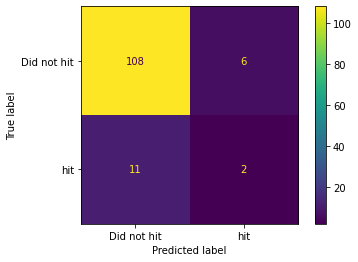

In [257]:
plot_confusion_matrix(clf_xgb,X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not hit","hit"])

In [258]:
param_grid = {
    'max_depth':[3,4,5],
    'learning_rate':[0.1,0.01,0.05],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0],
    'scale_pos_weight':[1,3,5]
}

In [259]:
eval_set = [(X_test, y_test)]

In [260]:
gsearch1 = GridSearchCV(estimator = clf_xgb, param_grid = param_grid
                        ,n_jobs=10,verbose = 2, cv=3)
gsearch1.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[0]	validation_0-logloss:0.62165
[1]	validation_0-logloss:0.56725
[0]	validation_0-logloss:0.62475
[1]	validation_0-logloss:0.56803
[2]	validation_0-logloss:0.52415
[3]	validation_0-logloss:0.48820
[4]	validation_0-logloss:0.45442
[5]	validation_0-logloss:0.42664
[6]	validation_0-logloss:0.40591
[2]	validation_0-logloss:0.52220
[3]	validation_0-logloss:0.48715
[7]	validation_0-logloss:0.38733
[4]	validation_0-logloss:0.45364
[8]	validation_0-logloss:0.37162
[5]	validation_0-logloss:0.42649
[6]	validation_0-logloss:0.40493
[9]	validation_0-logloss:0.35215
[7]	validation_0-logloss:0.38720
[10]	validation_0-logloss:0.33680
[8]	validation_0-logloss:0.37275
[11]	validation_0-logloss:0.32481
[9]	validation_0-logloss:0.36084
[12]	validation_0-logloss:0.31832
[10]	validation_0-logloss:0.34862
[13]	validation_0-logloss:0.30615
[14]	validation_0-logloss:0.29997
[15]	validation_0-logloss:0.28816
[11]	validation_0-logloss:0.33655
[16]	

[42]	validation_0-logloss:0.28795
[60]	validation_0-logloss:0.25315
[61]	validation_0-logloss:0.25144
[62]	validation_0-logloss:0.25232
[63]	validation_0-logloss:0.25069
[48]	validation_0-logloss:0.31741
[49]	validation_0-logloss:0.31958
[50]	validation_0-logloss:0.32123
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   0.3s
[0]	validation_0-logloss:0.62604
[1]	validation_0-logloss:0.57168
[2]	validation_0-logloss:0.52681
[57]	validation_0-logloss:0.25981
[58]	validation_0-logloss:0.25929
[59]	validation_0-logloss:0.26075
[60]	validation_0-logloss:0.26286
[61]	validation_0-logloss:0.26510
[62]	validation_0-logloss:0.26363
[63]	validation_0-logloss:0.26752
[64]	validation_0-logloss:0.26567
[65]	validation_0-logloss:0.26600
[43]	validation_0-logloss:0.28858
[66]	validation_0-logloss:0.26751
[44]	validation_0-logloss:0.28978
[45]	validation_0-logloss:0.29487
[64]	validation_0-logloss:0.24875
[46]	validation_0-logloss:0.29763
[3]	validation_0

[36]	validation_0-logloss:0.25086
[44]	validation_0-logloss:0.25841
[8]	validation_0-logloss:0.41447
[37]	validation_0-logloss:0.24869
[45]	validation_0-logloss:0.25871
[38]	validation_0-logloss:0.24633
[46]	validation_0-logloss:0.25766
[28]	validation_0-logloss:0.26932
[39]	validation_0-logloss:0.24432
[47]	validation_0-logloss:0.25667
[29]	validation_0-logloss:0.26663
[40]	validation_0-logloss:0.24243
[48]	validation_0-logloss:0.25583
[30]	validation_0-logloss:0.26536
[49]	validation_0-logloss:0.25505
[41]	validation_0-logloss:0.24041
[31]	validation_0-logloss:0.26406
[50]	validation_0-logloss:0.25551
[42]	validation_0-logloss:0.23876
[32]	validation_0-logloss:0.26308
[51]	validation_0-logloss:0.25592
[43]	validation_0-logloss:0.23730
[33]	validation_0-logloss:0.26204
[44]	validation_0-logloss:0.23556
[34]	validation_0-logloss:0.26018
[45]	validation_0-logloss:0.23425
[35]	validation_0-logloss:0.25938
[46]	validation_0-logloss:0.23284
[36]	validation_0-logloss:0.25776
[37]	validation

[41]	validation_0-logloss:0.25763
[42]	validation_0-logloss:0.25957
[17]	validation_0-logloss:0.30151
[66]	validation_0-logloss:0.22673
[42]	validation_0-logloss:0.25649
[18]	validation_0-logloss:0.29466
[39]	validation_0-logloss:0.24360
[67]	validation_0-logloss:0.22693
[19]	validation_0-logloss:0.28915
[40]	validation_0-logloss:0.24316
[68]	validation_0-logloss:0.22626
[20]	validation_0-logloss:0.28371
[41]	validation_0-logloss:0.24303
[21]	validation_0-logloss:0.27917
[42]	validation_0-logloss:0.24275
[22]	validation_0-logloss:0.27481
[43]	validation_0-logloss:0.24196
[23]	validation_0-logloss:0.27106
[44]	validation_0-logloss:0.24134
[24]	validation_0-logloss:0.26844
[45]	validation_0-logloss:0.24078
[46]	validation_0-logloss:0.23994
[47]	validation_0-logloss:0.23995
[48]	validation_0-logloss:0.24013
[25]	validation_0-logloss:0.26604
[95]	validation_0-logloss:0.25364
[96]	validation_0-logloss:0.25346
[43]	validation_0-logloss:0.25880
[97]	validation_0-logloss:0.25382
[44]	validatio

[2]	validation_0-logloss:0.52544
[31]	validation_0-logloss:0.23366
[10]	validation_0-logloss:0.34068
[3]	validation_0-logloss:0.48731
[32]	validation_0-logloss:0.23269
[3]	validation_0-logloss:0.48930
[11]	validation_0-logloss:0.32970
[33]	validation_0-logloss:0.23341
[4]	validation_0-logloss:0.45526
[4]	validation_0-logloss:0.46013
[34]	validation_0-logloss:0.23360
[12]	validation_0-logloss:0.32126
[5]	validation_0-logloss:0.42756
[5]	validation_0-logloss:0.43732
[13]	validation_0-logloss:0.32645
[13]	validation_0-logloss:0.31352
[6]	validation_0-logloss:0.40489
[6]	validation_0-logloss:0.41226
[14]	validation_0-logloss:0.30756
[14]	validation_0-logloss:0.31470
[35]	validation_0-logloss:0.23642
[7]	validation_0-logloss:0.39066
[15]	validation_0-logloss:0.30156
[15]	validation_0-logloss:0.30981
[36]	validation_0-logloss:0.23763
[8]	validation_0-logloss:0.37728
[16]	validation_0-logloss:0.29693
[16]	validation_0-logloss:0.29910
[37]	validation_0-logloss:0.23721
[38]	validation_0-logloss

[17]	validation_0-logloss:0.27980
[57]	validation_0-logloss:0.22106
[18]	validation_0-logloss:0.27379
[58]	validation_0-logloss:0.27800
[58]	validation_0-logloss:0.22045
[59]	validation_0-logloss:0.27983
[59]	validation_0-logloss:0.22098
[60]	validation_0-logloss:0.27972
[60]	validation_0-logloss:0.22115
[61]	validation_0-logloss:0.28033
[62]	validation_0-logloss:0.27908
[61]	validation_0-logloss:0.22060
[9]	validation_0-logloss:0.37727
[63]	validation_0-logloss:0.27973
[35]	validation_0-logloss:0.27138
[62]	validation_0-logloss:0.22044
[64]	validation_0-logloss:0.27860
[63]	validation_0-logloss:0.21999
[10]	validation_0-logloss:0.36522
[64]	validation_0-logloss:0.21992
[11]	validation_0-logloss:0.35050
[65]	validation_0-logloss:0.22043
[12]	validation_0-logloss:0.33772
[66]	validation_0-logloss:0.22000
[67]	validation_0-logloss:0.21914
[13]	validation_0-logloss:0.32113
[68]	validation_0-logloss:0.22036
[36]	validation_0-logloss:0.27293
[14]	validation_0-logloss:0.31066
[69]	validation

[30]	validation_0-logloss:0.27178
[59]	validation_0-logloss:0.25433
[3]	validation_0-logloss:0.50960
[74]	validation_0-logloss:0.27463
[31]	validation_0-logloss:0.27015
[60]	validation_0-logloss:0.25476
[4]	validation_0-logloss:0.47915
[75]	validation_0-logloss:0.27484
[32]	validation_0-logloss:0.26650
[61]	validation_0-logloss:0.25428
[76]	validation_0-logloss:0.27456
[5]	validation_0-logloss:0.45359
[33]	validation_0-logloss:0.26331
[62]	validation_0-logloss:0.25395
[77]	validation_0-logloss:0.27400
[6]	validation_0-logloss:0.43091
[63]	validation_0-logloss:0.25440
[34]	validation_0-logloss:0.26076
[7]	validation_0-logloss:0.41127
[78]	validation_0-logloss:0.27479
[64]	validation_0-logloss:0.25460
[79]	validation_0-logloss:0.27406
[35]	validation_0-logloss:0.25791
[8]	validation_0-logloss:0.39464
[80]	validation_0-logloss:0.27500
[65]	validation_0-logloss:0.25431
[36]	validation_0-logloss:0.25524
[9]	validation_0-logloss:0.37874
[81]	validation_0-logloss:0.27461
[66]	validation_0-log

[59]	validation_0-logloss:0.27487
[36]	validation_0-logloss:0.26482
[23]	validation_0-logloss:0.30109
[6]	validation_0-logloss:0.44053
[60]	validation_0-logloss:0.27470
[37]	validation_0-logloss:0.26440
[24]	validation_0-logloss:0.29673
[7]	validation_0-logloss:0.42040
[61]	validation_0-logloss:0.27450
[38]	validation_0-logloss:0.26409
[25]	validation_0-logloss:0.29284
[39]	validation_0-logloss:0.26274
[26]	validation_0-logloss:0.28929
[27]	validation_0-logloss:0.28703
[28]	validation_0-logloss:0.28344
[29]	validation_0-logloss:0.28023
[30]	validation_0-logloss:0.27818
[31]	validation_0-logloss:0.27584
[60]	validation_0-logloss:0.25790
[62]	validation_0-logloss:0.27540
[61]	validation_0-logloss:0.25851
[63]	validation_0-logloss:0.27597
[59]	validation_0-logloss:0.23619
[62]	validation_0-logloss:0.25835
[64]	validation_0-logloss:0.27619
[60]	validation_0-logloss:0.23537
[63]	validation_0-logloss:0.25838
[65]	validation_0-logloss:0.27594
[64]	validation_0-logloss:0.25857
[61]	validation_

[38]	validation_0-logloss:0.23319
[21]	validation_0-logloss:0.27968
[39]	validation_0-logloss:0.23495
[40]	validation_0-logloss:0.23369
[22]	validation_0-logloss:0.27907
[41]	validation_0-logloss:0.23373
[45]	validation_0-logloss:0.25009
[23]	validation_0-logloss:0.28057
[42]	validation_0-logloss:0.23508
[46]	validation_0-logloss:0.25033
[24]	validation_0-logloss:0.28102
[43]	validation_0-logloss:0.23359
[47]	validation_0-logloss:0.25015
[25]	validation_0-logloss:0.28065
[44]	validation_0-logloss:0.23158
[48]	validation_0-logloss:0.25024
[26]	validation_0-logloss:0.28187
[45]	validation_0-logloss:0.23280
[78]	validation_0-logloss:0.26954
[2]	validation_0-logloss:0.53840
[70]	validation_0-logloss:0.25159
[49]	validation_0-logloss:0.25022
[79]	validation_0-logloss:0.27005
[50]	validation_0-logloss:0.25062
[71]	validation_0-logloss:0.25157
[3]	validation_0-logloss:0.50062
[51]	validation_0-logloss:0.25078
[72]	validation_0-logloss:0.25237
[4]	validation_0-logloss:0.46812
[52]	validation_0

[45]	validation_0-logloss:0.34292
[35]	validation_0-logloss:0.28981
[26]	validation_0-logloss:0.28351
[46]	validation_0-logloss:0.34243
[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   0.3s
[0]	validation_0-logloss:0.63129
[36]	validation_0-logloss:0.29086
[47]	validation_0-logloss:0.34346
[27]	validation_0-logloss:0.28349
[1]	validation_0-logloss:0.58073
[48]	validation_0-logloss:0.34549
[37]	validation_0-logloss:0.28993
[28]	validation_0-logloss:0.28537
[15]	validation_0-logloss:0.30028
[2]	validation_0-logloss:0.53423
[38]	validation_0-logloss:0.29108
[14]	validation_0-logloss:0.29358
[16]	validation_0-logloss:0.29487
[39]	validation_0-logloss:0.29330
[15]	validation_0-logloss:0.28814
[17]	validation_0-logloss:0.29126
[40]	validation_0-logloss:0.29580
[16]	validation_0-logloss:0.28258
[41]	validation_0-logloss:0.29854
[18]	validation_0-logloss:0.28707
[17]	validation_0-logloss:0.28005
[42]	validation_0-logloss:0.30147
[19]	validation_

[46]	validation_0-logloss:0.31839
[55]	validation_0-logloss:0.24128
[47]	validation_0-logloss:0.32059
[13]	validation_0-logloss:0.34704
[48]	validation_0-logloss:0.32118
[56]	validation_0-logloss:0.24192
[14]	validation_0-logloss:0.33871
[49]	validation_0-logloss:0.32185
[57]	validation_0-logloss:0.24072
[15]	validation_0-logloss:0.33085
[50]	validation_0-logloss:0.32212
[58]	validation_0-logloss:0.24121
[18]	validation_0-logloss:0.27776
[51]	validation_0-logloss:0.32368
[16]	validation_0-logloss:0.32346
[59]	validation_0-logloss:0.24142
[60]	validation_0-logloss:0.24271
[17]	validation_0-logloss:0.31781
[61]	validation_0-logloss:0.24251
[18]	validation_0-logloss:0.31170
[62]	validation_0-logloss:0.24181
[19]	validation_0-logloss:0.30643
[63]	validation_0-logloss:0.24222
[64]	validation_0-logloss:0.24265
[20]	validation_0-logloss:0.30226
[19]	validation_0-logloss:0.27315
[65]	validation_0-logloss:0.24317
[21]	validation_0-logloss:0.29839
[20]	validation_0-logloss:0.26902
[66]	validatio

[40]	validation_0-logloss:0.27189
[72]	validation_0-logloss:0.24972
[13]	validation_0-logloss:0.34504
[57]	validation_0-logloss:0.22821
[41]	validation_0-logloss:0.27101
[73]	validation_0-logloss:0.25026
[14]	validation_0-logloss:0.33457
[58]	validation_0-logloss:0.22736
[42]	validation_0-logloss:0.27049
[74]	validation_0-logloss:0.24996
[15]	validation_0-logloss:0.32548
[59]	validation_0-logloss:0.22665
[75]	validation_0-logloss:0.25018
[43]	validation_0-logloss:0.27092
[16]	validation_0-logloss:0.31907
[76]	validation_0-logloss:0.24991
[60]	validation_0-logloss:0.22589
[44]	validation_0-logloss:0.27033
[17]	validation_0-logloss:0.31186
[77]	validation_0-logloss:0.25014
[61]	validation_0-logloss:0.22513
[45]	validation_0-logloss:0.27005
[18]	validation_0-logloss:0.30685
[78]	validation_0-logloss:0.24996
[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   0.3s
[0]	validation_0-logloss:0.64465
[62]	validation_0-logloss:0.22441
[46]	validat

[48]	validation_0-logloss:0.25837
[69]	validation_0-logloss:0.23678
[15]	validation_0-logloss:0.59065
[49]	validation_0-logloss:0.25840
[16]	validation_0-logloss:0.58542
[50]	validation_0-logloss:0.25843
[20]	validation_0-logloss:0.28993
[17]	validation_0-logloss:0.58030
[70]	validation_0-logloss:0.23687
[51]	validation_0-logloss:0.25842
[18]	validation_0-logloss:0.57521
[21]	validation_0-logloss:0.28575
[71]	validation_0-logloss:0.23621
[52]	validation_0-logloss:0.25955
[19]	validation_0-logloss:0.57029
[72]	validation_0-logloss:0.23652
[73]	validation_0-logloss:0.23724
[22]	validation_0-logloss:0.28217
[20]	validation_0-logloss:0.56546
[53]	validation_0-logloss:0.25967
[74]	validation_0-logloss:0.23777
[23]	validation_0-logloss:0.27794
[21]	validation_0-logloss:0.56072
[54]	validation_0-logloss:0.25929
[75]	validation_0-logloss:0.23802
[81]	validation_0-logloss:0.25542
[22]	validation_0-logloss:0.55602
[24]	validation_0-logloss:0.27409
[55]	validation_0-logloss:0.26050
[23]	validatio

[45]	validation_0-logloss:0.48250
[15]	validation_0-logloss:0.58552
[38]	validation_0-logloss:0.49940
[35]	validation_0-logloss:0.51661
[46]	validation_0-logloss:0.47985
[45]	validation_0-logloss:0.45317
[16]	validation_0-logloss:0.57975
[36]	validation_0-logloss:0.51322
[47]	validation_0-logloss:0.47706
[17]	validation_0-logloss:0.57429
[46]	validation_0-logloss:0.44976
[37]	validation_0-logloss:0.51002
[48]	validation_0-logloss:0.47419
[18]	validation_0-logloss:0.56893
[47]	validation_0-logloss:0.44644
[38]	validation_0-logloss:0.50662
[49]	validation_0-logloss:0.47169
[39]	validation_0-logloss:0.50354
[50]	validation_0-logloss:0.46892
[40]	validation_0-logloss:0.50036
[51]	validation_0-logloss:0.46584
[41]	validation_0-logloss:0.49740
[52]	validation_0-logloss:0.46349
[53]	validation_0-logloss:0.46119
[48]	validation_0-logloss:0.44314
[42]	validation_0-logloss:0.49433
[54]	validation_0-logloss:0.45857
[43]	validation_0-logloss:0.49085
[49]	validation_0-logloss:0.43992
[44]	validatio

[95]	validation_0-logloss:0.37127
[38]	validation_0-logloss:0.49374
[5]	validation_0-logloss:0.65295
[89]	validation_0-logloss:0.35342
[96]	validation_0-logloss:0.36937
[39]	validation_0-logloss:0.49026
[6]	validation_0-logloss:0.64671
[90]	validation_0-logloss:0.35216
[97]	validation_0-logloss:0.36803
[40]	validation_0-logloss:0.48673
[7]	validation_0-logloss:0.64059
[91]	validation_0-logloss:0.35041
[41]	validation_0-logloss:0.48336
[98]	validation_0-logloss:0.36632
[8]	validation_0-logloss:0.63460
[92]	validation_0-logloss:0.34920
[42]	validation_0-logloss:0.47991
[9]	validation_0-logloss:0.62872
[99]	validation_0-logloss:0.36469
[43]	validation_0-logloss:0.47664
[10]	validation_0-logloss:0.62295
[93]	validation_0-logloss:0.34751
[11]	validation_0-logloss:0.61729
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   0.4s
[0]	validation_0-logloss:0.68577
[12]	validation_0-logloss:0.61174
[1]	validation_0-logloss:0.67854
[13]	validation_0-l

[44]	validation_0-logloss:0.46185
[56]	validation_0-logloss:0.42841
[68]	validation_0-logloss:0.41919
[45]	validation_0-logloss:0.45838
[57]	validation_0-logloss:0.42598
[69]	validation_0-logloss:0.41672
[46]	validation_0-logloss:0.45497
[58]	validation_0-logloss:0.42321
[70]	validation_0-logloss:0.41456
[59]	validation_0-logloss:0.42036
[47]	validation_0-logloss:0.45173
[71]	validation_0-logloss:0.41223
[60]	validation_0-logloss:0.41747
[48]	validation_0-logloss:0.44842
[23]	validation_0-logloss:0.54822
[0]	validation_0-logloss:0.62419
[42]	validation_0-logloss:0.48537
[24]	validation_0-logloss:0.54337
[91]	validation_0-logloss:0.37493
[62]	validation_0-logloss:0.44862
[43]	validation_0-logloss:0.48225
[25]	validation_0-logloss:0.53876
[92]	validation_0-logloss:0.37337
[63]	validation_0-logloss:0.44645
[44]	validation_0-logloss:0.47904
[51]	validation_0-logloss:0.48178
[26]	validation_0-logloss:0.53423
[64]	validation_0-logloss:0.44407
[45]	validation_0-logloss:0.47563
[27]	validation

[0]	validation_0-logloss:0.68777
[96]	validation_0-logloss:0.34528
[44]	validation_0-logloss:0.50502
[1]	validation_0-logloss:0.68255
[97]	validation_0-logloss:0.34391
[45]	validation_0-logloss:0.50211
[2]	validation_0-logloss:0.67741
[98]	validation_0-logloss:0.34224
[46]	validation_0-logloss:0.49911
[3]	validation_0-logloss:0.67235
[47]	validation_0-logloss:0.49628
[12]	validation_0-logloss:0.31762
[4]	validation_0-logloss:0.66737
[48]	validation_0-logloss:0.49343
[13]	validation_0-logloss:0.30832
[5]	validation_0-logloss:0.66247
[49]	validation_0-logloss:0.49065
[14]	validation_0-logloss:0.30278
[6]	validation_0-logloss:0.65763
[50]	validation_0-logloss:0.48794
[15]	validation_0-logloss:0.29760
[7]	validation_0-logloss:0.65290
[51]	validation_0-logloss:0.48513
[16]	validation_0-logloss:0.29144
[8]	validation_0-logloss:0.64824
[52]	validation_0-logloss:0.48243
[17]	validation_0-logloss:0.28585
[12]	validation_0-logloss:0.62207
[9]	validation_0-logloss:0.64365
[53]	validation_0-loglos

[11]	validation_0-logloss:0.63204
[68]	validation_0-logloss:0.45230
[36]	validation_0-logloss:0.53344
[91]	validation_0-logloss:0.40580
[12]	validation_0-logloss:0.62745
[69]	validation_0-logloss:0.45001
[37]	validation_0-logloss:0.53023
[13]	validation_0-logloss:0.62285
[92]	validation_0-logloss:0.40413
[70]	validation_0-logloss:0.44772
[38]	validation_0-logloss:0.52700
[14]	validation_0-logloss:0.61840
[39]	validation_0-logloss:0.52386
[93]	validation_0-logloss:0.40258
[15]	validation_0-logloss:0.61393
[40]	validation_0-logloss:0.52078
[94]	validation_0-logloss:0.40095
[95]	validation_0-logloss:0.39944
[27]	validation_0-logloss:0.57916
[96]	validation_0-logloss:0.39786
[41]	validation_0-logloss:0.51772
[28]	validation_0-logloss:0.57592
[97]	validation_0-logloss:0.39638
[29]	validation_0-logloss:0.57263
[42]	validation_0-logloss:0.51466
[98]	validation_0-logloss:0.39483
[30]	validation_0-logloss:0.56939
[43]	validation_0-logloss:0.51171
[99]	validation_0-logloss:0.39340
[44]	validatio

[97]	validation_0-logloss:0.39121
[35]	validation_0-logloss:0.49096
[9]	validation_0-logloss:0.63026
[98]	validation_0-logloss:0.38965
[36]	validation_0-logloss:0.48720
[10]	validation_0-logloss:0.62485
[99]	validation_0-logloss:0.38808
[37]	validation_0-logloss:0.48354
[11]	validation_0-logloss:0.61956
[38]	validation_0-logloss:0.47993
[12]	validation_0-logloss:0.61382
[13]	validation_0-logloss:0.60875
[39]	validation_0-logloss:0.47642
[14]	validation_0-logloss:0.60379
[40]	validation_0-logloss:0.47294
[15]	validation_0-logloss:0.59838
[41]	validation_0-logloss:0.46953
[16]	validation_0-logloss:0.59362
[42]	validation_0-logloss:0.46621
[17]	validation_0-logloss:0.58897
[43]	validation_0-logloss:0.46292
[66]	validation_0-logloss:0.40220
[44]	validation_0-logloss:0.45974
[67]	validation_0-logloss:0.39978
[45]	validation_0-logloss:0.45652
[68]	validation_0-logloss:0.39753
[46]	validation_0-logloss:0.45342
[69]	validation_0-logloss:0.39483
[47]	validation_0-logloss:0.45033
[70]	validation

[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   0.4s
[0]	validation_0-logloss:0.68577
[77]	validation_0-logloss:0.41301
[54]	validation_0-logloss:0.47018
[1]	validation_0-logloss:0.67854
[24]	validation_0-logloss:0.54988
[78]	validation_0-logloss:0.41103
[2]	validation_0-logloss:0.67145
[55]	validation_0-logloss:0.46778
[25]	validation_0-logloss:0.54554
[3]	validation_0-logloss:0.66451
[79]	validation_0-logloss:0.40988
[34]	validation_0-logloss:0.52539
[56]	validation_0-logloss:0.46503
[26]	validation_0-logloss:0.54098
[80]	validation_0-logloss:0.40816
[27]	validation_0-logloss:0.53679
[57]	validation_0-logloss:0.46270
[81]	validation_0-logloss:0.40691
[82]	validation_0-logloss:0.40483
[58]	validation_0-logloss:0.46001
[28]	validation_0-logloss:0.53268
[83]	validation_0-logloss:0.40284
[84]	validation_0-logloss:0.40138
[59]	validation_0-logloss:0.45775
[29]	validation_0-logloss:0.52856
[85]	validation_0-logloss:0.39945
[35]	validation_

[82]	validation_0-logloss:0.38265
[39]	validation_0-logloss:0.49516
[43]	validation_0-logloss:0.46935
[86]	validation_0-logloss:0.37371
[40]	validation_0-logloss:0.49188
[44]	validation_0-logloss:0.46613
[87]	validation_0-logloss:0.37234
[41]	validation_0-logloss:0.48855
[45]	validation_0-logloss:0.46282
[89]	validation_0-logloss:0.38875
[12]	validation_0-logloss:0.62121
[26]	validation_0-logloss:0.55049
[88]	validation_0-logloss:0.37059
[83]	validation_0-logloss:0.38081
[27]	validation_0-logloss:0.54603
[89]	validation_0-logloss:0.36931
[90]	validation_0-logloss:0.38729
[84]	validation_0-logloss:0.37914
[90]	validation_0-logloss:0.36799
[91]	validation_0-logloss:0.38585
[85]	validation_0-logloss:0.37747
[91]	validation_0-logloss:0.36671
[86]	validation_0-logloss:0.37587
[92]	validation_0-logloss:0.38445
[92]	validation_0-logloss:0.36510
[87]	validation_0-logloss:0.37420
[93]	validation_0-logloss:0.38307
[93]	validation_0-logloss:0.36351
[88]	validation_0-logloss:0.37264
[94]	validatio

[41]	validation_0-logloss:0.51733
[51]	validation_0-logloss:0.48277
[32]	validation_0-logloss:0.51217
[42]	validation_0-logloss:0.51431
[52]	validation_0-logloss:0.48015
[33]	validation_0-logloss:0.50820
[43]	validation_0-logloss:0.51134
[53]	validation_0-logloss:0.47752
[34]	validation_0-logloss:0.50430
[44]	validation_0-logloss:0.50838
[54]	validation_0-logloss:0.47499
[35]	validation_0-logloss:0.50054
[45]	validation_0-logloss:0.50549
[36]	validation_0-logloss:0.49677
[55]	validation_0-logloss:0.47210
[78]	validation_0-logloss:0.41585
[79]	validation_0-logloss:0.41423
[41]	validation_0-logloss:0.51398
[80]	validation_0-logloss:0.41229
[42]	validation_0-logloss:0.51093
[81]	validation_0-logloss:0.41073
[43]	validation_0-logloss:0.50784
[82]	validation_0-logloss:0.40865
[44]	validation_0-logloss:0.50490
[83]	validation_0-logloss:0.40696
[45]	validation_0-logloss:0.50189
[93]	validation_0-logloss:0.37140
[84]	validation_0-logloss:0.40513
[46]	validation_0-logloss:0.49903
[CV] END gamma

[25]	validation_0-logloss:0.57904
[89]	validation_0-logloss:0.39859
[92]	validation_0-logloss:0.40066
[81]	validation_0-logloss:0.41176
[26]	validation_0-logloss:0.57547
[93]	validation_0-logloss:0.39912
[90]	validation_0-logloss:0.39714
[82]	validation_0-logloss:0.41001
[27]	validation_0-logloss:0.57196
[94]	validation_0-logloss:0.39755
[83]	validation_0-logloss:0.40830
[91]	validation_0-logloss:0.39552
[98]	validation_0-logloss:0.35408
[28]	validation_0-logloss:0.56849
[95]	validation_0-logloss:0.39605
[92]	validation_0-logloss:0.39377
[96]	validation_0-logloss:0.39451
[29]	validation_0-logloss:0.56508
[97]	validation_0-logloss:0.39303
[93]	validation_0-logloss:0.39204
[98]	validation_0-logloss:0.39158
[30]	validation_0-logloss:0.56171
[99]	validation_0-logloss:0.39010
[94]	validation_0-logloss:0.39035
[31]	validation_0-logloss:0.55839
[95]	validation_0-logloss:0.38868
[32]	validation_0-logloss:0.55512
[96]	validation_0-logloss:0.38703
[23]	validation_0-logloss:0.59790
[99]	validatio

[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   0.5s
[0]	validation_0-logloss:0.68603
[27]	validation_0-logloss:0.53381
[1]	validation_0-logloss:0.67882
[28]	validation_0-logloss:0.52969
[2]	validation_0-logloss:0.67184
[29]	validation_0-logloss:0.52590
[5]	validation_0-logloss:0.64926
[3]	validation_0-logloss:0.66500
[4]	validation_0-logloss:0.65825
[89]	validation_0-logloss:0.44967
[30]	validation_0-logloss:0.52180
[6]	validation_0-logloss:0.64254
[5]	validation_0-logloss:0.65166
[90]	validation_0-logloss:0.44791
[31]	validation_0-logloss:0.51815
[7]	validation_0-logloss:0.63590
[56]	validation_0-logloss:0.47628
[91]	validation_0-logloss:0.44639
[57]	validation_0-logloss:0.47376
[8]	validation_0-logloss:0.62939
[92]	validation_0-logloss:0.44491
[32]	validation_0-logloss:0.51420
[58]	validation_0-logloss:0.47122
[9]	validation_0-logloss:0.62307
[93]	validation_0-logloss:0.44318
[33]	validation_0-logloss:0.51069
[59]	validation_0-log

[93]	validation_0-logloss:0.36633
[72]	validation_0-logloss:0.43459
[75]	validation_0-logloss:0.38681
[11]	validation_0-logloss:0.61095
[73]	validation_0-logloss:0.43304
[94]	validation_0-logloss:0.36485
[76]	validation_0-logloss:0.38486
[35]	validation_0-logloss:0.52442
[74]	validation_0-logloss:0.43110
[12]	validation_0-logloss:0.60504
[77]	validation_0-logloss:0.38292
[75]	validation_0-logloss:0.42903
[36]	validation_0-logloss:0.52137
[13]	validation_0-logloss:0.59921
[78]	validation_0-logloss:0.38104
[37]	validation_0-logloss:0.51833
[14]	validation_0-logloss:0.59347
[79]	validation_0-logloss:0.37916
[15]	validation_0-logloss:0.58791
[38]	validation_0-logloss:0.51537
[80]	validation_0-logloss:0.37731
[16]	validation_0-logloss:0.58240
[39]	validation_0-logloss:0.51247
[81]	validation_0-logloss:0.37564
[17]	validation_0-logloss:0.57708
[40]	validation_0-logloss:0.50964
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   0.4s
[0]	valid

[98]	validation_0-logloss:0.35605
[31]	validation_0-logloss:0.52405
[78]	validation_0-logloss:0.38740
[50]	validation_0-logloss:0.45646
[99]	validation_0-logloss:0.35458
[32]	validation_0-logloss:0.52038
[51]	validation_0-logloss:0.45363
[79]	validation_0-logloss:0.38578
[33]	validation_0-logloss:0.51676
[52]	validation_0-logloss:0.45066
[80]	validation_0-logloss:0.38411
[34]	validation_0-logloss:0.51321
[53]	validation_0-logloss:0.44792
[81]	validation_0-logloss:0.38260
[35]	validation_0-logloss:0.50956
[54]	validation_0-logloss:0.44504
[82]	validation_0-logloss:0.38108
[15]	validation_0-logloss:0.60190
[36]	validation_0-logloss:0.50612
[83]	validation_0-logloss:0.37927
[CV] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   0.6s
[0]	validation_0-logloss:0.68697
[37]	validation_0-logloss:0.50260
[84]	validation_0-logloss:0.37765
[16]	validation_0-logloss:0.59703
[38]	validation_0-logloss:0.49914
[85]	validation_0-logloss:0.37626
[17]	validati

[87]	validation_0-logloss:0.40016
[44]	validation_0-logloss:0.50384
[13]	validation_0-logloss:0.60195
[74]	validation_0-logloss:0.40432
[88]	validation_0-logloss:0.39878
[14]	validation_0-logloss:0.59632
[45]	validation_0-logloss:0.50129
[75]	validation_0-logloss:0.40227
[89]	validation_0-logloss:0.39741
[15]	validation_0-logloss:0.59084
[46]	validation_0-logloss:0.49840
[76]	validation_0-logloss:0.40030
[16]	validation_0-logloss:0.58542
[90]	validation_0-logloss:0.39611
[77]	validation_0-logloss:0.39831
[47]	validation_0-logloss:0.49527
[17]	validation_0-logloss:0.58014
[91]	validation_0-logloss:0.39479
[48]	validation_0-logloss:0.49245
[78]	validation_0-logloss:0.39646
[18]	validation_0-logloss:0.57491
[58]	validation_0-logloss:0.44871
[98]	validation_0-logloss:0.38799
[49]	validation_0-logloss:0.48970
[90]	validation_0-logloss:0.36937
[75]	validation_0-logloss:0.38569
[59]	validation_0-logloss:0.44609
[99]	validation_0-logloss:0.38701
[91]	validation_0-logloss:0.36786
[76]	validatio

[67]	validation_0-logloss:0.42590
[99]	validation_0-logloss:0.37794
[49]	validation_0-logloss:0.48661
[22]	validation_0-logloss:0.57662
[68]	validation_0-logloss:0.42359
[23]	validation_0-logloss:0.57245
[50]	validation_0-logloss:0.48428
[24]	validation_0-logloss:0.56834
[69]	validation_0-logloss:0.42191
[51]	validation_0-logloss:0.48162
[25]	validation_0-logloss:0.56430
[70]	validation_0-logloss:0.41974
[26]	validation_0-logloss:0.56032
[52]	validation_0-logloss:0.47930
[71]	validation_0-logloss:0.41813
[27]	validation_0-logloss:0.55640
[53]	validation_0-logloss:0.47712
[28]	validation_0-logloss:0.55253
[91]	validation_0-logloss:0.36303
[29]	validation_0-logloss:0.54873
[54]	validation_0-logloss:0.47440
[92]	validation_0-logloss:0.36158
[30]	validation_0-logloss:0.54498
[CV] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=3; total time=   0.5s
[0]	validation_0-logloss:0.68765
[93]	validation_0-logloss:0.36015
[55]	validation_0-logloss:0.47225
[31]	valida

[3]	validation_0-logloss:0.56911
[54]	validation_0-logloss:0.51427
[7]	validation_0-logloss:0.48814
[50]	validation_0-logloss:0.50440
[4]	validation_0-logloss:0.54572
[8]	validation_0-logloss:0.47243
[55]	validation_0-logloss:0.51200
[5]	validation_0-logloss:0.52456
[51]	validation_0-logloss:0.50170
[9]	validation_0-logloss:0.45770
[56]	validation_0-logloss:0.50976
[6]	validation_0-logloss:0.50483
[52]	validation_0-logloss:0.49920
[10]	validation_0-logloss:0.44540
[7]	validation_0-logloss:0.48560
[57]	validation_0-logloss:0.50766
[14]	validation_0-logloss:0.37348
[53]	validation_0-logloss:0.49655
[58]	validation_0-logloss:0.50554
[8]	validation_0-logloss:0.47018
[11]	validation_0-logloss:0.43252
[15]	validation_0-logloss:0.36368
[6]	validation_0-logloss:0.65647
[54]	validation_0-logloss:0.49375
[9]	validation_0-logloss:0.45543
[12]	validation_0-logloss:0.41978
[7]	validation_0-logloss:0.65150
[10]	validation_0-logloss:0.44120
[55]	validation_0-logloss:0.49134
[13]	validation_0-logloss:

[37]	validation_0-logloss:0.29502
[11]	validation_0-logloss:0.44374
[91]	validation_0-logloss:0.40121
[38]	validation_0-logloss:0.29436
[12]	validation_0-logloss:0.43383
[92]	validation_0-logloss:0.39953
[39]	validation_0-logloss:0.29244
[13]	validation_0-logloss:0.42352
[40]	validation_0-logloss:0.29047
[93]	validation_0-logloss:0.39787
[14]	validation_0-logloss:0.41395
[41]	validation_0-logloss:0.28904
[15]	validation_0-logloss:0.40410
[82]	validation_0-logloss:0.41888
[42]	validation_0-logloss:0.28702
[16]	validation_0-logloss:0.39441
[94]	validation_0-logloss:0.39635
[83]	validation_0-logloss:0.41689
[70]	validation_0-logloss:0.47222
[95]	validation_0-logloss:0.39473
[43]	validation_0-logloss:0.28532
[96]	validation_0-logloss:0.39324
[71]	validation_0-logloss:0.47013
[84]	validation_0-logloss:0.41504
[44]	validation_0-logloss:0.28476
[97]	validation_0-logloss:0.39165
[72]	validation_0-logloss:0.46834
[85]	validation_0-logloss:0.41324
[45]	validation_0-logloss:0.28434
[98]	validatio

[19]	validation_0-logloss:0.36151
[82]	validation_0-logloss:0.23672
[67]	validation_0-logloss:0.27930
[13]	validation_0-logloss:0.40523
[20]	validation_0-logloss:0.35532
[83]	validation_0-logloss:0.23846
[68]	validation_0-logloss:0.27994
[14]	validation_0-logloss:0.39449
[21]	validation_0-logloss:0.34912
[84]	validation_0-logloss:0.23712
[69]	validation_0-logloss:0.28119
[15]	validation_0-logloss:0.38497
[22]	validation_0-logloss:0.34352
[85]	validation_0-logloss:0.23893
[70]	validation_0-logloss:0.28303
[23]	validation_0-logloss:0.33790
[86]	validation_0-logloss:0.23767
[71]	validation_0-logloss:0.28396
[24]	validation_0-logloss:0.33302
[87]	validation_0-logloss:0.23650
[72]	validation_0-logloss:0.28531
[25]	validation_0-logloss:0.32761
[88]	validation_0-logloss:0.23839
[73]	validation_0-logloss:0.28722
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=3; total time=   0.4s
[0]	validation_0-logloss:0.66076
[26]	validation_0-logloss:0.32338
[89]	validati

[63]	validation_0-logloss:0.25867
[8]	validation_0-logloss:0.47725
[97]	validation_0-logloss:0.25935
[64]	validation_0-logloss:0.25968
[80]	validation_0-logloss:0.30157
[9]	validation_0-logloss:0.46081
[98]	validation_0-logloss:0.25855
[65]	validation_0-logloss:0.25962
[81]	validation_0-logloss:0.30345
[10]	validation_0-logloss:0.44723
[66]	validation_0-logloss:0.26070
[82]	validation_0-logloss:0.30403
[11]	validation_0-logloss:0.43313
[67]	validation_0-logloss:0.26035
[12]	validation_0-logloss:0.42023
[68]	validation_0-logloss:0.26147
[13]	validation_0-logloss:0.40850
[48]	validation_0-logloss:0.26112
[30]	validation_0-logloss:0.29672
[69]	validation_0-logloss:0.26136
[49]	validation_0-logloss:0.25984
[14]	validation_0-logloss:0.39869
[70]	validation_0-logloss:0.26252
[31]	validation_0-logloss:0.29170
[71]	validation_0-logloss:0.26371
[50]	validation_0-logloss:0.25870
[15]	validation_0-logloss:0.38864
[32]	validation_0-logloss:0.28893
[72]	validation_0-logloss:0.26349
[51]	validation_

[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   0.3s
[0]	validation_0-logloss:0.66962
[20]	validation_0-logloss:0.38567
[94]	validation_0-logloss:0.22381
[47]	validation_0-logloss:0.29170
[21]	validation_0-logloss:0.37777
[1]	validation_0-logloss:0.64706
[95]	validation_0-logloss:0.22352
[48]	validation_0-logloss:0.28972
[22]	validation_0-logloss:0.37187
[96]	validation_0-logloss:0.22451
[2]	validation_0-logloss:0.62617
[49]	validation_0-logloss:0.28804
[23]	validation_0-logloss:0.36498
[97]	validation_0-logloss:0.22412
[3]	validation_0-logloss:0.60742
[50]	validation_0-logloss:0.28668
[98]	validation_0-logloss:0.22337
[24]	validation_0-logloss:0.35975
[4]	validation_0-logloss:0.58936
[51]	validation_0-logloss:0.28510
[99]	validation_0-logloss:0.22371
[25]	validation_0-logloss:0.35353
[74]	validation_0-logloss:0.26020
[5]	validation_0-logloss:0.57313
[26]	validation_0-logloss:0.34766
[75]	validation_0-logloss:0.26079
[6]	validation_0

[55]	validation_0-logloss:0.27616
[59]	validation_0-logloss:0.25830
[88]	validation_0-logloss:0.25115
[55]	validation_0-logloss:0.28426
[56]	validation_0-logloss:0.27412
[60]	validation_0-logloss:0.25734
[56]	validation_0-logloss:0.28287
[89]	validation_0-logloss:0.25092
[57]	validation_0-logloss:0.27197
[61]	validation_0-logloss:0.25637
[90]	validation_0-logloss:0.25087
[57]	validation_0-logloss:0.28154
[58]	validation_0-logloss:0.27047
[62]	validation_0-logloss:0.25552
[91]	validation_0-logloss:0.25077
[58]	validation_0-logloss:0.28027
[59]	validation_0-logloss:0.27917
[63]	validation_0-logloss:0.25472
[92]	validation_0-logloss:0.25009
[59]	validation_0-logloss:0.26851
[93]	validation_0-logloss:0.24990
[64]	validation_0-logloss:0.25367
[60]	validation_0-logloss:0.26713
[94]	validation_0-logloss:0.24989
[65]	validation_0-logloss:0.25268
[61]	validation_0-logloss:0.26597
[95]	validation_0-logloss:0.24989
[66]	validation_0-logloss:0.25200
[96]	validation_0-logloss:0.24973
[67]	validatio

[58]	validation_0-logloss:0.25752
[76]	validation_0-logloss:0.26171
[59]	validation_0-logloss:0.25647
[1]	validation_0-logloss:0.63088
[10]	validation_0-logloss:0.47146
[77]	validation_0-logloss:0.26108
[60]	validation_0-logloss:0.25557
[2]	validation_0-logloss:0.60458
[78]	validation_0-logloss:0.26072
[61]	validation_0-logloss:0.25499
[11]	validation_0-logloss:0.45694
[3]	validation_0-logloss:0.57784
[79]	validation_0-logloss:0.26050
[62]	validation_0-logloss:0.25423
[12]	validation_0-logloss:0.44440
[80]	validation_0-logloss:0.25996
[63]	validation_0-logloss:0.25372
[13]	validation_0-logloss:0.43448
[81]	validation_0-logloss:0.25981
[64]	validation_0-logloss:0.25289
[82]	validation_0-logloss:0.25941
[14]	validation_0-logloss:0.42464
[65]	validation_0-logloss:0.25237
[83]	validation_0-logloss:0.25916
[15]	validation_0-logloss:0.41623
[66]	validation_0-logloss:0.25145
[84]	validation_0-logloss:0.25900
[67]	validation_0-logloss:0.25077
[16]	validation_0-logloss:0.40548
[68]	validation_0

[64]	validation_0-logloss:0.28892
[19]	validation_0-logloss:0.35618
[60]	validation_0-logloss:0.25269
[34]	validation_0-logloss:0.29838
[65]	validation_0-logloss:0.28966
[20]	validation_0-logloss:0.34943
[61]	validation_0-logloss:0.25222
[66]	validation_0-logloss:0.28995
[35]	validation_0-logloss:0.29547
[62]	validation_0-logloss:0.25297
[21]	validation_0-logloss:0.34382
[67]	validation_0-logloss:0.28823
[36]	validation_0-logloss:0.29404
[63]	validation_0-logloss:0.25247
[68]	validation_0-logloss:0.28779
[22]	validation_0-logloss:0.33878
[23]	validation_0-logloss:0.33518
[37]	validation_0-logloss:0.29255
[24]	validation_0-logloss:0.32948
[38]	validation_0-logloss:0.28970
[25]	validation_0-logloss:0.32480
[64]	validation_0-logloss:0.25389
[60]	validation_0-logloss:0.29333
[26]	validation_0-logloss:0.32055
[39]	validation_0-logloss:0.28699
[27]	validation_0-logloss:0.31560
[40]	validation_0-logloss:0.28387
[28]	validation_0-logloss:0.31144
[41]	validation_0-logloss:0.28259
[29]	validatio

[75]	validation_0-logloss:0.27963
[83]	validation_0-logloss:0.28847
[70]	validation_0-logloss:0.29328
[98]	validation_0-logloss:0.27260
[76]	validation_0-logloss:0.27919
[84]	validation_0-logloss:0.28964
[71]	validation_0-logloss:0.29374
[77]	validation_0-logloss:0.28031
[85]	validation_0-logloss:0.29081
[72]	validation_0-logloss:0.29573
[78]	validation_0-logloss:0.28144
[86]	validation_0-logloss:0.29309
[73]	validation_0-logloss:0.29620
[79]	validation_0-logloss:0.28154
[74]	validation_0-logloss:0.29628
[80]	validation_0-logloss:0.28268
[81]	validation_0-logloss:0.28383
[75]	validation_0-logloss:0.29679
[74]	validation_0-logloss:0.27968
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   0.4s
[0]	validation_0-logloss:0.66319
[76]	validation_0-logloss:0.29872
[75]	validation_0-logloss:0.28050
[77]	validation_0-logloss:0.29911
[1]	validation_0-logloss:0.63651
[76]	validation_0-logloss:0.28025
[78]	validation_0-logloss:0.29970
[2]	validation

[42]	validation_0-logloss:0.29401
[27]	validation_0-logloss:0.31374
[38]	validation_0-logloss:0.29450
[68]	validation_0-logloss:0.24846
[43]	validation_0-logloss:0.29227
[28]	validation_0-logloss:0.31095
[39]	validation_0-logloss:0.29271
[69]	validation_0-logloss:0.24753
[44]	validation_0-logloss:0.29033
[29]	validation_0-logloss:0.30740
[40]	validation_0-logloss:0.28997
[70]	validation_0-logloss:0.24707
[45]	validation_0-logloss:0.28802
[30]	validation_0-logloss:0.30520
[71]	validation_0-logloss:0.24739
[72]	validation_0-logloss:0.24734
[46]	validation_0-logloss:0.28661
[41]	validation_0-logloss:0.28793
[73]	validation_0-logloss:0.24748
[42]	validation_0-logloss:0.28667
[47]	validation_0-logloss:0.28449
[31]	validation_0-logloss:0.30269
[74]	validation_0-logloss:0.24787
[48]	validation_0-logloss:0.25229
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   0.3s
[0]	validation_0-logloss:0.66545
[43]	validation_0-logloss:0.28442
[32]	validati

[32]	validation_0-logloss:0.35954
[27]	validation_0-logloss:0.35128
[20]	validation_0-logloss:0.38929
[13]	validation_0-logloss:0.44115
[33]	validation_0-logloss:0.35547
[28]	validation_0-logloss:0.34689
[14]	validation_0-logloss:0.43140
[21]	validation_0-logloss:0.38182
[34]	validation_0-logloss:0.35033
[29]	validation_0-logloss:0.34266
[22]	validation_0-logloss:0.37478
[35]	validation_0-logloss:0.34690
[30]	validation_0-logloss:0.33839
[23]	validation_0-logloss:0.36909
[72]	validation_0-logloss:0.25743
[15]	validation_0-logloss:0.42126
[31]	validation_0-logloss:0.33447
[16]	validation_0-logloss:0.41179
[73]	validation_0-logloss:0.25633
[65]	validation_0-logloss:0.26425
[66]	validation_0-logloss:0.26317
[32]	validation_0-logloss:0.33069
[17]	validation_0-logloss:0.40371
[74]	validation_0-logloss:0.25520
[67]	validation_0-logloss:0.26263
[33]	validation_0-logloss:0.32714
[18]	validation_0-logloss:0.39528
[75]	validation_0-logloss:0.25410
[68]	validation_0-logloss:0.26177
[34]	validatio

[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   0.4s
[0]	validation_0-logloss:0.66545
[32]	validation_0-logloss:0.30691
[22]	validation_0-logloss:0.33682
[1]	validation_0-logloss:0.63994
[23]	validation_0-logloss:0.33198
[33]	validation_0-logloss:0.30304
[24]	validation_0-logloss:0.32656
[2]	validation_0-logloss:0.61638
[25]	validation_0-logloss:0.32265
[34]	validation_0-logloss:0.29797
[26]	validation_0-logloss:0.31932
[3]	validation_0-logloss:0.59459
[35]	validation_0-logloss:0.29490
[27]	validation_0-logloss:0.31540
[4]	validation_0-logloss:0.57440
[28]	validation_0-logloss:0.31247
[36]	validation_0-logloss:0.29209
[29]	validation_0-logloss:0.31007
[5]	validation_0-logloss:0.55566
[30]	validation_0-logloss:0.30702
[37]	validation_0-logloss:0.28771
[31]	validation_0-logloss:0.30538
[6]	validation_0-logloss:0.53806
[32]	validation_0-logloss:0.30289
[38]	validation_0-logloss:0.28532
[7]	validation_0-logloss:0.52184
[33]	validation_0-

[42]	validation_0-logloss:0.30173
[43]	validation_0-logloss:0.29981
[44]	validation_0-logloss:0.29807
[45]	validation_0-logloss:0.29622
[75]	validation_0-logloss:0.30361
[46]	validation_0-logloss:0.29464
[47]	validation_0-logloss:0.29307
[48]	validation_0-logloss:0.29169
[49]	validation_0-logloss:0.28975
[50]	validation_0-logloss:0.28828
[51]	validation_0-logloss:0.28707
[52]	validation_0-logloss:0.28554
[53]	validation_0-logloss:0.28446
[54]	validation_0-logloss:0.28306
[55]	validation_0-logloss:0.28210
[27]	validation_0-logloss:0.35108
[56]	validation_0-logloss:0.28125
[28]	validation_0-logloss:0.34670
[57]	validation_0-logloss:0.27969
[29]	validation_0-logloss:0.34248
[70]	validation_0-logloss:0.26198
[88]	validation_0-logloss:0.27199
[30]	validation_0-logloss:0.33820
[71]	validation_0-logloss:0.26104
[89]	validation_0-logloss:0.27245
[31]	validation_0-logloss:0.33428
[72]	validation_0-logloss:0.26027
[90]	validation_0-logloss:0.27236
[32]	validation_0-logloss:0.33051
[73]	validatio

[69]	validation_0-logloss:0.27661
[36]	validation_0-logloss:0.30930
[70]	validation_0-logloss:0.27581
[71]	validation_0-logloss:0.27505
[72]	validation_0-logloss:0.27454
[37]	validation_0-logloss:0.30679
[73]	validation_0-logloss:0.27381
[74]	validation_0-logloss:0.27314
[38]	validation_0-logloss:0.30374
[75]	validation_0-logloss:0.27251
[39]	validation_0-logloss:0.30153
[40]	validation_0-logloss:0.29878
[41]	validation_0-logloss:0.29609
[42]	validation_0-logloss:0.29425
[43]	validation_0-logloss:0.29164
[44]	validation_0-logloss:0.28929
[45]	validation_0-logloss:0.28735
[46]	validation_0-logloss:0.28553
[47]	validation_0-logloss:0.28354
[48]	validation_0-logloss:0.28191
[49]	validation_0-logloss:0.27999
[50]	validation_0-logloss:0.27854
[51]	validation_0-logloss:0.27681
[52]	validation_0-logloss:0.27518
[53]	validation_0-logloss:0.27397
[87]	validation_0-logloss:0.25490
[54]	validation_0-logloss:0.27250
[88]	validation_0-logloss:0.25481
[89]	validation_0-logloss:0.25471
[90]	validatio

[91]	validation_0-logloss:0.25249
[14]	validation_0-logloss:0.30442
[15]	validation_0-logloss:0.29715
[92]	validation_0-logloss:0.25255
[16]	validation_0-logloss:0.29106
[93]	validation_0-logloss:0.25204
[17]	validation_0-logloss:0.28783
[18]	validation_0-logloss:0.28143
[19]	validation_0-logloss:0.27776
[14]	validation_0-logloss:0.31981
[20]	validation_0-logloss:0.27475
[15]	validation_0-logloss:0.31154
[21]	validation_0-logloss:0.27076
[22]	validation_0-logloss:0.26785
[40]	validation_0-logloss:0.28368
[16]	validation_0-logloss:0.30494
[41]	validation_0-logloss:0.28495
[23]	validation_0-logloss:0.26175
[17]	validation_0-logloss:0.30085
[67]	validation_0-logloss:0.25886
[42]	validation_0-logloss:0.28538
[24]	validation_0-logloss:0.26119
[43]	validation_0-logloss:0.28702
[18]	validation_0-logloss:0.29738
[68]	validation_0-logloss:0.25828
[25]	validation_0-logloss:0.25876
[44]	validation_0-logloss:0.28675
[19]	validation_0-logloss:0.29303
[69]	validation_0-logloss:0.25761
[45]	validatio

[26]	validation_0-logloss:0.26255
[15]	validation_0-logloss:0.29652
[27]	validation_0-logloss:0.26034
[16]	validation_0-logloss:0.29102
[19]	validation_0-logloss:0.27379
[28]	validation_0-logloss:0.25569
[17]	validation_0-logloss:0.28655
[20]	validation_0-logloss:0.27354
[29]	validation_0-logloss:0.25458
[18]	validation_0-logloss:0.28193
[21]	validation_0-logloss:0.27076
[19]	validation_0-logloss:0.27947
[22]	validation_0-logloss:0.27163
[23]	validation_0-logloss:0.27133
[24]	validation_0-logloss:0.27311
[33]	validation_0-logloss:0.27958
[25]	validation_0-logloss:0.27123
[34]	validation_0-logloss:0.27755
[26]	validation_0-logloss:0.27013
[35]	validation_0-logloss:0.27799
[36]	validation_0-logloss:0.27745
[37]	validation_0-logloss:0.27726
[38]	validation_0-logloss:0.27924
[39]	validation_0-logloss:0.27868
[40]	validation_0-logloss:0.28073
[41]	validation_0-logloss:0.28122
[42]	validation_0-logloss:0.28400
[43]	validation_0-logloss:0.28437
[16]	validation_0-logloss:0.29015
[43]	validatio

[31]	validation_0-logloss:0.23501
[46]	validation_0-logloss:0.27317
[4]	validation_0-logloss:0.48516
[32]	validation_0-logloss:0.23481
[47]	validation_0-logloss:0.27557
[18]	validation_0-logloss:0.26868
[5]	validation_0-logloss:0.45545
[33]	validation_0-logloss:0.23382
[6]	validation_0-logloss:0.42940
[34]	validation_0-logloss:0.23287
[19]	validation_0-logloss:0.26401
[7]	validation_0-logloss:0.40542
[35]	validation_0-logloss:0.23218
[36]	validation_0-logloss:0.23102
[37]	validation_0-logloss:0.23005
[38]	validation_0-logloss:0.22810
[20]	validation_0-logloss:0.26287
[8]	validation_0-logloss:0.38722
[21]	validation_0-logloss:0.26231
[9]	validation_0-logloss:0.37047
[22]	validation_0-logloss:0.26020
[10]	validation_0-logloss:0.35681
[23]	validation_0-logloss:0.26082
[11]	validation_0-logloss:0.34395
[24]	validation_0-logloss:0.26175
[12]	validation_0-logloss:0.33307
[25]	validation_0-logloss:0.26291
[26]	validation_0-logloss:0.26457
[27]	validation_0-logloss:0.26377
[13]	validation_0-lo

[35]	validation_0-logloss:0.25124
[67]	validation_0-logloss:0.24807
[36]	validation_0-logloss:0.24906
[68]	validation_0-logloss:0.24710
[37]	validation_0-logloss:0.24721
[69]	validation_0-logloss:0.24587
[38]	validation_0-logloss:0.24549
[70]	validation_0-logloss:0.24796
[39]	validation_0-logloss:0.24394
[71]	validation_0-logloss:0.25051
[40]	validation_0-logloss:0.24244
[72]	validation_0-logloss:0.25129
[41]	validation_0-logloss:0.24065
[73]	validation_0-logloss:0.25138
[42]	validation_0-logloss:0.23923
[74]	validation_0-logloss:0.25215
[43]	validation_0-logloss:0.23763
[75]	validation_0-logloss:0.25293
[44]	validation_0-logloss:0.23622
[23]	validation_0-logloss:0.27569
[24]	validation_0-logloss:0.27273
[25]	validation_0-logloss:0.27015
[6]	validation_0-logloss:0.45166
[26]	validation_0-logloss:0.26696
[7]	validation_0-logloss:0.43114
[27]	validation_0-logloss:0.26495
[8]	validation_0-logloss:0.41320
[28]	validation_0-logloss:0.26316
[9]	validation_0-logloss:0.39618
[10]	validation_0-

[48]	validation_0-logloss:0.23968
[46]	validation_0-logloss:0.26039
[68]	validation_0-logloss:0.26133
[34]	validation_0-logloss:0.24906
[47]	validation_0-logloss:0.26060
[35]	validation_0-logloss:0.24774
[48]	validation_0-logloss:0.26031
[36]	validation_0-logloss:0.24725
[49]	validation_0-logloss:0.26004
[50]	validation_0-logloss:0.26008
[37]	validation_0-logloss:0.24653
[38]	validation_0-logloss:0.24627
[51]	validation_0-logloss:0.26056
[39]	validation_0-logloss:0.24489
[50]	validation_0-logloss:0.23934
[51]	validation_0-logloss:0.23904
[52]	validation_0-logloss:0.23937
[53]	validation_0-logloss:0.23962
[91]	validation_0-logloss:0.24072
[69]	validation_0-logloss:0.26231
[70]	validation_0-logloss:0.26213
[92]	validation_0-logloss:0.24049
[54]	validation_0-logloss:0.23984
[71]	validation_0-logloss:0.26198
[93]	validation_0-logloss:0.24085
[55]	validation_0-logloss:0.23927
[72]	validation_0-logloss:0.26166
[56]	validation_0-logloss:0.23914
[73]	validation_0-logloss:0.26218
[94]	validatio

[96]	validation_0-logloss:0.22321
[2]	validation_0-logloss:0.53662
[9]	validation_0-logloss:0.36602
[97]	validation_0-logloss:0.22251
[98]	validation_0-logloss:0.22266
[3]	validation_0-logloss:0.50548
[10]	validation_0-logloss:0.35134
[11]	validation_0-logloss:0.33896
[27]	validation_0-logloss:0.26639
[12]	validation_0-logloss:0.33190
[28]	validation_0-logloss:0.26617
[29]	validation_0-logloss:0.26500
[30]	validation_0-logloss:0.26776
[31]	validation_0-logloss:0.26675
[32]	validation_0-logloss:0.26984
[33]	validation_0-logloss:0.27018
[34]	validation_0-logloss:0.27320
[35]	validation_0-logloss:0.27388
[36]	validation_0-logloss:0.27384
[32]	validation_0-logloss:0.23323
[33]	validation_0-logloss:0.23357
[34]	validation_0-logloss:0.23276
[99]	validation_0-logloss:0.22248
[35]	validation_0-logloss:0.23375
[36]	validation_0-logloss:0.23346
[37]	validation_0-logloss:0.23656
[38]	validation_0-logloss:0.23756
[39]	validation_0-logloss:0.23903
[40]	validation_0-logloss:0.24127
[18]	validation_0

[51]	validation_0-logloss:0.26688
[52]	validation_0-logloss:0.26605
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   0.3s
[0]	validation_0-logloss:0.62419
[53]	validation_0-logloss:0.26676
[1]	validation_0-logloss:0.56827
[54]	validation_0-logloss:0.26852
[2]	validation_0-logloss:0.52391
[55]	validation_0-logloss:0.26689
[56]	validation_0-logloss:0.26935
[3]	validation_0-logloss:0.48600
[57]	validation_0-logloss:0.26876
[4]	validation_0-logloss:0.45399
[58]	validation_0-logloss:0.26874
[59]	validation_0-logloss:0.26947
[29]	validation_0-logloss:0.27018
[60]	validation_0-logloss:0.27138
[30]	validation_0-logloss:0.27141
[61]	validation_0-logloss:0.27140
[31]	validation_0-logloss:0.27109
[62]	validation_0-logloss:0.27333
[63]	validation_0-logloss:0.27203
[32]	validation_0-logloss:0.26946
[64]	validation_0-logloss:0.27398
[33]	validation_0-logloss:0.27114
[65]	validation_0-logloss:0.27589
[34]	validation_0-logloss:0.27421
[35]	validation

[20]	validation_0-logloss:0.28946
[32]	validation_0-logloss:0.26756
[19]	validation_0-logloss:0.26572
[57]	validation_0-logloss:0.29056
[33]	validation_0-logloss:0.26722
[20]	validation_0-logloss:0.26129
[58]	validation_0-logloss:0.29162
[34]	validation_0-logloss:0.26686
[59]	validation_0-logloss:0.29221
[35]	validation_0-logloss:0.26805
[36]	validation_0-logloss:0.26798
[37]	validation_0-logloss:0.27012
[38]	validation_0-logloss:0.27148
[39]	validation_0-logloss:0.27069
[21]	validation_0-logloss:0.26182
[22]	validation_0-logloss:0.25961
[23]	validation_0-logloss:0.25735
[24]	validation_0-logloss:0.25558
[18]	validation_0-logloss:0.28064
[25]	validation_0-logloss:0.25363
[26]	validation_0-logloss:0.25319
[27]	validation_0-logloss:0.25303
[28]	validation_0-logloss:0.25341
[29]	validation_0-logloss:0.25357
[19]	validation_0-logloss:0.27358
[30]	validation_0-logloss:0.25251
[20]	validation_0-logloss:0.26740
[40]	validation_0-logloss:0.21601
[41]	validation_0-logloss:0.21672
[21]	validatio

[14]	validation_0-logloss:0.33454
[77]	validation_0-logloss:0.23566
[15]	validation_0-logloss:0.32733
[78]	validation_0-logloss:0.23640
[16]	validation_0-logloss:0.32001
[79]	validation_0-logloss:0.23639
[80]	validation_0-logloss:0.23637
[17]	validation_0-logloss:0.31435
[81]	validation_0-logloss:0.23635
[18]	validation_0-logloss:0.30855
[82]	validation_0-logloss:0.23634
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=3; total time=   0.3s
[0]	validation_0-logloss:0.64768
[19]	validation_0-logloss:0.30399
[83]	validation_0-logloss:0.23633
[1]	validation_0-logloss:0.60908
[20]	validation_0-logloss:0.29910
[84]	validation_0-logloss:0.23632
[2]	validation_0-logloss:0.57599
[85]	validation_0-logloss:0.23631
[86]	validation_0-logloss:0.23630
[87]	validation_0-logloss:0.23629
[88]	validation_0-logloss:0.23628
[10]	validation_0-logloss:0.36544
[42]	validation_0-logloss:0.25109
[43]	validation_0-logloss:0.25111
[11]	validation_0-logloss:0.35302
[44]	valida

[71]	validation_0-logloss:0.21900
[40]	validation_0-logloss:0.25739
[54]	validation_0-logloss:0.26975
[72]	validation_0-logloss:0.21891
[41]	validation_0-logloss:0.25654
[55]	validation_0-logloss:0.26985
[73]	validation_0-logloss:0.21858
[42]	validation_0-logloss:0.25645
[56]	validation_0-logloss:0.26928
[74]	validation_0-logloss:0.21770
[43]	validation_0-logloss:0.25604
[75]	validation_0-logloss:0.21764
[76]	validation_0-logloss:0.21755
[44]	validation_0-logloss:0.25609
[57]	validation_0-logloss:0.26990
[58]	validation_0-logloss:0.26941
[59]	validation_0-logloss:0.27036
[45]	validation_0-logloss:0.25549
[46]	validation_0-logloss:0.25563
[92]	validation_0-logloss:0.25142
[47]	validation_0-logloss:0.25540
[93]	validation_0-logloss:0.25151
[94]	validation_0-logloss:0.25186
[45]	validation_0-logloss:0.24260
[36]	validation_0-logloss:0.26507
[46]	validation_0-logloss:0.24113
[9]	validation_0-logloss:0.38717
[37]	validation_0-logloss:0.26486
[47]	validation_0-logloss:0.23982
[10]	validation

[64]	validation_0-logloss:0.24718
[10]	validation_0-logloss:0.33558
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   0.4s
[0]	validation_0-logloss:0.63179
[65]	validation_0-logloss:0.24614
[11]	validation_0-logloss:0.32482
[1]	validation_0-logloss:0.57893
[66]	validation_0-logloss:0.24573
[12]	validation_0-logloss:0.31589
[2]	validation_0-logloss:0.53717
[67]	validation_0-logloss:0.24510
[13]	validation_0-logloss:0.30717
[68]	validation_0-logloss:0.24450
[14]	validation_0-logloss:0.30095
[69]	validation_0-logloss:0.24443
[15]	validation_0-logloss:0.29412
[70]	validation_0-logloss:0.24392
[16]	validation_0-logloss:0.29091
[71]	validation_0-logloss:0.24344
[17]	validation_0-logloss:0.28778
[72]	validation_0-logloss:0.24371
[18]	validation_0-logloss:0.28629
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   0.5s
[0]	validation_0-logloss:0.63324
[1]	validation_0-logloss:0.58582
[2]	v

[44]	validation_0-logloss:0.28729
[51]	validation_0-logloss:0.30727
[45]	validation_0-logloss:0.28748
[52]	validation_0-logloss:0.30695
[46]	validation_0-logloss:0.28687
[53]	validation_0-logloss:0.30987
[47]	validation_0-logloss:0.28602
[54]	validation_0-logloss:0.31151
[48]	validation_0-logloss:0.28613
[49]	validation_0-logloss:0.28633
[55]	validation_0-logloss:0.31126
[56]	validation_0-logloss:0.31355
[50]	validation_0-logloss:0.28798
[57]	validation_0-logloss:0.31435
[51]	validation_0-logloss:0.28722
[58]	validation_0-logloss:0.31436
[52]	validation_0-logloss:0.28708
[4]	validation_0-logloss:0.44779
[5]	validation_0-logloss:0.42330
[6]	validation_0-logloss:0.39980
[7]	validation_0-logloss:0.38154
[8]	validation_0-logloss:0.36423
[9]	validation_0-logloss:0.35294
[10]	validation_0-logloss:0.34321
[59]	validation_0-logloss:0.31584
[11]	validation_0-logloss:0.33196
[60]	validation_0-logloss:0.31757
[61]	validation_0-logloss:0.31901
[62]	validation_0-logloss:0.31900
[6]	validation_0-log

[4]	validation_0-logloss:0.48654
[5]	validation_0-logloss:0.46141
[9]	validation_0-logloss:0.35409
[6]	validation_0-logloss:0.43491
[10]	validation_0-logloss:0.34093
[7]	validation_0-logloss:0.41650
[11]	validation_0-logloss:0.32949
[12]	validation_0-logloss:0.32147
[13]	validation_0-logloss:0.31433
[14]	validation_0-logloss:0.30478
[15]	validation_0-logloss:0.29878
[16]	validation_0-logloss:0.28785
[8]	validation_0-logloss:0.39604
[9]	validation_0-logloss:0.37675
[7]	validation_0-logloss:0.39750
[8]	validation_0-logloss:0.37862
[9]	validation_0-logloss:0.36365
[10]	validation_0-logloss:0.34994
[11]	validation_0-logloss:0.33781
[10]	validation_0-logloss:0.36346
[33]	validation_0-logloss:0.25987
[12]	validation_0-logloss:0.32771
[13]	validation_0-logloss:0.32113
[11]	validation_0-logloss:0.34773
[12]	validation_0-logloss:0.33501
[34]	validation_0-logloss:0.25923
[35]	validation_0-logloss:0.26022
[13]	validation_0-logloss:0.32228
[14]	validation_0-logloss:0.31036
[15]	validation_0-loglos

[8]	validation_0-logloss:0.40565
[18]	validation_0-logloss:0.30315
[67]	validation_0-logloss:0.22181
[19]	validation_0-logloss:0.29655
[9]	validation_0-logloss:0.39091
[39]	validation_0-logloss:0.30293
[10]	validation_0-logloss:0.37783
[40]	validation_0-logloss:0.30326
[11]	validation_0-logloss:0.36517
[12]	validation_0-logloss:0.35376
[68]	validation_0-logloss:0.22288
[41]	validation_0-logloss:0.30392
[42]	validation_0-logloss:0.30436
[43]	validation_0-logloss:0.30480
[44]	validation_0-logloss:0.30556
[69]	validation_0-logloss:0.22321
[45]	validation_0-logloss:0.30864
[70]	validation_0-logloss:0.22350
[46]	validation_0-logloss:0.31160
[71]	validation_0-logloss:0.22471
[47]	validation_0-logloss:0.31377
[48]	validation_0-logloss:0.31491
[39]	validation_0-logloss:0.28549
[31]	validation_0-logloss:0.29733
[40]	validation_0-logloss:0.28532
[32]	validation_0-logloss:0.29714
[41]	validation_0-logloss:0.28687
[33]	validation_0-logloss:0.29875
[42]	validation_0-logloss:0.28800
[34]	validation_

[67]	validation_0-logloss:0.24749
[8]	validation_0-logloss:0.43586
[11]	validation_0-logloss:0.35906
[27]	validation_0-logloss:0.27748
[68]	validation_0-logloss:0.24788
[9]	validation_0-logloss:0.42154
[28]	validation_0-logloss:0.27351
[10]	validation_0-logloss:0.40507
[29]	validation_0-logloss:0.26975
[69]	validation_0-logloss:0.24807
[15]	validation_0-logloss:0.32634
[11]	validation_0-logloss:0.39026
[70]	validation_0-logloss:0.24802
[71]	validation_0-logloss:0.24843
[12]	validation_0-logloss:0.37692
[13]	validation_0-logloss:0.36520
[72]	validation_0-logloss:0.24864
[14]	validation_0-logloss:0.35716
[73]	validation_0-logloss:0.24833
[15]	validation_0-logloss:0.34696
[74]	validation_0-logloss:0.24892
[16]	validation_0-logloss:0.33774
[17]	validation_0-logloss:0.32939
[75]	validation_0-logloss:0.24893
[18]	validation_0-logloss:0.32392
[16]	validation_0-logloss:0.31828
[17]	validation_0-logloss:0.31109
[18]	validation_0-logloss:0.30620
[19]	validation_0-logloss:0.30036
[20]	validation_

[58]	validation_0-logloss:0.26232
[44]	validation_0-logloss:0.47199
[12]	validation_0-logloss:0.60941
[59]	validation_0-logloss:0.26303
[45]	validation_0-logloss:0.46866
[13]	validation_0-logloss:0.60384
[60]	validation_0-logloss:0.26293
[46]	validation_0-logloss:0.46551
[14]	validation_0-logloss:0.59826
[61]	validation_0-logloss:0.26301
[15]	validation_0-logloss:0.59295
[50]	validation_0-logloss:0.24982
[62]	validation_0-logloss:0.26377
[16]	validation_0-logloss:0.58770
[51]	validation_0-logloss:0.25026
[17]	validation_0-logloss:0.58244
[52]	validation_0-logloss:0.25010
[18]	validation_0-logloss:0.57754
[53]	validation_0-logloss:0.25047
[19]	validation_0-logloss:0.57274
[54]	validation_0-logloss:0.25032
[20]	validation_0-logloss:0.56803
[21]	validation_0-logloss:0.56341
[55]	validation_0-logloss:0.25086
[22]	validation_0-logloss:0.55888
[23]	validation_0-logloss:0.55444
[56]	validation_0-logloss:0.25098
[24]	validation_0-logloss:0.55008
[25]	validation_0-logloss:0.54581
[26]	validatio

[6]	validation_0-logloss:0.65075
[41]	validation_0-logloss:0.49531
[29]	validation_0-logloss:0.53802
[7]	validation_0-logloss:0.64532
[42]	validation_0-logloss:0.49174
[30]	validation_0-logloss:0.53441
[8]	validation_0-logloss:0.63956
[31]	validation_0-logloss:0.53087
[43]	validation_0-logloss:0.48893
[9]	validation_0-logloss:0.63416
[44]	validation_0-logloss:0.48589
[10]	validation_0-logloss:0.62907
[45]	validation_0-logloss:0.48250
[11]	validation_0-logloss:0.62366
[73]	validation_0-logloss:0.40104
[12]	validation_0-logloss:0.61858
[13]	validation_0-logloss:0.61361
[46]	validation_0-logloss:0.47985
[74]	validation_0-logloss:0.39884
[47]	validation_0-logloss:0.47705
[75]	validation_0-logloss:0.39678
[48]	validation_0-logloss:0.47418
[76]	validation_0-logloss:0.39503
[77]	validation_0-logloss:0.39295
[78]	validation_0-logloss:0.39079
[49]	validation_0-logloss:0.47168
[50]	validation_0-logloss:0.46891
[51]	validation_0-logloss:0.46583
[52]	validation_0-logloss:0.46348
[53]	validation_0-

[57]	validation_0-logloss:0.46148
[30]	validation_0-logloss:0.51065
[17]	validation_0-logloss:0.58235
[88]	validation_0-logloss:0.34511
[18]	validation_0-logloss:0.57745
[89]	validation_0-logloss:0.34329
[19]	validation_0-logloss:0.57237
[90]	validation_0-logloss:0.34149
[20]	validation_0-logloss:0.56764
[21]	validation_0-logloss:0.56287
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   0.4s
[0]	validation_0-logloss:0.68576
[1]	validation_0-logloss:0.67852
[2]	validation_0-logloss:0.67143
[3]	validation_0-logloss:0.66449
[22]	validation_0-logloss:0.55798
[4]	validation_0-logloss:0.65769
[91]	validation_0-logloss:0.33985
[23]	validation_0-logloss:0.55350
[92]	validation_0-logloss:0.33810
[58]	validation_0-logloss:0.45930
[93]	validation_0-logloss:0.33680
[94]	validation_0-logloss:0.33510
[59]	validation_0-logloss:0.45706
[79]	validation_0-logloss:0.36730
[80]	validation_0-logloss:0.36525
[81]	validation_0-logloss:0.36369
[81]	validat

[85]	validation_0-logloss:0.35962
[86]	validation_0-logloss:0.35824
[57]	validation_0-logloss:0.42587
[58]	validation_0-logloss:0.42310
[59]	validation_0-logloss:0.42026
[60]	validation_0-logloss:0.41737
[61]	validation_0-logloss:0.41483
[62]	validation_0-logloss:0.41203
[63]	validation_0-logloss:0.40927
[64]	validation_0-logloss:0.40656
[65]	validation_0-logloss:0.40417
[61]	validation_0-logloss:0.43227
[62]	validation_0-logloss:0.42989
[63]	validation_0-logloss:0.42761
[64]	validation_0-logloss:0.42541
[65]	validation_0-logloss:0.42312
[66]	validation_0-logloss:0.42088
[67]	validation_0-logloss:0.41867
[68]	validation_0-logloss:0.41660
[83]	validation_0-logloss:0.37943
[87]	validation_0-logloss:0.35654
[88]	validation_0-logloss:0.35522
[89]	validation_0-logloss:0.35342
[84]	validation_0-logloss:0.37763
[90]	validation_0-logloss:0.35216
[66]	validation_0-logloss:0.40153
[85]	validation_0-logloss:0.37594
[91]	validation_0-logloss:0.35041
[86]	validation_0-logloss:0.37431
[92]	validatio

[37]	validation_0-logloss:0.50834
[4]	validation_0-logloss:0.66522
[31]	validation_0-logloss:0.53841
[5]	validation_0-logloss:0.65990
[32]	validation_0-logloss:0.53473
[6]	validation_0-logloss:0.65467
[33]	validation_0-logloss:0.53141
[7]	validation_0-logloss:0.64951
[8]	validation_0-logloss:0.64444
[9]	validation_0-logloss:0.63945
[10]	validation_0-logloss:0.63454
[11]	validation_0-logloss:0.62970
[34]	validation_0-logloss:0.52792
[12]	validation_0-logloss:0.62494
[35]	validation_0-logloss:0.52472
[36]	validation_0-logloss:0.52104
[13]	validation_0-logloss:0.61613
[14]	validation_0-logloss:0.61132
[37]	validation_0-logloss:0.51794
[15]	validation_0-logloss:0.60675
[38]	validation_0-logloss:0.51451
[39]	validation_0-logloss:0.51122
[40]	validation_0-logloss:0.50799
[41]	validation_0-logloss:0.50486
[6]	validation_0-logloss:0.65556
[42]	validation_0-logloss:0.50173
[43]	validation_0-logloss:0.49854
[44]	validation_0-logloss:0.49580
[45]	validation_0-logloss:0.49286
[46]	validation_0-log

[51]	validation_0-logloss:0.48499
[45]	validation_0-logloss:0.45971
[66]	validation_0-logloss:0.41746
[52]	validation_0-logloss:0.48234
[46]	validation_0-logloss:0.45647
[67]	validation_0-logloss:0.41515
[40]	validation_0-logloss:0.52035
[68]	validation_0-logloss:0.41281
[41]	validation_0-logloss:0.51730
[47]	validation_0-logloss:0.45314
[69]	validation_0-logloss:0.41068
[42]	validation_0-logloss:0.51426
[48]	validation_0-logloss:0.44985
[49]	validation_0-logloss:0.44677
[50]	validation_0-logloss:0.44373
[43]	validation_0-logloss:0.51128
[51]	validation_0-logloss:0.44059
[44]	validation_0-logloss:0.50833
[52]	validation_0-logloss:0.43765
[45]	validation_0-logloss:0.50543
[53]	validation_0-logloss:0.43461
[46]	validation_0-logloss:0.50256
[47]	validation_0-logloss:0.49974
[54]	validation_0-logloss:0.47371
[48]	validation_0-logloss:0.49695
[49]	validation_0-logloss:0.49421
[55]	validation_0-logloss:0.47088
[56]	validation_0-logloss:0.46869
[76]	validation_0-logloss:0.41738
[57]	validatio

[45]	validation_0-logloss:0.51466
[46]	validation_0-logloss:0.51194
[47]	validation_0-logloss:0.50914
[48]	validation_0-logloss:0.50626
[49]	validation_0-logloss:0.50364
[50]	validation_0-logloss:0.50084
[51]	validation_0-logloss:0.49807
[52]	validation_0-logloss:0.49556
[53]	validation_0-logloss:0.49286
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=5; total time=   0.5s
[0]	validation_0-logloss:0.68747
[1]	validation_0-logloss:0.68194
[2]	validation_0-logloss:0.67656
[3]	validation_0-logloss:0.67115
[4]	validation_0-logloss:0.66594
[10]	validation_0-logloss:0.63849
[5]	validation_0-logloss:0.66076
[11]	validation_0-logloss:0.63400
[6]	validation_0-logloss:0.65560
[12]	validation_0-logloss:0.62958
[7]	validation_0-logloss:0.65063
[13]	validation_0-logloss:0.62524
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   0.5s
[0]	validation_0-logloss:0.68827
[14]	validation_0-logloss:0.62096
[18]	vali

[9]	validation_0-logloss:0.63026
[36]	validation_0-logloss:0.53378
[72]	validation_0-logloss:0.46998
[59]	validation_0-logloss:0.46803
[73]	validation_0-logloss:0.46820
[10]	validation_0-logloss:0.62485
[60]	validation_0-logloss:0.46552
[32]	validation_0-logloss:0.51390
[11]	validation_0-logloss:0.61955
[61]	validation_0-logloss:0.46304
[33]	validation_0-logloss:0.51030
[62]	validation_0-logloss:0.46090
[12]	validation_0-logloss:0.61382
[34]	validation_0-logloss:0.50648
[63]	validation_0-logloss:0.45848
[13]	validation_0-logloss:0.60875
[35]	validation_0-logloss:0.50246
[64]	validation_0-logloss:0.45610
[65]	validation_0-logloss:0.45403
[36]	validation_0-logloss:0.49906
[37]	validation_0-logloss:0.49546
[38]	validation_0-logloss:0.49187
[33]	validation_0-logloss:0.49859
[34]	validation_0-logloss:0.49471
[35]	validation_0-logloss:0.49088
[36]	validation_0-logloss:0.48712
[37]	validation_0-logloss:0.48346
[38]	validation_0-logloss:0.47984
[39]	validation_0-logloss:0.47631
[40]	validation

[22]	validation_0-logloss:0.57123
[81]	validation_0-logloss:0.38340
[23]	validation_0-logloss:0.56745
[82]	validation_0-logloss:0.38159
[24]	validation_0-logloss:0.56352
[78]	validation_0-logloss:0.37753
[25]	validation_0-logloss:0.55937
[26]	validation_0-logloss:0.55539
[27]	validation_0-logloss:0.55187
[28]	validation_0-logloss:0.54787
[79]	validation_0-logloss:0.37580
[29]	validation_0-logloss:0.54430
[80]	validation_0-logloss:0.37403
[81]	validation_0-logloss:0.37217
[76]	validation_0-logloss:0.37976
[82]	validation_0-logloss:0.37035
[77]	validation_0-logloss:0.37746
[78]	validation_0-logloss:0.37537
[83]	validation_0-logloss:0.36867
[84]	validation_0-logloss:0.36702
[79]	validation_0-logloss:0.37372
[85]	validation_0-logloss:0.36540
[80]	validation_0-logloss:0.37173
[86]	validation_0-logloss:0.36369
[81]	validation_0-logloss:0.36984
[84]	validation_0-logloss:0.41387
[82]	validation_0-logloss:0.36768
[85]	validation_0-logloss:0.41203
[86]	validation_0-logloss:0.41024
[83]	validatio

[22]	validation_0-logloss:0.56986
[23]	validation_0-logloss:0.56553
[24]	validation_0-logloss:0.56151
[25]	validation_0-logloss:0.55772
[97]	validation_0-logloss:0.37840
[33]	validation_0-logloss:0.51657
[98]	validation_0-logloss:0.37719
[99]	validation_0-logloss:0.37600
[34]	validation_0-logloss:0.51269
[35]	validation_0-logloss:0.50914
[36]	validation_0-logloss:0.50583
[37]	validation_0-logloss:0.50203
[38]	validation_0-logloss:0.49841
[6]	validation_0-logloss:0.64276
[39]	validation_0-logloss:0.49486
[7]	validation_0-logloss:0.63614
[8]	validation_0-logloss:0.62963
[9]	validation_0-logloss:0.62340
[71]	validation_0-logloss:0.43188
[10]	validation_0-logloss:0.61716
[11]	validation_0-logloss:0.61109
[12]	validation_0-logloss:0.60521
[13]	validation_0-logloss:0.59938
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=3; total time=   0.6s
[0]	validation_0-logloss:0.68589
[72]	validation_0-logloss:0.42995
[1]	validation_0-logloss:0.67878
[73]	validat

[16]	validation_0-logloss:0.59787
[80]	validation_0-logloss:0.39315
[30]	validation_0-logloss:0.52762
[71]	validation_0-logloss:0.42419
[17]	validation_0-logloss:0.59323
[81]	validation_0-logloss:0.39145
[31]	validation_0-logloss:0.52369
[72]	validation_0-logloss:0.42146
[18]	validation_0-logloss:0.58867
[32]	validation_0-logloss:0.51983
[73]	validation_0-logloss:0.41923
[33]	validation_0-logloss:0.51604
[82]	validation_0-logloss:0.38974
[34]	validation_0-logloss:0.51231
[83]	validation_0-logloss:0.38811
[84]	validation_0-logloss:0.38646
[85]	validation_0-logloss:0.38489
[19]	validation_0-logloss:0.58408
[20]	validation_0-logloss:0.57957
[86]	validation_0-logloss:0.38331
[21]	validation_0-logloss:0.57527
[87]	validation_0-logloss:0.38180
[22]	validation_0-logloss:0.57093
[35]	validation_0-logloss:0.50865
[56]	validation_0-logloss:0.43402
[36]	validation_0-logloss:0.50505
[57]	validation_0-logloss:0.43159
[37]	validation_0-logloss:0.50152
[58]	validation_0-logloss:0.42925
[38]	validatio

[50]	validation_0-logloss:0.46779
[51]	validation_0-logloss:0.46508
[52]	validation_0-logloss:0.47858
[52]	validation_0-logloss:0.46247
[53]	validation_0-logloss:0.47556
[53]	validation_0-logloss:0.45951
[54]	validation_0-logloss:0.45661
[55]	validation_0-logloss:0.45377
[54]	validation_0-logloss:0.47306
[55]	validation_0-logloss:0.47012
[56]	validation_0-logloss:0.46744
[57]	validation_0-logloss:0.46505
[58]	validation_0-logloss:0.46250
[59]	validation_0-logloss:0.45991
[70]	validation_0-logloss:0.41053
[78]	validation_0-logloss:0.38847
[71]	validation_0-logloss:0.40851
[79]	validation_0-logloss:0.38665
[80]	validation_0-logloss:0.38473
[72]	validation_0-logloss:0.40638
[81]	validation_0-logloss:0.38297
[73]	validation_0-logloss:0.40432
[82]	validation_0-logloss:0.38122
[74]	validation_0-logloss:0.40239
[83]	validation_0-logloss:0.37939
[75]	validation_0-logloss:0.40036
[84]	validation_0-logloss:0.37770
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weig

[13]	validation_0-logloss:0.60229
[14]	validation_0-logloss:0.59677
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   0.7s
[0]	validation_0-logloss:0.68751
[15]	validation_0-logloss:0.59126
[1]	validation_0-logloss:0.68197
[37]	validation_0-logloss:0.49887
[16]	validation_0-logloss:0.58595
[2]	validation_0-logloss:0.67652
[38]	validation_0-logloss:0.49521
[17]	validation_0-logloss:0.58064
[3]	validation_0-logloss:0.67115
[18]	validation_0-logloss:0.57542
[19]	validation_0-logloss:0.57040
[20]	validation_0-logloss:0.56538
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   0.6s
[0]	validation_0-logloss:0.68713
[21]	validation_0-logloss:0.56045
[1]	validation_0-logloss:0.68122
[22]	validation_0-logloss:0.55570
[23]	validation_0-logloss:0.55095
[2]	validation_0-logloss:0.67540
[3]	validation_0-logloss:0.66968
[24]	validation_0-logloss:0.54637
[4]	validation_0-logloss:0.66405
[25]	valida

[60]	validation_0-logloss:0.45990
[32]	validation_0-logloss:0.55512
[33]	validation_0-logloss:0.55185
[34]	validation_0-logloss:0.54866
[28]	validation_0-logloss:0.58190
[35]	validation_0-logloss:0.54552
[54]	validation_0-logloss:0.43951
[36]	validation_0-logloss:0.54242
[29]	validation_0-logloss:0.57885
[55]	validation_0-logloss:0.43685
[37]	validation_0-logloss:0.53937
[55]	validation_0-logloss:0.46761
[56]	validation_0-logloss:0.43418
[56]	validation_0-logloss:0.46505
[57]	validation_0-logloss:0.43156
[58]	validation_0-logloss:0.42903
[59]	validation_0-logloss:0.42650
[30]	validation_0-logloss:0.57584
[60]	validation_0-logloss:0.42406
[57]	validation_0-logloss:0.46253
[31]	validation_0-logloss:0.57288
[61]	validation_0-logloss:0.42161
[58]	validation_0-logloss:0.46004
[59]	validation_0-logloss:0.45759
[32]	validation_0-logloss:0.56995
[60]	validation_0-logloss:0.45517
[61]	validation_0-logloss:0.45279
[33]	validation_0-logloss:0.56707
[14]	validation_0-logloss:0.62203
[34]	validatio

[4]	validation_0-logloss:0.65825
[5]	validation_0-logloss:0.65166
[6]	validation_0-logloss:0.64518
[7]	validation_0-logloss:0.63881
[8]	validation_0-logloss:0.63265
[9]	validation_0-logloss:0.62657
[10]	validation_0-logloss:0.62057
[11]	validation_0-logloss:0.61473
[78]	validation_0-logloss:0.43537
[79]	validation_0-logloss:0.43328
[80]	validation_0-logloss:0.43155
[81]	validation_0-logloss:0.42951
[1]	validation_0-logloss:0.67816
[82]	validation_0-logloss:0.42749
[2]	validation_0-logloss:0.67093
[83]	validation_0-logloss:0.42548
[3]	validation_0-logloss:0.66385
[4]	validation_0-logloss:0.65692
[5]	validation_0-logloss:0.65014
[6]	validation_0-logloss:0.64350
[7]	validation_0-logloss:0.63699
[8]	validation_0-logloss:0.63062
[24]	validation_0-logloss:0.58872
[25]	validation_0-logloss:0.58534
[26]	validation_0-logloss:0.58199
[27]	validation_0-logloss:0.57868
[28]	validation_0-logloss:0.57543
[29]	validation_0-logloss:0.57224
[30]	validation_0-logloss:0.56906
[11]	validation_0-logloss:0.

[27]	validation_0-logloss:0.55008
[69]	validation_0-logloss:0.39516
[19]	validation_0-logloss:0.56663
[19]	validation_0-logloss:0.57770
[28]	validation_0-logloss:0.54588
[20]	validation_0-logloss:0.56162
[70]	validation_0-logloss:0.39263
[20]	validation_0-logloss:0.57353
[29]	validation_0-logloss:0.54256
[21]	validation_0-logloss:0.55664
[71]	validation_0-logloss:0.39032
[21]	validation_0-logloss:0.56858
[30]	validation_0-logloss:0.53853
[22]	validation_0-logloss:0.55182
[72]	validation_0-logloss:0.38846
[22]	validation_0-logloss:0.56459
[23]	validation_0-logloss:0.54707
[31]	validation_0-logloss:0.53533
[73]	validation_0-logloss:0.38622
[23]	validation_0-logloss:0.55974
[73]	validation_0-logloss:0.39672
[74]	validation_0-logloss:0.38413
[24]	validation_0-logloss:0.55592
[74]	validation_0-logloss:0.39475
[24]	validation_0-logloss:0.54244
[75]	validation_0-logloss:0.38176
[25]	validation_0-logloss:0.55127
[75]	validation_0-logloss:0.39276
[25]	validation_0-logloss:0.53785
[76]	validatio

[68]	validation_0-logloss:0.44203
[83]	validation_0-logloss:0.41397
[97]	validation_0-logloss:0.35045
[84]	validation_0-logloss:0.41221
[10]	validation_0-logloss:0.62617
[98]	validation_0-logloss:0.34915
[85]	validation_0-logloss:0.41035
[11]	validation_0-logloss:0.62069
[86]	validation_0-logloss:0.40865
[87]	validation_0-logloss:0.40676
[12]	validation_0-logloss:0.61548
[88]	validation_0-logloss:0.40520
[13]	validation_0-logloss:0.61035
[89]	validation_0-logloss:0.40367
[14]	validation_0-logloss:0.60524
[90]	validation_0-logloss:0.40199
[91]	validation_0-logloss:0.40050
[99]	validation_0-logloss:0.34787
[92]	validation_0-logloss:0.39887
[64]	validation_0-logloss:0.43841
[65]	validation_0-logloss:0.43671
[69]	validation_0-logloss:0.44053
[66]	validation_0-logloss:0.43412
[70]	validation_0-logloss:0.43823
[67]	validation_0-logloss:0.43219
[76]	validation_0-logloss:0.38925
[71]	validation_0-logloss:0.43692
[15]	validation_0-logloss:0.60032
[68]	validation_0-logloss:0.43030
[77]	validatio

[7]	validation_0-logloss:0.63794
[8]	validation_0-logloss:0.63167
[9]	validation_0-logloss:0.62539
[20]	validation_0-logloss:0.56732
[21]	validation_0-logloss:0.56255
[51]	validation_0-logloss:0.47498
[52]	validation_0-logloss:0.47242
[53]	validation_0-logloss:0.46952
[54]	validation_0-logloss:0.46682
[55]	validation_0-logloss:0.46440
[56]	validation_0-logloss:0.46180
[20]	validation_0-logloss:0.57103
[21]	validation_0-logloss:0.56634
[22]	validation_0-logloss:0.56171
[23]	validation_0-logloss:0.55718
[24]	validation_0-logloss:0.55272
[22]	validation_0-logloss:0.55774
[25]	validation_0-logloss:0.54836
[23]	validation_0-logloss:0.55325
[24]	validation_0-logloss:0.54854
[26]	validation_0-logloss:0.54405
[25]	validation_0-logloss:0.54422
[27]	validation_0-logloss:0.53983
[26]	validation_0-logloss:0.53967
[27]	validation_0-logloss:0.53549
[28]	validation_0-logloss:0.53139
[29]	validation_0-logloss:0.52728
[6]	validation_0-logloss:0.64991
[33]	validation_0-logloss:0.50481
[7]	validation_0-l

[43]	validation_0-logloss:0.49388
[28]	validation_0-logloss:0.55384
[49]	validation_0-logloss:0.45043
[44]	validation_0-logloss:0.49053
[50]	validation_0-logloss:0.44752
[29]	validation_0-logloss:0.55040
[66]	validation_0-logloss:0.41062
[51]	validation_0-logloss:0.44452
[45]	validation_0-logloss:0.48724
[30]	validation_0-logloss:0.54701
[67]	validation_0-logloss:0.40823
[52]	validation_0-logloss:0.44162
[46]	validation_0-logloss:0.48460
[31]	validation_0-logloss:0.54334
[68]	validation_0-logloss:0.40613
[53]	validation_0-logloss:0.43888
[32]	validation_0-logloss:0.54012
[33]	validation_0-logloss:0.53695
[69]	validation_0-logloss:0.40401
[70]	validation_0-logloss:0.40215
[34]	validation_0-logloss:0.53349
[71]	validation_0-logloss:0.39999
[72]	validation_0-logloss:0.39813
[54]	validation_0-logloss:0.43599
[73]	validation_0-logloss:0.39597
[55]	validation_0-logloss:0.43323
[59]	validation_0-logloss:0.43575
[56]	validation_0-logloss:0.43030
[60]	validation_0-logloss:0.43326
[57]	validatio

[8]	validation_0-logloss:0.63197
[52]	validation_0-logloss:0.47949
[9]	validation_0-logloss:0.62578
[53]	validation_0-logloss:0.47730
[10]	validation_0-logloss:0.61971
[54]	validation_0-logloss:0.47458
[11]	validation_0-logloss:0.61386
[87]	validation_0-logloss:0.39008
[55]	validation_0-logloss:0.47244
[88]	validation_0-logloss:0.38834
[56]	validation_0-logloss:0.45257
[89]	validation_0-logloss:0.38653
[57]	validation_0-logloss:0.45042
[90]	validation_0-logloss:0.38485
[91]	validation_0-logloss:0.38309
[58]	validation_0-logloss:0.44832
[92]	validation_0-logloss:0.38146
[59]	validation_0-logloss:0.44566
[60]	validation_0-logloss:0.44305
[61]	validation_0-logloss:0.44049
[62]	validation_0-logloss:0.43853
[63]	validation_0-logloss:0.43661
[93]	validation_0-logloss:0.37972
[86]	validation_0-logloss:0.37041
[75]	validation_0-logloss:0.42340
[87]	validation_0-logloss:0.36882
[76]	validation_0-logloss:0.42141
[88]	validation_0-logloss:0.36730
[77]	validation_0-logloss:0.41937
[78]	validation_

[10]	validation_0-logloss:0.63919
[97]	validation_0-logloss:0.37130
[11]	validation_0-logloss:0.63475
[98]	validation_0-logloss:0.36976
[12]	validation_0-logloss:0.63038
[35]	validation_0-logloss:0.53325
[99]	validation_0-logloss:0.36825
[36]	validation_0-logloss:0.52991
[37]	validation_0-logloss:0.52664
[38]	validation_0-logloss:0.52343
[39]	validation_0-logloss:0.52017
[40]	validation_0-logloss:0.51705
[41]	validation_0-logloss:0.51388
[28]	validation_0-logloss:0.55278
[30]	validation_0-logloss:0.55353
[92]	validation_0-logloss:0.39380
[31]	validation_0-logloss:0.55001
[32]	validation_0-logloss:0.54651
[93]	validation_0-logloss:0.39171
[33]	validation_0-logloss:0.54309
[94]	validation_0-logloss:0.39025
[34]	validation_0-logloss:0.53969
[35]	validation_0-logloss:0.53637
[36]	validation_0-logloss:0.53307
[95]	validation_0-logloss:0.38821
[37]	validation_0-logloss:0.52983
[96]	validation_0-logloss:0.38647
[97]	validation_0-logloss:0.38475
[98]	validation_0-logloss:0.38306
[13]	validatio

[90]	validation_0-logloss:0.40785
[42]	validation_0-logloss:0.52533
[91]	validation_0-logloss:0.40626
[43]	validation_0-logloss:0.52253
[92]	validation_0-logloss:0.40460
[44]	validation_0-logloss:0.51957
[45]	validation_0-logloss:0.51684
[46]	validation_0-logloss:0.51396
[47]	validation_0-logloss:0.51111
[48]	validation_0-logloss:0.50849
[49]	validation_0-logloss:0.50570
[50]	validation_0-logloss:0.50314
[51]	validation_0-logloss:0.50024
[52]	validation_0-logloss:0.49738
[53]	validation_0-logloss:0.49492
[70]	validation_0-logloss:0.45477
[6]	validation_0-logloss:0.65647
[30]	validation_0-logloss:0.55202
[71]	validation_0-logloss:0.45264
[7]	validation_0-logloss:0.65150
[31]	validation_0-logloss:0.54843
[72]	validation_0-logloss:0.45054
[8]	validation_0-logloss:0.64667
[73]	validation_0-logloss:0.44862
[9]	validation_0-logloss:0.64176
[32]	validation_0-logloss:0.54497
[10]	validation_0-logloss:0.63700
[33]	validation_0-logloss:0.54147
[74]	validation_0-logloss:0.44653
[46]	validation_0-

[71]	validation_0-logloss:0.43870
[1]	validation_0-logloss:0.62331
[72]	validation_0-logloss:0.43674
[2]	validation_0-logloss:0.59502
[63]	validation_0-logloss:0.48568
[3]	validation_0-logloss:0.56911
[73]	validation_0-logloss:0.43462
[64]	validation_0-logloss:0.48379
[4]	validation_0-logloss:0.54572
[74]	validation_0-logloss:0.43271
[65]	validation_0-logloss:0.48185
[5]	validation_0-logloss:0.52456
[75]	validation_0-logloss:0.43064
[6]	validation_0-logloss:0.50483
[66]	validation_0-logloss:0.47964
[7]	validation_0-logloss:0.48560
[76]	validation_0-logloss:0.42860
[8]	validation_0-logloss:0.47018
[9]	validation_0-logloss:0.45543
[10]	validation_0-logloss:0.44120
[11]	validation_0-logloss:0.42762
[12]	validation_0-logloss:0.41561
[13]	validation_0-logloss:0.40415
[85]	validation_0-logloss:0.45497
[14]	validation_0-logloss:0.39429
[86]	validation_0-logloss:0.45335
[15]	validation_0-logloss:0.38557
[16]	validation_0-logloss:0.37776
[87]	validation_0-logloss:0.45149
[88]	validation_0-loglo

[30]	validation_0-logloss:0.28526
[84]	validation_0-logloss:0.27632
[85]	validation_0-logloss:0.27750
[86]	validation_0-logloss:0.27832
[87]	validation_0-logloss:0.27851
[88]	validation_0-logloss:0.27909
[31]	validation_0-logloss:0.28317
[89]	validation_0-logloss:0.27908
[90]	validation_0-logloss:0.27929
[32]	validation_0-logloss:0.28067
[91]	validation_0-logloss:0.27970
[92]	validation_0-logloss:0.27879
[33]	validation_0-logloss:0.27968
[93]	validation_0-logloss:0.27904
[34]	validation_0-logloss:0.27762
[94]	validation_0-logloss:0.27910
[35]	validation_0-logloss:0.27654
[95]	validation_0-logloss:0.27938
[96]	validation_0-logloss:0.27983
[36]	validation_0-logloss:0.27493
[38]	validation_0-logloss:0.27267
[97]	validation_0-logloss:0.28014
[37]	validation_0-logloss:0.27281
[98]	validation_0-logloss:0.28144
[38]	validation_0-logloss:0.27086
[99]	validation_0-logloss:0.28216
[39]	validation_0-logloss:0.26993
[23]	validation_0-logloss:0.33960
[40]	validation_0-logloss:0.26879
[41]	validatio

[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   0.9s
[0]	validation_0-logloss:0.65863
[1]	validation_0-logloss:0.62757
[2]	validation_0-logloss:0.59947
[3]	validation_0-logloss:0.57397
[CV] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   0.7s
[0]	validation_0-logloss:0.65766
[1]	validation_0-logloss:0.62569
[79]	validation_0-logloss:0.28159
[80]	validation_0-logloss:0.28175
[81]	validation_0-logloss:0.28217
[82]	validation_0-logloss:0.28233
[83]	validation_0-logloss:0.28320
[84]	validation_0-logloss:0.28418
[85]	validation_0-logloss:0.28504
[66]	validation_0-logloss:0.26948
[86]	validation_0-logloss:0.28527
[87]	validation_0-logloss:0.28510
[67]	validation_0-logloss:0.27056
[68]	validation_0-logloss:0.27207
[48]	validation_0-logloss:0.27328
[69]	validation_0-logloss:0.27158
[78]	validation_0-logloss:0.23076
[49]	validation_0-logloss:0.27441
[79]	validation_0-logloss:0.22980
[50]	va

[29]	validation_0-logloss:0.30181
[14]	validation_0-logloss:0.37726
[30]	validation_0-logloss:0.29672
[31]	validation_0-logloss:0.29170
[15]	validation_0-logloss:0.36736
[16]	validation_0-logloss:0.35913
[17]	validation_0-logloss:0.34989
[32]	validation_0-logloss:0.28893
[18]	validation_0-logloss:0.34081
[33]	validation_0-logloss:0.28548
[19]	validation_0-logloss:0.33445
[34]	validation_0-logloss:0.28284
[20]	validation_0-logloss:0.32712
[35]	validation_0-logloss:0.27982
[21]	validation_0-logloss:0.32122
[36]	validation_0-logloss:0.27771
[37]	validation_0-logloss:0.27438
[64]	validation_0-logloss:0.22975
[52]	validation_0-logloss:0.25643
[38]	validation_0-logloss:0.27189
[65]	validation_0-logloss:0.22840
[53]	validation_0-logloss:0.25529
[70]	validation_0-logloss:0.25581
[66]	validation_0-logloss:0.22845
[54]	validation_0-logloss:0.25481
[71]	validation_0-logloss:0.25629
[67]	validation_0-logloss:0.22743
[72]	validation_0-logloss:0.25632
[68]	validation_0-logloss:0.22626
[55]	validatio

[15]	validation_0-logloss:0.37119
[36]	validation_0-logloss:0.28095
[16]	validation_0-logloss:0.36197
[37]	validation_0-logloss:0.27847
[17]	validation_0-logloss:0.35467
[38]	validation_0-logloss:0.27540
[18]	validation_0-logloss:0.34609
[19]	validation_0-logloss:0.34017
[39]	validation_0-logloss:0.27395
[20]	validation_0-logloss:0.33234
[40]	validation_0-logloss:0.27293
[21]	validation_0-logloss:0.32514
[18]	validation_0-logloss:0.38138
[22]	validation_0-logloss:0.31916
[19]	validation_0-logloss:0.37288
[5]	validation_0-logloss:0.55263
[23]	validation_0-logloss:0.31421
[24]	validation_0-logloss:0.30880
[20]	validation_0-logloss:0.36499
[25]	validation_0-logloss:0.30465
[26]	validation_0-logloss:0.30015
[27]	validation_0-logloss:0.29711
[6]	validation_0-logloss:0.53498
[28]	validation_0-logloss:0.29356
[21]	validation_0-logloss:0.35820
[7]	validation_0-logloss:0.51821
[29]	validation_0-logloss:0.29046
[22]	validation_0-logloss:0.35103
[30]	validation_0-logloss:0.28688
[8]	validation_0-

[27]	validation_0-logloss:0.35046
[93]	validation_0-logloss:0.24457
[28]	validation_0-logloss:0.34563
[94]	validation_0-logloss:0.24426
[29]	validation_0-logloss:0.34163
[95]	validation_0-logloss:0.24359
[96]	validation_0-logloss:0.24310
[97]	validation_0-logloss:0.24412
[53]	validation_0-logloss:0.26739
[98]	validation_0-logloss:0.24453
[99]	validation_0-logloss:0.24540
[54]	validation_0-logloss:0.26632
[55]	validation_0-logloss:0.26527
[56]	validation_0-logloss:0.26431
[57]	validation_0-logloss:0.26294
[30]	validation_0-logloss:0.33791
[58]	validation_0-logloss:0.26209
[31]	validation_0-logloss:0.33443
[59]	validation_0-logloss:0.26112
[32]	validation_0-logloss:0.33059
[60]	validation_0-logloss:0.25987
[33]	validation_0-logloss:0.32754
[61]	validation_0-logloss:0.25899
[34]	validation_0-logloss:0.32471
[62]	validation_0-logloss:0.25814
[35]	validation_0-logloss:0.32206
[36]	validation_0-logloss:0.31903
[37]	validation_0-logloss:0.31682
[38]	validation_0-logloss:0.31469
[39]	validatio

[32]	validation_0-logloss:0.31981
[33]	validation_0-logloss:0.31560
[96]	validation_0-logloss:0.24270
[34]	validation_0-logloss:0.31166
[97]	validation_0-logloss:0.24268
[35]	validation_0-logloss:0.30890
[98]	validation_0-logloss:0.24274
[36]	validation_0-logloss:0.30532
[CV] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   0.6s
[0]	validation_0-logloss:0.65830
[37]	validation_0-logloss:0.30288
[1]	validation_0-logloss:0.62670
[99]	validation_0-logloss:0.24254
[30]	validation_0-logloss:0.32829
[31]	validation_0-logloss:0.32555
[32]	validation_0-logloss:0.32200
[33]	validation_0-logloss:0.31870
[34]	validation_0-logloss:0.31644
[35]	validation_0-logloss:0.31348
[22]	validation_0-logloss:0.36392
[36]	validation_0-logloss:0.31058
[8]	validation_0-logloss:0.46968
[23]	validation_0-logloss:0.35750
[37]	validation_0-logloss:0.30738
[9]	validation_0-logloss:0.45464
[24]	validation_0-logloss:0.35181
[38]	validation_0-logloss:0.30474
[10]	valid

[39]	validation_0-logloss:0.25197
[40]	validation_0-logloss:0.24933
[41]	validation_0-logloss:0.24645
[80]	validation_0-logloss:0.26090
[81]	validation_0-logloss:0.26053
[42]	validation_0-logloss:0.24520
[71]	validation_0-logloss:0.26702
[82]	validation_0-logloss:0.26033
[83]	validation_0-logloss:0.26001
[72]	validation_0-logloss:0.26637
[84]	validation_0-logloss:0.25992
[73]	validation_0-logloss:0.26573
[85]	validation_0-logloss:0.25976
[74]	validation_0-logloss:0.26494
[75]	validation_0-logloss:0.26404
[76]	validation_0-logloss:0.26346
[77]	validation_0-logloss:0.26295
[78]	validation_0-logloss:0.26224
[79]	validation_0-logloss:0.26129
[13]	validation_0-logloss:0.39241
[44]	validation_0-logloss:0.28433
[14]	validation_0-logloss:0.38202
[45]	validation_0-logloss:0.28391
[46]	validation_0-logloss:0.28310
[47]	validation_0-logloss:0.28233
[48]	validation_0-logloss:0.28242
[49]	validation_0-logloss:0.28193
[50]	validation_0-logloss:0.28149
[51]	validation_0-logloss:0.28139
[77]	validatio

[25]	validation_0-logloss:0.32048
[16]	validation_0-logloss:0.40674
[17]	validation_0-logloss:0.39919
[26]	validation_0-logloss:0.31668
[18]	validation_0-logloss:0.39021
[27]	validation_0-logloss:0.31270
[28]	validation_0-logloss:0.30946
[29]	validation_0-logloss:0.30595
[71]	validation_0-logloss:0.22667
[72]	validation_0-logloss:0.22815
[73]	validation_0-logloss:0.22757
[74]	validation_0-logloss:0.22798
[75]	validation_0-logloss:0.22858
[76]	validation_0-logloss:0.23014
[77]	validation_0-logloss:0.23047
[78]	validation_0-logloss:0.23122
[79]	validation_0-logloss:0.23231
[80]	validation_0-logloss:0.23343
[20]	validation_0-logloss:0.36380
[81]	validation_0-logloss:0.23459
[21]	validation_0-logloss:0.35839
[22]	validation_0-logloss:0.35388
[47]	validation_0-logloss:0.28477
[23]	validation_0-logloss:0.34984
[48]	validation_0-logloss:0.28557
[49]	validation_0-logloss:0.28644
[24]	validation_0-logloss:0.34380
[50]	validation_0-logloss:0.28510
[25]	validation_0-logloss:0.34158
[51]	validatio

[60]	validation_0-logloss:0.27371
[61]	validation_0-logloss:0.27472
[62]	validation_0-logloss:0.27366
[63]	validation_0-logloss:0.27463
[64]	validation_0-logloss:0.27545
[65]	validation_0-logloss:0.27660
[8]	validation_0-logloss:0.47686
[66]	validation_0-logloss:0.27576
[9]	validation_0-logloss:0.46109
[67]	validation_0-logloss:0.27642
[22]	validation_0-logloss:0.33524
[68]	validation_0-logloss:0.27649
[10]	validation_0-logloss:0.44736
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   0.6s
[0]	validation_0-logloss:0.65703
[23]	validation_0-logloss:0.32937
[11]	validation_0-logloss:0.43432
[59]	validation_0-logloss:0.27576
[1]	validation_0-logloss:0.62453
[12]	validation_0-logloss:0.42224
[60]	validation_0-logloss:0.27543
[2]	validation_0-logloss:0.59439
[13]	validation_0-logloss:0.41106
[3]	validation_0-logloss:0.56717
[14]	validation_0-logloss:0.40150
[61]	validation_0-logloss:0.27615
[24]	validation_0-logloss:0.32443
[4]	validation_

[66]	validation_0-logloss:0.28411
[67]	validation_0-logloss:0.28443
[68]	validation_0-logloss:0.28510
[69]	validation_0-logloss:0.28718
[70]	validation_0-logloss:0.28713
[71]	validation_0-logloss:0.28909
[72]	validation_0-logloss:0.28970
[73]	validation_0-logloss:0.29015
[74]	validation_0-logloss:0.29196
[75]	validation_0-logloss:0.29246
[76]	validation_0-logloss:0.29403
[77]	validation_0-logloss:0.29454
[78]	validation_0-logloss:0.29533
[79]	validation_0-logloss:0.29673
[80]	validation_0-logloss:0.29825
[81]	validation_0-logloss:0.29882
[82]	validation_0-logloss:0.30025
[83]	validation_0-logloss:0.30107
[28]	validation_0-logloss:0.31240
[84]	validation_0-logloss:0.30266
[50]	validation_0-logloss:0.24258
[35]	validation_0-logloss:0.28033
[85]	validation_0-logloss:0.30378
[36]	validation_0-logloss:0.27846
[51]	validation_0-logloss:0.24079
[86]	validation_0-logloss:0.30379
[37]	validation_0-logloss:0.27679
[87]	validation_0-logloss:0.30527
[52]	validation_0-logloss:0.23926
[88]	validatio

[19]	validation_0-logloss:0.35193
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   0.6s
[0]	validation_0-logloss:0.66480
[1]	validation_0-logloss:0.63869
[2]	validation_0-logloss:0.61461
[3]	validation_0-logloss:0.59234
[20]	validation_0-logloss:0.34493
[4]	validation_0-logloss:0.57197
[5]	validation_0-logloss:0.55263
[75]	validation_0-logloss:0.25201
[76]	validation_0-logloss:0.25274
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   0.6s
[0]	validation_0-logloss:0.65689
[77]	validation_0-logloss:0.25349
[1]	validation_0-logloss:0.62477
[2]	validation_0-logloss:0.59521
[3]	validation_0-logloss:0.56890
[4]	validation_0-logloss:0.54450
[5]	validation_0-logloss:0.52230
[6]	validation_0-logloss:0.50242
[78]	validation_0-logloss:0.25433
[79]	validation_0-logloss:0.25450
[75]	validation_0-logloss:0.24589
[76]	validation_0-logloss:0.24571
[24]	validation_0-logloss:0.32428
[77]	validation_0

[19]	validation_0-logloss:0.40074
[20]	validation_0-logloss:0.39305
[66]	validation_0-logloss:0.29207
[67]	validation_0-logloss:0.29366
[68]	validation_0-logloss:0.29330
[69]	validation_0-logloss:0.29488
[21]	validation_0-logloss:0.38585
[70]	validation_0-logloss:0.29652
[22]	validation_0-logloss:0.37926
[71]	validation_0-logloss:0.29716
[72]	validation_0-logloss:0.29728
[42]	validation_0-logloss:0.29047
[43]	validation_0-logloss:0.28881
[44]	validation_0-logloss:0.28615
[45]	validation_0-logloss:0.28436
[27]	validation_0-logloss:0.34462
[46]	validation_0-logloss:0.28296
[28]	validation_0-logloss:0.34028
[47]	validation_0-logloss:0.28169
[48]	validation_0-logloss:0.27941
[29]	validation_0-logloss:0.33579
[49]	validation_0-logloss:0.27797
[30]	validation_0-logloss:0.33155
[50]	validation_0-logloss:0.27585
[44]	validation_0-logloss:0.28673
[51]	validation_0-logloss:0.27490
[31]	validation_0-logloss:0.32800
[45]	validation_0-logloss:0.28555
[52]	validation_0-logloss:0.27368
[46]	validatio

[22]	validation_0-logloss:0.41143
[79]	validation_0-logloss:0.25184
[23]	validation_0-logloss:0.40461
[80]	validation_0-logloss:0.25159
[81]	validation_0-logloss:0.25112
[24]	validation_0-logloss:0.39799
[82]	validation_0-logloss:0.25103
[25]	validation_0-logloss:0.39299
[83]	validation_0-logloss:0.25060
[26]	validation_0-logloss:0.38832
[84]	validation_0-logloss:0.25040
[85]	validation_0-logloss:0.25048
[27]	validation_0-logloss:0.38391
[28]	validation_0-logloss:0.37719
[79]	validation_0-logloss:0.27069
[80]	validation_0-logloss:0.27066
[81]	validation_0-logloss:0.27126
[82]	validation_0-logloss:0.27115
[83]	validation_0-logloss:0.27174
[84]	validation_0-logloss:0.27116
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=3; total time=   0.6s
[0]	validation_0-logloss:0.66501
[85]	validation_0-logloss:0.27133
[1]	validation_0-logloss:0.63985
[86]	validation_0-logloss:0.27209
[2]	validation_0-logloss:0.61604
[87]	validation_0-logloss:0.27273
[46]	valid

[90]	validation_0-logloss:0.26759
[37]	validation_0-logloss:0.30905
[91]	validation_0-logloss:0.26733
[38]	validation_0-logloss:0.30604
[92]	validation_0-logloss:0.26744
[39]	validation_0-logloss:0.30279
[93]	validation_0-logloss:0.26730
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   0.6s
[0]	validation_0-logloss:0.65610
[94]	validation_0-logloss:0.26711
[95]	validation_0-logloss:0.26725
[96]	validation_0-logloss:0.26715
[97]	validation_0-logloss:0.26736
[98]	validation_0-logloss:0.26729
[92]	validation_0-logloss:0.24434
[38]	validation_0-logloss:0.30128
[93]	validation_0-logloss:0.24408
[39]	validation_0-logloss:0.29895
[40]	validation_0-logloss:0.29668
[41]	validation_0-logloss:0.29502
[42]	validation_0-logloss:0.29259
[43]	validation_0-logloss:0.29045
[94]	validation_0-logloss:0.24411
[26]	validation_0-logloss:0.37770
[95]	validation_0-logloss:0.24416
[27]	validation_0-logloss:0.37207
[96]	validation_0-logloss:0.24411
[28]	val

[58]	validation_0-logloss:0.26451
[59]	validation_0-logloss:0.26326
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   0.7s
[0]	validation_0-logloss:0.65490
[88]	validation_0-logloss:0.25683
[75]	validation_0-logloss:0.26252
[89]	validation_0-logloss:0.25685
[90]	validation_0-logloss:0.25670
[28]	validation_0-logloss:0.29153
[91]	validation_0-logloss:0.25675
[40]	validation_0-logloss:0.29275
[29]	validation_0-logloss:0.28819
[92]	validation_0-logloss:0.25645
[41]	validation_0-logloss:0.29105
[30]	validation_0-logloss:0.28387
[93]	validation_0-logloss:0.25653
[42]	validation_0-logloss:0.28992
[31]	validation_0-logloss:0.28035
[94]	validation_0-logloss:0.25622
[43]	validation_0-logloss:0.28788
[32]	validation_0-logloss:0.27791
[95]	validation_0-logloss:0.25579
[33]	validation_0-logloss:0.27379
[44]	validation_0-logloss:0.28671
[96]	validation_0-logloss:0.25589
[45]	validation_0-logloss:0.28697
[46]	validation_0-logloss:0.28625
[1]	val

[40]	validation_0-logloss:0.29312
[41]	validation_0-logloss:0.29101
[42]	validation_0-logloss:0.28946
[43]	validation_0-logloss:0.28684
[19]	validation_0-logloss:0.38056
[44]	validation_0-logloss:0.28551
[20]	validation_0-logloss:0.37624
[45]	validation_0-logloss:0.28202
[46]	validation_0-logloss:0.28003
[47]	validation_0-logloss:0.27898
[48]	validation_0-logloss:0.27786
[49]	validation_0-logloss:0.27593
[50]	validation_0-logloss:0.27419
[21]	validation_0-logloss:0.37228
[22]	validation_0-logloss:0.36909
[23]	validation_0-logloss:0.36595
[26]	validation_0-logloss:0.31868
[24]	validation_0-logloss:0.36399
[25]	validation_0-logloss:0.36202
[27]	validation_0-logloss:0.31603
[90]	validation_0-logloss:0.23310
[28]	validation_0-logloss:0.31284
[91]	validation_0-logloss:0.23359
[29]	validation_0-logloss:0.31083
[92]	validation_0-logloss:0.23327
[93]	validation_0-logloss:0.23378
[30]	validation_0-logloss:0.30825
[31]	validation_0-logloss:0.30596
[32]	validation_0-logloss:0.30487
[33]	validatio

[4]	validation_0-logloss:0.56100
[14]	validation_0-logloss:0.39414
[5]	validation_0-logloss:0.53929
[6]	validation_0-logloss:0.52083
[67]	validation_0-logloss:0.30420
[68]	validation_0-logloss:0.30324
[85]	validation_0-logloss:0.27465
[86]	validation_0-logloss:0.27512
[87]	validation_0-logloss:0.27527
[88]	validation_0-logloss:0.27422
[89]	validation_0-logloss:0.27347
[90]	validation_0-logloss:0.27398
[91]	validation_0-logloss:0.27456
[92]	validation_0-logloss:0.27473
[69]	validation_0-logloss:0.30262
[70]	validation_0-logloss:0.30178
[71]	validation_0-logloss:0.30227
[72]	validation_0-logloss:0.30308
[73]	validation_0-logloss:0.30295
[74]	validation_0-logloss:0.30235
[29]	validation_0-logloss:0.34157
[19]	validation_0-logloss:0.35611
[30]	validation_0-logloss:0.33691
[10]	validation_0-logloss:0.44736
[11]	validation_0-logloss:0.43432
[20]	validation_0-logloss:0.34924
[21]	validation_0-logloss:0.34330
[12]	validation_0-logloss:0.42224
[13]	validation_0-logloss:0.41106
[22]	validation_0

[64]	validation_0-logloss:0.29192
[53]	validation_0-logloss:0.26173
[54]	validation_0-logloss:0.26164
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   0.7s
[0]	validation_0-logloss:0.66300
[39]	validation_0-logloss:0.28096
[55]	validation_0-logloss:0.26036
[40]	validation_0-logloss:0.27759
[56]	validation_0-logloss:0.25963
[57]	validation_0-logloss:0.25970
[41]	validation_0-logloss:0.27590
[42]	validation_0-logloss:0.27439
[58]	validation_0-logloss:0.25862
[43]	validation_0-logloss:0.27272
[59]	validation_0-logloss:0.25822
[44]	validation_0-logloss:0.27122
[45]	validation_0-logloss:0.26974
[60]	validation_0-logloss:0.25843
[60]	validation_0-logloss:0.26604
[61]	validation_0-logloss:0.25751
[62]	validation_0-logloss:0.25644
[63]	validation_0-logloss:0.25712
[64]	validation_0-logloss:0.25589
[65]	validation_0-logloss:0.25538
[66]	validation_0-logloss:0.25615
[67]	validation_0-logloss:0.25591
[68]	validation_0-logloss:0.25561
[69]	valid

[87]	validation_0-logloss:0.27370
[88]	validation_0-logloss:0.27452
[89]	validation_0-logloss:0.27495
[90]	validation_0-logloss:0.27518
[91]	validation_0-logloss:0.27548
[92]	validation_0-logloss:0.27574
[93]	validation_0-logloss:0.27549
[94]	validation_0-logloss:0.27647
[95]	validation_0-logloss:0.27777
[96]	validation_0-logloss:0.27811
[9]	validation_0-logloss:0.45027
[10]	validation_0-logloss:0.43595
[11]	validation_0-logloss:0.42292
[78]	validation_0-logloss:0.21848
[12]	validation_0-logloss:0.41085
[79]	validation_0-logloss:0.21882
[13]	validation_0-logloss:0.39987
[14]	validation_0-logloss:0.38969
[15]	validation_0-logloss:0.38065
[80]	validation_0-logloss:0.21910
[16]	validation_0-logloss:0.37208
[14]	validation_0-logloss:0.41136
[81]	validation_0-logloss:0.22012
[15]	validation_0-logloss:0.40055
[82]	validation_0-logloss:0.22054
[83]	validation_0-logloss:0.22007
[84]	validation_0-logloss:0.22053
[16]	validation_0-logloss:0.39060
[17]	validation_0-logloss:0.38128
[18]	validation

[22]	validation_0-logloss:0.36816
[23]	validation_0-logloss:0.36220
[1]	validation_0-logloss:0.64852
[24]	validation_0-logloss:0.35676
[2]	validation_0-logloss:0.62873
[3]	validation_0-logloss:0.61040
[4]	validation_0-logloss:0.59340
[25]	validation_0-logloss:0.35181
[24]	validation_0-logloss:0.32639
[5]	validation_0-logloss:0.57761
[6]	validation_0-logloss:0.56292
[7]	validation_0-logloss:0.54927
[25]	validation_0-logloss:0.32278
[26]	validation_0-logloss:0.31844
[26]	validation_0-logloss:0.34591
[27]	validation_0-logloss:0.31539
[96]	validation_0-logloss:0.24603
[28]	validation_0-logloss:0.31162
[75]	validation_0-logloss:0.27587
[97]	validation_0-logloss:0.24606
[21]	validation_0-logloss:0.36724
[76]	validation_0-logloss:0.27651
[77]	validation_0-logloss:0.27757
[22]	validation_0-logloss:0.36077
[98]	validation_0-logloss:0.24554
[99]	validation_0-logloss:0.24596
[29]	validation_0-logloss:0.30920
[30]	validation_0-logloss:0.30647
[23]	validation_0-logloss:0.35529
[24]	validation_0-log

[33]	validation_0-logloss:0.35228
[30]	validation_0-logloss:0.33826
[59]	validation_0-logloss:0.26478
[34]	validation_0-logloss:0.34919
[31]	validation_0-logloss:0.33478
[35]	validation_0-logloss:0.34420
[32]	validation_0-logloss:0.33153
[33]	validation_0-logloss:0.32796
[60]	validation_0-logloss:0.26404
[61]	validation_0-logloss:0.26251
[62]	validation_0-logloss:0.26205
[63]	validation_0-logloss:0.26135
[64]	validation_0-logloss:0.26098
[65]	validation_0-logloss:0.26020
[66]	validation_0-logloss:0.25970
[67]	validation_0-logloss:0.25840
[68]	validation_0-logloss:0.25723
[69]	validation_0-logloss:0.25701
[70]	validation_0-logloss:0.25654
[34]	validation_0-logloss:0.32512
[35]	validation_0-logloss:0.32247
[67]	validation_0-logloss:0.29719
[68]	validation_0-logloss:0.29870
[69]	validation_0-logloss:0.29956
[60]	validation_0-logloss:0.25939
[70]	validation_0-logloss:0.30111
[61]	validation_0-logloss:0.25851
[62]	validation_0-logloss:0.25733
[71]	validation_0-logloss:0.30268
[72]	validatio

[68]	validation_0-logloss:0.27620
[97]	validation_0-logloss:0.24382
[98]	validation_0-logloss:0.24390
[69]	validation_0-logloss:0.27563
[70]	validation_0-logloss:0.27522
[1]	validation_0-logloss:0.64124
[71]	validation_0-logloss:0.27459
[2]	validation_0-logloss:0.61743
[72]	validation_0-logloss:0.27397
[3]	validation_0-logloss:0.59565
[73]	validation_0-logloss:0.27340
[4]	validation_0-logloss:0.57538
[99]	validation_0-logloss:0.24391
[5]	validation_0-logloss:0.55672
[6]	validation_0-logloss:0.53930
[67]	validation_0-logloss:0.25830
[68]	validation_0-logloss:0.25777
[69]	validation_0-logloss:0.25645
[70]	validation_0-logloss:0.25537
[71]	validation_0-logloss:0.25413
[72]	validation_0-logloss:0.25370
[73]	validation_0-logloss:0.25253
[90]	validation_0-logloss:0.23493
[91]	validation_0-logloss:0.23426
[92]	validation_0-logloss:0.23367
[93]	validation_0-logloss:0.23310
[94]	validation_0-logloss:0.23254
[16]	validation_0-logloss:0.41228
[8]	validation_0-logloss:0.52762
[9]	validation_0-logl

[49]	validation_0-logloss:0.27892
[50]	validation_0-logloss:0.27812
[40]	validation_0-logloss:0.29453
[41]	validation_0-logloss:0.29227
[42]	validation_0-logloss:0.28970
[43]	validation_0-logloss:0.28754
[44]	validation_0-logloss:0.28519
[45]	validation_0-logloss:0.28342
[46]	validation_0-logloss:0.28128
[47]	validation_0-logloss:0.27993
[51]	validation_0-logloss:0.27740
[46]	validation_0-logloss:0.29809
[52]	validation_0-logloss:0.27613
[53]	validation_0-logloss:0.27492
[54]	validation_0-logloss:0.27378
[47]	validation_0-logloss:0.29628
[55]	validation_0-logloss:0.27273
[48]	validation_0-logloss:0.29455
[49]	validation_0-logloss:0.29318
[56]	validation_0-logloss:0.27227
[57]	validation_0-logloss:0.27132
[58]	validation_0-logloss:0.27098
[50]	validation_0-logloss:0.29108
[51]	validation_0-logloss:0.28956
[52]	validation_0-logloss:0.28787
[53]	validation_0-logloss:0.28684
[48]	validation_0-logloss:0.27793
[49]	validation_0-logloss:0.27677
[50]	validation_0-logloss:0.27497
[51]	validatio

[92]	validation_0-logloss:0.25168
[93]	validation_0-logloss:0.25163
[94]	validation_0-logloss:0.25111
[95]	validation_0-logloss:0.25073
[96]	validation_0-logloss:0.25010
[97]	validation_0-logloss:0.24989
[89]	validation_0-logloss:0.25908
[90]	validation_0-logloss:0.25910
[91]	validation_0-logloss:0.25900
[92]	validation_0-logloss:0.25883
[93]	validation_0-logloss:0.25878
[94]	validation_0-logloss:0.25865
[95]	validation_0-logloss:0.25863
[96]	validation_0-logloss:0.25863
[97]	validation_0-logloss:0.25855
[98]	validation_0-logloss:0.24977
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=3; total time=   1.5s
[0]	validation_0-logloss:0.62387
[1]	validation_0-logloss:0.57052
[2]	validation_0-logloss:0.52892
[36]	validation_0-logloss:0.27202
[37]	validation_0-logloss:0.27291
[38]	validation_0-logloss:0.27301
[39]	validation_0-logloss:0.27321
[40]	validation_0-logloss:0.27797
[41]	validation_0-logloss:0.27858
[42]	validation_0-logloss:0.27914
[43]	vali

[52]	validation_0-logloss:0.31759
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   0.5s
[0]	validation_0-logloss:0.63483
[53]	validation_0-logloss:0.31763
[1]	validation_0-logloss:0.58563
[54]	validation_0-logloss:0.31767
[10]	validation_0-logloss:0.32110
[11]	validation_0-logloss:0.31221
[12]	validation_0-logloss:0.30076
[13]	validation_0-logloss:0.29092
[14]	validation_0-logloss:0.28395
[8]	validation_0-logloss:0.36630
[15]	validation_0-logloss:0.27945
[9]	validation_0-logloss:0.35130
[16]	validation_0-logloss:0.27482
[17]	validation_0-logloss:0.27128
[10]	validation_0-logloss:0.33918
[18]	validation_0-logloss:0.26868
[11]	validation_0-logloss:0.32831
[19]	validation_0-logloss:0.26401
[20]	validation_0-logloss:0.26287
[21]	validation_0-logloss:0.26231
[12]	validation_0-logloss:0.31804
[13]	validation_0-logloss:0.31258
[14]	validation_0-logloss:0.30412
[22]	validation_0-logloss:0.26020
[23]	validation_0-logloss:0.26082
[15]	validation

[58]	validation_0-logloss:0.22071
[45]	validation_0-logloss:0.23635
[46]	validation_0-logloss:0.23455
[47]	validation_0-logloss:0.23651
[59]	validation_0-logloss:0.21929
[48]	validation_0-logloss:0.23760
[49]	validation_0-logloss:0.23745
[60]	validation_0-logloss:0.22029
[50]	validation_0-logloss:0.23731
[61]	validation_0-logloss:0.22208
[51]	validation_0-logloss:0.23719
[62]	validation_0-logloss:0.22201
[63]	validation_0-logloss:0.22194
[64]	validation_0-logloss:0.22189
[65]	validation_0-logloss:0.22183
[66]	validation_0-logloss:0.22179
[67]	validation_0-logloss:0.22175
[61]	validation_0-logloss:0.27420
[62]	validation_0-logloss:0.27418
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   0.3s
[0]	validation_0-logloss:0.63909
[1]	validation_0-logloss:0.59325
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   0.4s
[0]	validation_0-logloss:0.63788
[2]	validation_0-logloss:0.55371
[3]	vali

[38]	validation_0-logloss:0.24859
[39]	validation_0-logloss:0.24758
[40]	validation_0-logloss:0.24687
[36]	validation_0-logloss:0.24794
[37]	validation_0-logloss:0.24674
[38]	validation_0-logloss:0.24563
[39]	validation_0-logloss:0.24393
[40]	validation_0-logloss:0.24294
[41]	validation_0-logloss:0.24119
[42]	validation_0-logloss:0.24030
[43]	validation_0-logloss:0.23948
[44]	validation_0-logloss:0.23809
[45]	validation_0-logloss:0.23735
[46]	validation_0-logloss:0.23586
[47]	validation_0-logloss:0.23519
[48]	validation_0-logloss:0.23492
[21]	validation_0-logloss:0.28734
[49]	validation_0-logloss:0.23430
[22]	validation_0-logloss:0.28468
[50]	validation_0-logloss:0.23372
[23]	validation_0-logloss:0.28050
[51]	validation_0-logloss:0.23240
[20]	validation_0-logloss:0.30709
[24]	validation_0-logloss:0.27848
[52]	validation_0-logloss:0.23134
[21]	validation_0-logloss:0.30343
[25]	validation_0-logloss:0.27499
[53]	validation_0-logloss:0.23082
[22]	validation_0-logloss:0.29870
[26]	validatio

[55]	validation_0-logloss:0.25602
[77]	validation_0-logloss:0.23939
[56]	validation_0-logloss:0.25571
[57]	validation_0-logloss:0.25562
[78]	validation_0-logloss:0.23943
[79]	validation_0-logloss:0.23947
[27]	validation_0-logloss:0.25956
[80]	validation_0-logloss:0.23951
[28]	validation_0-logloss:0.25685
[81]	validation_0-logloss:0.23955
[82]	validation_0-logloss:0.23903
[29]	validation_0-logloss:0.25391
[83]	validation_0-logloss:0.23906
[30]	validation_0-logloss:0.25152
[84]	validation_0-logloss:0.23910
[85]	validation_0-logloss:0.23914
[31]	validation_0-logloss:0.25006
[7]	validation_0-logloss:0.41897
[20]	validation_0-logloss:0.31657
[8]	validation_0-logloss:0.40047
[21]	validation_0-logloss:0.31135
[75]	validation_0-logloss:0.22823
[9]	validation_0-logloss:0.38408
[22]	validation_0-logloss:0.30632
[76]	validation_0-logloss:0.22823
[10]	validation_0-logloss:0.36968
[23]	validation_0-logloss:0.30234
[77]	validation_0-logloss:0.22824
[11]	validation_0-logloss:0.35660
[24]	validation_0

[69]	validation_0-logloss:0.23297
[72]	validation_0-logloss:0.22287
[24]	validation_0-logloss:0.26667
[73]	validation_0-logloss:0.22274
[25]	validation_0-logloss:0.26599
[74]	validation_0-logloss:0.22262
[58]	validation_0-logloss:0.24347
[26]	validation_0-logloss:0.26499
[75]	validation_0-logloss:0.22251
[27]	validation_0-logloss:0.26483
[76]	validation_0-logloss:0.22241
[59]	validation_0-logloss:0.24292
[28]	validation_0-logloss:0.26376
[77]	validation_0-logloss:0.22231
[29]	validation_0-logloss:0.26318
[78]	validation_0-logloss:0.22231
[60]	validation_0-logloss:0.24305
[30]	validation_0-logloss:0.26219
[61]	validation_0-logloss:0.24240
[62]	validation_0-logloss:0.24082
[63]	validation_0-logloss:0.24053
[64]	validation_0-logloss:0.24053
[65]	validation_0-logloss:0.23982
[66]	validation_0-logloss:0.23956
[69]	validation_0-logloss:0.25826
[70]	validation_0-logloss:0.25821
[71]	validation_0-logloss:0.25816
[72]	validation_0-logloss:0.25811
[73]	validation_0-logloss:0.25807
[CV] END gamma

[52]	validation_0-logloss:0.21695
[3]	validation_0-logloss:0.48930
[5]	validation_0-logloss:0.42285
[53]	validation_0-logloss:0.21698
[4]	validation_0-logloss:0.46013
[54]	validation_0-logloss:0.21701
[6]	validation_0-logloss:0.39865
[5]	validation_0-logloss:0.43732
[55]	validation_0-logloss:0.21703
[7]	validation_0-logloss:0.38149
[6]	validation_0-logloss:0.41218
[56]	validation_0-logloss:0.21705
[8]	validation_0-logloss:0.36415
[9]	validation_0-logloss:0.34969
[57]	validation_0-logloss:0.21707
[58]	validation_0-logloss:0.21709
[10]	validation_0-logloss:0.33654
[11]	validation_0-logloss:0.32553
[12]	validation_0-logloss:0.31531
[7]	validation_0-logloss:0.39055
[8]	validation_0-logloss:0.37697
[13]	validation_0-logloss:0.30793
[9]	validation_0-logloss:0.36114
[14]	validation_0-logloss:0.30219
[8]	validation_0-logloss:0.39729
[10]	validation_0-logloss:0.35159
[15]	validation_0-logloss:0.29788
[9]	validation_0-logloss:0.37961
[10]	validation_0-logloss:0.36590
[11]	validation_0-logloss:0.

[40]	validation_0-logloss:0.26921
[41]	validation_0-logloss:0.27154
[45]	validation_0-logloss:0.28887
[46]	validation_0-logloss:0.29240
[47]	validation_0-logloss:0.29235
[47]	validation_0-logloss:0.25838
[48]	validation_0-logloss:0.25829
[49]	validation_0-logloss:0.25822
[50]	validation_0-logloss:0.25815
[54]	validation_0-logloss:0.28536
[55]	validation_0-logloss:0.28531
[56]	validation_0-logloss:0.28526
[57]	validation_0-logloss:0.28521
[58]	validation_0-logloss:0.28517
[59]	validation_0-logloss:0.28514
[51]	validation_0-logloss:0.25637
[60]	validation_0-logloss:0.28510
[52]	validation_0-logloss:0.25632
[61]	validation_0-logloss:0.28507
[53]	validation_0-logloss:0.25627
[62]	validation_0-logloss:0.28505
[54]	validation_0-logloss:0.25622
[63]	validation_0-logloss:0.28502
[55]	validation_0-logloss:0.25619
[56]	validation_0-logloss:0.25615
[55]	validation_0-logloss:0.29161
[56]	validation_0-logloss:0.29167
[9]	validation_0-logloss:0.35165
[25]	validation_0-logloss:0.28913
[10]	validation

[61]	validation_0-logloss:0.24903
[14]	validation_0-logloss:0.29012
[62]	validation_0-logloss:0.24906
[63]	validation_0-logloss:0.24908
[15]	validation_0-logloss:0.28355
[64]	validation_0-logloss:0.24910
[16]	validation_0-logloss:0.27727
[65]	validation_0-logloss:0.24913
[66]	validation_0-logloss:0.24914
[67]	validation_0-logloss:0.24916
[17]	validation_0-logloss:0.27258
[68]	validation_0-logloss:0.24918
[69]	validation_0-logloss:0.24919
[18]	validation_0-logloss:0.26841
[70]	validation_0-logloss:0.24921
[19]	validation_0-logloss:0.26493
[71]	validation_0-logloss:0.24922
[20]	validation_0-logloss:0.26063
[72]	validation_0-logloss:0.24923
[21]	validation_0-logloss:0.25821
[73]	validation_0-logloss:0.24924
[74]	validation_0-logloss:0.24925
[22]	validation_0-logloss:0.25504
[75]	validation_0-logloss:0.24926
[76]	validation_0-logloss:0.24927
[4]	validation_0-logloss:0.44810
[5]	validation_0-logloss:0.42073
[6]	validation_0-logloss:0.39813
[7]	validation_0-logloss:0.37874
[8]	validation_0-l

[65]	validation_0-logloss:0.25064
[66]	validation_0-logloss:0.25074
[67]	validation_0-logloss:0.25082
[40]	validation_0-logloss:0.29218
[68]	validation_0-logloss:0.25090
[41]	validation_0-logloss:0.29225
[69]	validation_0-logloss:0.25097
[70]	validation_0-logloss:0.25104
[42]	validation_0-logloss:0.29275
[43]	validation_0-logloss:0.29368
[44]	validation_0-logloss:0.29386
[45]	validation_0-logloss:0.29362
[46]	validation_0-logloss:0.29379
[47]	validation_0-logloss:0.29394
[48]	validation_0-logloss:0.29409
[49]	validation_0-logloss:0.29422
[50]	validation_0-logloss:0.29434
[51]	validation_0-logloss:0.29446
[31]	validation_0-logloss:0.24953
[32]	validation_0-logloss:0.25063
[33]	validation_0-logloss:0.25143
[34]	validation_0-logloss:0.25293
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   0.4s
[0]	validation_0-logloss:0.64143
[35]	validation_0-logloss:0.25304
[76]	validation_0-logloss:0.22384
[1]	validation_0-logloss:0.59830
[36]	valida

[12]	validation_0-logloss:0.35020
[26]	validation_0-logloss:0.27374
[27]	validation_0-logloss:0.27046
[28]	validation_0-logloss:0.26854
[23]	validation_0-logloss:0.30070
[29]	validation_0-logloss:0.26724
[30]	validation_0-logloss:0.26422
[24]	validation_0-logloss:0.29820
[31]	validation_0-logloss:0.26165
[25]	validation_0-logloss:0.29456
[32]	validation_0-logloss:0.26153
[33]	validation_0-logloss:0.25904
[26]	validation_0-logloss:0.29245
[34]	validation_0-logloss:0.25831
[27]	validation_0-logloss:0.28957
[35]	validation_0-logloss:0.25562
[28]	validation_0-logloss:0.28638
[51]	validation_0-logloss:0.30879
[29]	validation_0-logloss:0.28346
[52]	validation_0-logloss:0.30887
[30]	validation_0-logloss:0.28156
[31]	validation_0-logloss:0.27959
[20]	validation_0-logloss:0.29506
[21]	validation_0-logloss:0.29101
[22]	validation_0-logloss:0.28661
[23]	validation_0-logloss:0.28234
[49]	validation_0-logloss:0.26004
[41]	validation_0-logloss:0.24119
[50]	validation_0-logloss:0.25992
[42]	validatio

[54]	validation_0-logloss:0.25436
[55]	validation_0-logloss:0.25460
[56]	validation_0-logloss:0.25529
[76]	validation_0-logloss:0.24216
[77]	validation_0-logloss:0.24217
[57]	validation_0-logloss:0.25434
[78]	validation_0-logloss:0.24193
[58]	validation_0-logloss:0.25406
[79]	validation_0-logloss:0.24195
[59]	validation_0-logloss:0.25414
[80]	validation_0-logloss:0.24196
[60]	validation_0-logloss:0.25341
[61]	validation_0-logloss:0.25331
[81]	validation_0-logloss:0.24197
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   0.6s
[0]	validation_0-logloss:0.62163
[94]	validation_0-logloss:0.22802
[1]	validation_0-logloss:0.56713
[75]	validation_0-logloss:0.22511
[95]	validation_0-logloss:0.22803
[2]	validation_0-logloss:0.52155
[96]	validation_0-logloss:0.22804
[97]	validation_0-logloss:0.22767
[3]	validation_0-logloss:0.48510
[98]	validation_0-logloss:0.22768
[79]	validation_0-logloss:0.25917
[4]	validation_0-logloss:0.45177
[5]	validation

[10]	validation_0-logloss:0.33356
[11]	validation_0-logloss:0.32281
[98]	validation_0-logloss:0.25201
[99]	validation_0-logloss:0.25199
[12]	validation_0-logloss:0.31389
[31]	validation_0-logloss:0.25843
[13]	validation_0-logloss:0.30709
[32]	validation_0-logloss:0.25705
[14]	validation_0-logloss:0.29961
[33]	validation_0-logloss:0.25597
[15]	validation_0-logloss:0.29456
[34]	validation_0-logloss:0.25527
[35]	validation_0-logloss:0.25370
[22]	validation_0-logloss:0.23285
[36]	validation_0-logloss:0.25271
[37]	validation_0-logloss:0.25187
[23]	validation_0-logloss:0.23013
[38]	validation_0-logloss:0.25107
[24]	validation_0-logloss:0.22671
[54]	validation_0-logloss:0.24271
[25]	validation_0-logloss:0.22588
[26]	validation_0-logloss:0.22468
[32]	validation_0-logloss:0.25834
[27]	validation_0-logloss:0.22435
[33]	validation_0-logloss:0.25781
[28]	validation_0-logloss:0.22317
[34]	validation_0-logloss:0.25752
[35]	validation_0-logloss:0.25746
[36]	validation_0-logloss:0.25736
[37]	validatio

[71]	validation_0-logloss:0.24830
[72]	validation_0-logloss:0.24827
[73]	validation_0-logloss:0.24866
[74]	validation_0-logloss:0.24864
[75]	validation_0-logloss:0.24862
[76]	validation_0-logloss:0.24861
[77]	validation_0-logloss:0.24859
[78]	validation_0-logloss:0.24857
[79]	validation_0-logloss:0.24856
[14]	validation_0-logloss:0.32785
[15]	validation_0-logloss:0.32070
[16]	validation_0-logloss:0.31541
[17]	validation_0-logloss:0.31065
[18]	validation_0-logloss:0.30656
[19]	validation_0-logloss:0.30336
[20]	validation_0-logloss:0.30032
[58]	validation_0-logloss:0.29468
[59]	validation_0-logloss:0.29480
[60]	validation_0-logloss:0.29491
[61]	validation_0-logloss:0.29501
[62]	validation_0-logloss:0.29510
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   1.0s
[0]	validation_0-logloss:0.62411
[1]	validation_0-logloss:0.57564
[2]	validation_0-logloss:0.52872
[3]	validation_0-logloss:0.49824
[95]	validation_0-logloss:0.23447
[96]	validat

[1]	validation_0-logloss:0.57168
[2]	validation_0-logloss:0.52681
[3]	validation_0-logloss:0.48968
[4]	validation_0-logloss:0.45711
[5]	validation_0-logloss:0.42926
[24]	validation_0-logloss:0.29596
[8]	validation_0-logloss:0.36363
[25]	validation_0-logloss:0.29426
[9]	validation_0-logloss:0.35192
[10]	validation_0-logloss:0.34045
[26]	validation_0-logloss:0.29285
[11]	validation_0-logloss:0.33034
[27]	validation_0-logloss:0.28920
[12]	validation_0-logloss:0.32058
[28]	validation_0-logloss:0.28909
[13]	validation_0-logloss:0.31229
[29]	validation_0-logloss:0.28610
[30]	validation_0-logloss:0.28623
[14]	validation_0-logloss:0.30607
[31]	validation_0-logloss:0.28722
[15]	validation_0-logloss:0.29938
[32]	validation_0-logloss:0.28711
[33]	validation_0-logloss:0.29040
[34]	validation_0-logloss:0.29008
[35]	validation_0-logloss:0.29057
[36]	validation_0-logloss:0.29045
[37]	validation_0-logloss:0.29042
[38]	validation_0-logloss:0.29046
[70]	validation_0-logloss:0.28461
[3]	validation_0-logl

[39]	validation_0-logloss:0.22050
[40]	validation_0-logloss:0.22032
[41]	validation_0-logloss:0.22020
[42]	validation_0-logloss:0.22010
[43]	validation_0-logloss:0.22001
[44]	validation_0-logloss:0.21993
[45]	validation_0-logloss:0.21986
[46]	validation_0-logloss:0.21981
[47]	validation_0-logloss:0.21977
[17]	validation_0-logloss:0.28340
[18]	validation_0-logloss:0.27762
[19]	validation_0-logloss:0.27304
[20]	validation_0-logloss:0.26867
[21]	validation_0-logloss:0.26476
[22]	validation_0-logloss:0.26358
[23]	validation_0-logloss:0.26208
[24]	validation_0-logloss:0.26059
[25]	validation_0-logloss:0.26031
[26]	validation_0-logloss:0.26045
[27]	validation_0-logloss:0.25913
[28]	validation_0-logloss:0.25891
[29]	validation_0-logloss:0.26031
[50]	validation_0-logloss:0.24972
[51]	validation_0-logloss:0.24977
[52]	validation_0-logloss:0.24981
[53]	validation_0-logloss:0.24986
[54]	validation_0-logloss:0.24990
[55]	validation_0-logloss:0.24994
[56]	validation_0-logloss:0.24998
[57]	validatio

[6]	validation_0-logloss:0.39964
[7]	validation_0-logloss:0.38011
[32]	validation_0-logloss:0.26170
[43]	validation_0-logloss:0.23995
[26]	validation_0-logloss:0.25929
[8]	validation_0-logloss:0.36432
[44]	validation_0-logloss:0.23969
[33]	validation_0-logloss:0.26319
[27]	validation_0-logloss:0.25839
[9]	validation_0-logloss:0.35104
[34]	validation_0-logloss:0.26555
[45]	validation_0-logloss:0.23946
[28]	validation_0-logloss:0.25542
[10]	validation_0-logloss:0.33967
[35]	validation_0-logloss:0.26665
[46]	validation_0-logloss:0.23925
[29]	validation_0-logloss:0.25382
[36]	validation_0-logloss:0.26807
[11]	validation_0-logloss:0.33038
[47]	validation_0-logloss:0.23906
[30]	validation_0-logloss:0.25373
[37]	validation_0-logloss:0.26836
[48]	validation_0-logloss:0.23889
[31]	validation_0-logloss:0.25502
[49]	validation_0-logloss:0.23874
[32]	validation_0-logloss:0.25291
[50]	validation_0-logloss:0.23861
[33]	validation_0-logloss:0.25208
[38]	validation_0-logloss:0.26823
[12]	validation_0-

[64]	validation_0-logloss:0.25420
[83]	validation_0-logloss:0.23744
[84]	validation_0-logloss:0.23743
[85]	validation_0-logloss:0.23743
[86]	validation_0-logloss:0.23742
[87]	validation_0-logloss:0.23742
[88]	validation_0-logloss:0.23742
[89]	validation_0-logloss:0.23741
[90]	validation_0-logloss:0.23741
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   2.9s
[0]	validation_0-logloss:0.63539
[1]	validation_0-logloss:0.58668
[2]	validation_0-logloss:0.54530
[3]	validation_0-logloss:0.50994
[4]	validation_0-logloss:0.47957
[5]	validation_0-logloss:0.45341
[6]	validation_0-logloss:0.43127
[7]	validation_0-logloss:0.41164
[8]	validation_0-logloss:0.39462
[9]	validation_0-logloss:0.37984
[10]	validation_0-logloss:0.36672
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   3.7s
[0]	validation_0-logloss:0.64747
[1]	validation_0-logloss:0.60858
[2]	validation_0-logloss:0.57523
[19]	validation_0

[44]	validation_0-logloss:0.24739
[33]	validation_0-logloss:0.27636
[34]	validation_0-logloss:0.27521
[45]	validation_0-logloss:0.24758
[35]	validation_0-logloss:0.27474
[46]	validation_0-logloss:0.24755
[36]	validation_0-logloss:0.27336
[37]	validation_0-logloss:0.27239
[47]	validation_0-logloss:0.24672
[48]	validation_0-logloss:0.24674
[32]	validation_0-logloss:0.26169
[33]	validation_0-logloss:0.25925
[10]	validation_0-logloss:0.37372
[58]	validation_0-logloss:0.23004
[11]	validation_0-logloss:0.36095
[12]	validation_0-logloss:0.35018
[34]	validation_0-logloss:0.25685
[35]	validation_0-logloss:0.25490
[13]	validation_0-logloss:0.33991
[36]	validation_0-logloss:0.25282
[14]	validation_0-logloss:0.33101
[59]	validation_0-logloss:0.22999
[60]	validation_0-logloss:0.22955
[61]	validation_0-logloss:0.22951
[37]	validation_0-logloss:0.25014
[38]	validation_0-logloss:0.24902
[15]	validation_0-logloss:0.32307
[39]	validation_0-logloss:0.24752
[16]	validation_0-logloss:0.31563
[40]	validatio

[3]	validation_0-logloss:0.66395
[4]	validation_0-logloss:0.65704
[45]	validation_0-logloss:0.25067
[44]	validation_0-logloss:0.24982
[5]	validation_0-logloss:0.65027
[46]	validation_0-logloss:0.24997
[6]	validation_0-logloss:0.64364
[45]	validation_0-logloss:0.24938
[47]	validation_0-logloss:0.24898
[7]	validation_0-logloss:0.63714
[46]	validation_0-logloss:0.24966
[8]	validation_0-logloss:0.63078
[48]	validation_0-logloss:0.24768
[47]	validation_0-logloss:0.24946
[9]	validation_0-logloss:0.62483
[49]	validation_0-logloss:0.24652
[48]	validation_0-logloss:0.24858
[10]	validation_0-logloss:0.61872
[49]	validation_0-logloss:0.24897
[50]	validation_0-logloss:0.24607
[11]	validation_0-logloss:0.61302
[50]	validation_0-logloss:0.24877
[48]	validation_0-logloss:0.25688
[51]	validation_0-logloss:0.24441
[12]	validation_0-logloss:0.60729
[52]	validation_0-logloss:0.24350
[13]	validation_0-logloss:0.60142
[49]	validation_0-logloss:0.25634
[14]	validation_0-logloss:0.59591
[53]	validation_0-log

[44]	validation_0-logloss:0.47248
[57]	validation_0-logloss:0.43440
[58]	validation_0-logloss:0.43175
[59]	validation_0-logloss:0.42922
[60]	validation_0-logloss:0.42671
[61]	validation_0-logloss:0.42457
[62]	validation_0-logloss:0.42240
[63]	validation_0-logloss:0.42003
[64]	validation_0-logloss:0.41783
[65]	validation_0-logloss:0.41571
[66]	validation_0-logloss:0.41363
[67]	validation_0-logloss:0.41155
[68]	validation_0-logloss:0.40954
[69]	validation_0-logloss:0.40753
[70]	validation_0-logloss:0.40555
[71]	validation_0-logloss:0.40365
[72]	validation_0-logloss:0.40174
[73]	validation_0-logloss:0.39991
[74]	validation_0-logloss:0.39811
[75]	validation_0-logloss:0.39630
[85]	validation_0-logloss:0.23577
[86]	validation_0-logloss:0.23572
[87]	validation_0-logloss:0.23568
[88]	validation_0-logloss:0.23564
[89]	validation_0-logloss:0.23561
[90]	validation_0-logloss:0.23571
[86]	validation_0-logloss:0.25161
[87]	validation_0-logloss:0.25158
[91]	validation_0-logloss:0.23566
[92]	validatio

[44]	validation_0-logloss:0.45652
[45]	validation_0-logloss:0.45308
[46]	validation_0-logloss:0.44966
[47]	validation_0-logloss:0.44634
[48]	validation_0-logloss:0.44303
[49]	validation_0-logloss:0.43982
[50]	validation_0-logloss:0.43662
[51]	validation_0-logloss:0.43351
[22]	validation_0-logloss:0.56629
[23]	validation_0-logloss:0.56227
[22]	validation_0-logloss:0.54729
[24]	validation_0-logloss:0.55833
[48]	validation_0-logloss:0.47420
[49]	validation_0-logloss:0.47140
[25]	validation_0-logloss:0.55401
[50]	validation_0-logloss:0.46827
[23]	validation_0-logloss:0.54237
[26]	validation_0-logloss:0.54979
[51]	validation_0-logloss:0.46584
[24]	validation_0-logloss:0.53753
[27]	validation_0-logloss:0.54579
[52]	validation_0-logloss:0.46346
[25]	validation_0-logloss:0.53262
[28]	validation_0-logloss:0.54170
[53]	validation_0-logloss:0.46079
[26]	validation_0-logloss:0.52779
[29]	validation_0-logloss:0.53802
[54]	validation_0-logloss:0.45823
[27]	validation_0-logloss:0.52321
[55]	validatio

[75]	validation_0-logloss:0.41293
[76]	validation_0-logloss:0.41116
[77]	validation_0-logloss:0.40921
[80]	validation_0-logloss:0.36525
[81]	validation_0-logloss:0.36369
[82]	validation_0-logloss:0.36170
[83]	validation_0-logloss:0.36021
[84]	validation_0-logloss:0.35840
[85]	validation_0-logloss:0.35650
[86]	validation_0-logloss:0.35509
[40]	validation_0-logloss:0.50854
[41]	validation_0-logloss:0.50520
[42]	validation_0-logloss:0.50235
[43]	validation_0-logloss:0.49911
[44]	validation_0-logloss:0.49636
[45]	validation_0-logloss:0.49371
[46]	validation_0-logloss:0.49046
[47]	validation_0-logloss:0.48791
[30]	validation_0-logloss:0.51065
[48]	validation_0-logloss:0.48476
[31]	validation_0-logloss:0.50625
[18]	validation_0-logloss:0.58056
[19]	validation_0-logloss:0.57569
[20]	validation_0-logloss:0.57089
[21]	validation_0-logloss:0.56620
[22]	validation_0-logloss:0.56157
[23]	validation_0-logloss:0.55704
[24]	validation_0-logloss:0.55261
[32]	validation_0-logloss:0.50192
[33]	validatio

[87]	validation_0-logloss:0.35654
[88]	validation_0-logloss:0.35522
[89]	validation_0-logloss:0.35342
[90]	validation_0-logloss:0.35216
[39]	validation_0-logloss:0.50119
[47]	validation_0-logloss:0.46109
[40]	validation_0-logloss:0.49793
[48]	validation_0-logloss:0.45810
[41]	validation_0-logloss:0.49458
[49]	validation_0-logloss:0.45516
[42]	validation_0-logloss:0.49108
[50]	validation_0-logloss:0.45210
[43]	validation_0-logloss:0.48784
[51]	validation_0-logloss:0.44908
[44]	validation_0-logloss:0.48445
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   1.1s
[0]	validation_0-logloss:0.68601
[45]	validation_0-logloss:0.48151
[46]	validation_0-logloss:0.47862
[52]	validation_0-logloss:0.44629
[47]	validation_0-logloss:0.47532
[53]	validation_0-logloss:0.44337
[97]	validation_0-logloss:0.37592
[48]	validation_0-logloss:0.47232
[54]	validation_0-logloss:0.44050
[98]	validation_0-logloss:0.37430
[55]	validation_0-logloss:0.43785
[99]	valida

[81]	validation_0-logloss:0.37298
[36]	validation_0-logloss:0.49099
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   0.8s
[0]	validation_0-logloss:0.68713
[82]	validation_0-logloss:0.37114
[1]	validation_0-logloss:0.68122
[37]	validation_0-logloss:0.48719
[2]	validation_0-logloss:0.67540
[83]	validation_0-logloss:0.36908
[38]	validation_0-logloss:0.48345
[3]	validation_0-logloss:0.66968
[84]	validation_0-logloss:0.36745
[39]	validation_0-logloss:0.47963
[85]	validation_0-logloss:0.36553
[40]	validation_0-logloss:0.47588
[86]	validation_0-logloss:0.36348
[41]	validation_0-logloss:0.47232
[76]	validation_0-logloss:0.40182
[42]	validation_0-logloss:0.46882
[77]	validation_0-logloss:0.39995
[43]	validation_0-logloss:0.46524
[78]	validation_0-logloss:0.39785
[79]	validation_0-logloss:0.39600
[44]	validation_0-logloss:0.46185
[80]	validation_0-logloss:0.39389
[45]	validation_0-logloss:0.45838
[81]	validation_0-logloss:0.39210
[46]	validat

[69]	validation_0-logloss:0.41068
[34]	validation_0-logloss:0.53658
[49]	validation_0-logloss:0.48754
[70]	validation_0-logloss:0.40847
[35]	validation_0-logloss:0.53313
[50]	validation_0-logloss:0.48451
[71]	validation_0-logloss:0.40623
[36]	validation_0-logloss:0.52977
[72]	validation_0-logloss:0.40393
[37]	validation_0-logloss:0.52645
[51]	validation_0-logloss:0.48178
[38]	validation_0-logloss:0.52315
[73]	validation_0-logloss:0.40183
[52]	validation_0-logloss:0.47899
[32]	validation_0-logloss:0.54662
[53]	validation_0-logloss:0.47641
[74]	validation_0-logloss:0.39969
[54]	validation_0-logloss:0.47371
[55]	validation_0-logloss:0.47088
[75]	validation_0-logloss:0.39748
[33]	validation_0-logloss:0.54320
[34]	validation_0-logloss:0.53983
[35]	validation_0-logloss:0.53650
[36]	validation_0-logloss:0.53322
[37]	validation_0-logloss:0.52998
[38]	validation_0-logloss:0.52679
[39]	validation_0-logloss:0.52365
[40]	validation_0-logloss:0.52054
[77]	validation_0-logloss:0.41510
[78]	validatio

[78]	validation_0-logloss:0.41717
[79]	validation_0-logloss:0.41530
[80]	validation_0-logloss:0.41347
[86]	validation_0-logloss:0.40956
[81]	validation_0-logloss:0.41170
[87]	validation_0-logloss:0.40785
[82]	validation_0-logloss:0.40992
[81]	validation_0-logloss:0.42343
[82]	validation_0-logloss:0.42165
[83]	validation_0-logloss:0.41983
[84]	validation_0-logloss:0.41802
[85]	validation_0-logloss:0.41631
[86]	validation_0-logloss:0.41455
[87]	validation_0-logloss:0.41281
[88]	validation_0-logloss:0.41110
[89]	validation_0-logloss:0.40947
[90]	validation_0-logloss:0.40779
[91]	validation_0-logloss:0.40614
[92]	validation_0-logloss:0.40450
[93]	validation_0-logloss:0.40295
[94]	validation_0-logloss:0.40135
[95]	validation_0-logloss:0.39977
[96]	validation_0-logloss:0.34528
[88]	validation_0-logloss:0.40619
[97]	validation_0-logloss:0.34391
[98]	validation_0-logloss:0.34224
[99]	validation_0-logloss:0.34059
[89]	validation_0-logloss:0.40456
[90]	validation_0-logloss:0.40291
[91]	validatio

[98]	validation_0-logloss:0.40092
[99]	validation_0-logloss:0.39932
[43]	validation_0-logloss:0.51705
[44]	validation_0-logloss:0.51388
[23]	validation_0-logloss:0.59233
[45]	validation_0-logloss:0.51120
[46]	validation_0-logloss:0.50811
[24]	validation_0-logloss:0.58878
[47]	validation_0-logloss:0.50509
[25]	validation_0-logloss:0.58542
[48]	validation_0-logloss:0.50252
[26]	validation_0-logloss:0.58210
[49]	validation_0-logloss:0.49953
[50]	validation_0-logloss:0.49658
[19]	validation_0-logloss:0.59676
[27]	validation_0-logloss:0.57869
[20]	validation_0-logloss:0.59259
[28]	validation_0-logloss:0.57546
[29]	validation_0-logloss:0.57215
[30]	validation_0-logloss:0.56889
[21]	validation_0-logloss:0.58847
[31]	validation_0-logloss:0.56579
[28]	validation_0-logloss:0.56125
[22]	validation_0-logloss:0.58448
[29]	validation_0-logloss:0.55763
[57]	validation_0-logloss:0.49926
[58]	validation_0-logloss:0.49705
[30]	validation_0-logloss:0.55406
[59]	validation_0-logloss:0.49495
[23]	validatio

[81]	validation_0-logloss:0.42571
[62]	validation_0-logloss:0.46110
[11]	validation_0-logloss:0.61952
[63]	validation_0-logloss:0.45868
[12]	validation_0-logloss:0.61379
[64]	validation_0-logloss:0.45629
[82]	validation_0-logloss:0.42370
[92]	validation_0-logloss:0.43530
[93]	validation_0-logloss:0.43384
[83]	validation_0-logloss:0.42174
[27]	validation_0-logloss:0.53349
[21]	validation_0-logloss:0.55191
[56]	validation_0-logloss:0.47535
[84]	validation_0-logloss:0.41978
[22]	validation_0-logloss:0.54695
[57]	validation_0-logloss:0.47273
[58]	validation_0-logloss:0.47025
[23]	validation_0-logloss:0.54209
[28]	validation_0-logloss:0.52932
[59]	validation_0-logloss:0.46775
[24]	validation_0-logloss:0.53737
[29]	validation_0-logloss:0.52539
[60]	validation_0-logloss:0.46529
[25]	validation_0-logloss:0.53270
[85]	validation_0-logloss:0.41814
[30]	validation_0-logloss:0.52138
[61]	validation_0-logloss:0.46290
[26]	validation_0-logloss:0.52816
[86]	validation_0-logloss:0.41622
[62]	validatio

[56]	validation_0-logloss:0.42512
[57]	validation_0-logloss:0.42256
[58]	validation_0-logloss:0.42010
[10]	validation_0-logloss:0.62770
[11]	validation_0-logloss:0.62223
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=3; total time=   0.8s
[0]	validation_0-logloss:0.68542
[59]	validation_0-logloss:0.41764
[1]	validation_0-logloss:0.67797
[12]	validation_0-logloss:0.61741
[60]	validation_0-logloss:0.41528
[2]	validation_0-logloss:0.67057
[96]	validation_0-logloss:0.39291
[13]	validation_0-logloss:0.61217
[61]	validation_0-logloss:0.41289
[97]	validation_0-logloss:0.39124
[14]	validation_0-logloss:0.60709
[62]	validation_0-logloss:0.41039
[63]	validation_0-logloss:0.41951
[98]	validation_0-logloss:0.38968
[99]	validation_0-logloss:0.38811
[64]	validation_0-logloss:0.41716
[63]	validation_0-logloss:0.40818
[65]	validation_0-logloss:0.41481
[64]	validation_0-logloss:0.40576
[15]	validation_0-logloss:0.60253
[66]	validation_0-logloss:0.41288
[65]	valid

[28]	validation_0-logloss:0.53544
[29]	validation_0-logloss:0.53164
[30]	validation_0-logloss:0.52749
[31]	validation_0-logloss:0.52372
[32]	validation_0-logloss:0.52008
[33]	validation_0-logloss:0.51657
[34]	validation_0-logloss:0.51269
[35]	validation_0-logloss:0.50914
[94]	validation_0-logloss:0.38405
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   0.8s
[0]	validation_0-logloss:0.68576
[95]	validation_0-logloss:0.38291
[96]	validation_0-logloss:0.38121
[1]	validation_0-logloss:0.67852
[97]	validation_0-logloss:0.37989
[2]	validation_0-logloss:0.67143
[98]	validation_0-logloss:0.37866
[3]	validation_0-logloss:0.66451
[4]	validation_0-logloss:0.65773
[99]	validation_0-logloss:0.37740
[5]	validation_0-logloss:0.65108
[6]	validation_0-logloss:0.64457
[7]	validation_0-logloss:0.63819
[8]	validation_0-logloss:0.63194
[9]	validation_0-logloss:0.62581
[10]	validation_0-logloss:0.61980
[11]	validation_0-logloss:0.61390
[12]	validation_0-lo

[21]	validation_0-logloss:0.56620
[81]	validation_0-logloss:0.38093
[22]	validation_0-logloss:0.56157
[82]	validation_0-logloss:0.37908
[23]	validation_0-logloss:0.55704
[24]	validation_0-logloss:0.55261
[83]	validation_0-logloss:0.37760
[25]	validation_0-logloss:0.54824
[33]	validation_0-logloss:0.50898
[26]	validation_0-logloss:0.54396
[84]	validation_0-logloss:0.37581
[27]	validation_0-logloss:0.53975
[28]	validation_0-logloss:0.53562
[85]	validation_0-logloss:0.37405
[29]	validation_0-logloss:0.53155
[86]	validation_0-logloss:0.37265
[34]	validation_0-logloss:0.50515
[30]	validation_0-logloss:0.52755
[31]	validation_0-logloss:0.52362
[87]	validation_0-logloss:0.37095
[32]	validation_0-logloss:0.51978
[88]	validation_0-logloss:0.36961
[24]	validation_0-logloss:0.56250
[89]	validation_0-logloss:0.36796
[33]	validation_0-logloss:0.51599
[90]	validation_0-logloss:0.36667
[34]	validation_0-logloss:0.51213
[35]	validation_0-logloss:0.50833
[91]	validation_0-logloss:0.36508
[36]	validatio

[67]	validation_0-logloss:0.42368
[61]	validation_0-logloss:0.42406
[68]	validation_0-logloss:0.42139
[62]	validation_0-logloss:0.42166
[63]	validation_0-logloss:0.41926
[69]	validation_0-logloss:0.41914
[64]	validation_0-logloss:0.41689
[70]	validation_0-logloss:0.41692
[65]	validation_0-logloss:0.41457
[71]	validation_0-logloss:0.41474
[66]	validation_0-logloss:0.41223
[67]	validation_0-logloss:0.40998
[72]	validation_0-logloss:0.41260
[73]	validation_0-logloss:0.41049
[68]	validation_0-logloss:0.40775
[69]	validation_0-logloss:0.40560
[74]	validation_0-logloss:0.40842
[75]	validation_0-logloss:0.40635
[94]	validation_0-logloss:0.38110
[75]	validation_0-logloss:0.38926
[95]	validation_0-logloss:0.37966
[96]	validation_0-logloss:0.37834
[76]	validation_0-logloss:0.38710
[77]	validation_0-logloss:0.38528
[78]	validation_0-logloss:0.38318
[64]	validation_0-logloss:0.42153
[79]	validation_0-logloss:0.38119
[80]	validation_0-logloss:0.37915
[65]	validation_0-logloss:0.41922
[66]	validatio

[22]	validation_0-logloss:0.55984
[23]	validation_0-logloss:0.55517
[24]	validation_0-logloss:0.55058
[25]	validation_0-logloss:0.54636
[26]	validation_0-logloss:0.54222
[27]	validation_0-logloss:0.53789
[28]	validation_0-logloss:0.53385
[29]	validation_0-logloss:0.52956
[30]	validation_0-logloss:0.52543
[31]	validation_0-logloss:0.52165
[64]	validation_0-logloss:0.44741
[1]	validation_0-logloss:0.68039
[34]	validation_0-logloss:0.50378
[65]	validation_0-logloss:0.44529
[66]	validation_0-logloss:0.44257
[35]	validation_0-logloss:0.49993
[67]	validation_0-logloss:0.44046
[68]	validation_0-logloss:0.43779
[69]	validation_0-logloss:0.43559
[70]	validation_0-logloss:0.43313
[71]	validation_0-logloss:0.43056
[72]	validation_0-logloss:0.42867
[73]	validation_0-logloss:0.42660
[2]	validation_0-logloss:0.67422
[36]	validation_0-logloss:0.49615
[3]	validation_0-logloss:0.66818
[37]	validation_0-logloss:0.49249
[38]	validation_0-logloss:0.48884
[4]	validation_0-logloss:0.66227
[39]	validation_0-

[79]	validation_0-logloss:0.38775
[80]	validation_0-logloss:0.38590
[81]	validation_0-logloss:0.38406
[82]	validation_0-logloss:0.38227
[83]	validation_0-logloss:0.38049
[84]	validation_0-logloss:0.37875
[85]	validation_0-logloss:0.37705
[86]	validation_0-logloss:0.37537
[12]	validation_0-logloss:0.62663
[44]	validation_0-logloss:0.50459
[45]	validation_0-logloss:0.50169
[13]	validation_0-logloss:0.62205
[46]	validation_0-logloss:0.49874
[14]	validation_0-logloss:0.61752
[47]	validation_0-logloss:0.49585
[90]	validation_0-logloss:0.36473
[4]	validation_0-logloss:0.66405
[5]	validation_0-logloss:0.65851
[91]	validation_0-logloss:0.36331
[92]	validation_0-logloss:0.36184
[93]	validation_0-logloss:0.36044
[94]	validation_0-logloss:0.35902
[95]	validation_0-logloss:0.35766
[6]	validation_0-logloss:0.65307
[96]	validation_0-logloss:0.35633
[7]	validation_0-logloss:0.64771
[8]	validation_0-logloss:0.64244
[97]	validation_0-logloss:0.35498
[9]	validation_0-logloss:0.63725
[10]	validation_0-lo

[74]	validation_0-logloss:0.42487
[75]	validation_0-logloss:0.42291
[76]	validation_0-logloss:0.42098
[77]	validation_0-logloss:0.41905
[78]	validation_0-logloss:0.41717
[79]	validation_0-logloss:0.41530
[10]	validation_0-logloss:0.64480
[11]	validation_0-logloss:0.64079
[12]	validation_0-logloss:0.63685
[13]	validation_0-logloss:0.63297
[99]	validation_0-logloss:0.35405
[66]	validation_0-logloss:0.45309
[43]	validation_0-logloss:0.52181
[44]	validation_0-logloss:0.51885
[45]	validation_0-logloss:0.51611
[46]	validation_0-logloss:0.51316
[22]	validation_0-logloss:0.58890
[47]	validation_0-logloss:0.51049
[48]	validation_0-logloss:0.50761
[23]	validation_0-logloss:0.58529
[49]	validation_0-logloss:0.50478
[24]	validation_0-logloss:0.58139
[50]	validation_0-logloss:0.50221
[25]	validation_0-logloss:0.57789
[51]	validation_0-logloss:0.49945
[26]	validation_0-logloss:0.57408
[27]	validation_0-logloss:0.57068
[28]	validation_0-logloss:0.56684
[29]	validation_0-logloss:0.56353
[30]	validatio

[14]	validation_0-logloss:0.59586
[15]	validation_0-logloss:0.59049
[16]	validation_0-logloss:0.58520
[17]	validation_0-logloss:0.58002
[83]	validation_0-logloss:0.42925
[84]	validation_0-logloss:0.42742
[80]	validation_0-logloss:0.42929
[85]	validation_0-logloss:0.42562
[81]	validation_0-logloss:0.42727
[86]	validation_0-logloss:0.42398
[82]	validation_0-logloss:0.42558
[87]	validation_0-logloss:0.42221
[88]	validation_0-logloss:0.42048
[83]	validation_0-logloss:0.42364
[51]	validation_0-logloss:0.51809
[52]	validation_0-logloss:0.51553
[53]	validation_0-logloss:0.51329
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   2.2s
[0]	validation_0-logloss:0.68586
[54]	validation_0-logloss:0.51085
[1]	validation_0-logloss:0.67858
[55]	validation_0-logloss:0.50837
[2]	validation_0-logloss:0.67152
[84]	validation_0-logloss:0.42199
[85]	validation_0-logloss:0.42008
[86]	validation_0-logloss:0.41820
[87]	validation_0-logloss:0.41661
[89]	valida

[36]	validation_0-logloss:0.49296
[37]	validation_0-logloss:0.48882
[38]	validation_0-logloss:0.48477
[39]	validation_0-logloss:0.48092
[40]	validation_0-logloss:0.47708
[41]	validation_0-logloss:0.47322
[42]	validation_0-logloss:0.46982
[43]	validation_0-logloss:0.46616
[44]	validation_0-logloss:0.46278
[45]	validation_0-logloss:0.45955
[46]	validation_0-logloss:0.45606
[2]	validation_0-logloss:0.67424
[3]	validation_0-logloss:0.66824
[4]	validation_0-logloss:0.66168
[5]	validation_0-logloss:0.65596
[37]	validation_0-logloss:0.53130
[6]	validation_0-logloss:0.65037
[7]	validation_0-logloss:0.64401
[38]	validation_0-logloss:0.52805
[39]	validation_0-logloss:0.52494
[40]	validation_0-logloss:0.52181
[41]	validation_0-logloss:0.51873
[68]	validation_0-logloss:0.44626
[69]	validation_0-logloss:0.44404
[70]	validation_0-logloss:0.44204
[71]	validation_0-logloss:0.43986
[72]	validation_0-logloss:0.43791
[73]	validation_0-logloss:0.43579
[74]	validation_0-logloss:0.43370
[16]	validation_0-lo

[24]	validation_0-logloss:0.56329
[25]	validation_0-logloss:0.55914
[26]	validation_0-logloss:0.55507
[94]	validation_0-logloss:0.36262
[27]	validation_0-logloss:0.55150
[73]	validation_0-logloss:0.43754
[95]	validation_0-logloss:0.36136
[31]	validation_0-logloss:0.53525
[74]	validation_0-logloss:0.43549
[96]	validation_0-logloss:0.36009
[97]	validation_0-logloss:0.35861
[75]	validation_0-logloss:0.43342
[76]	validation_0-logloss:0.43144
[98]	validation_0-logloss:0.35742
[32]	validation_0-logloss:0.53136
[33]	validation_0-logloss:0.52831
[51]	validation_0-logloss:0.44309
[34]	validation_0-logloss:0.52465
[52]	validation_0-logloss:0.44033
[35]	validation_0-logloss:0.52094
[53]	validation_0-logloss:0.43761
[36]	validation_0-logloss:0.51808
[75]	validation_0-logloss:0.38066
[76]	validation_0-logloss:0.37865
[77]	validation_0-logloss:0.37668
[78]	validation_0-logloss:0.37498
[79]	validation_0-logloss:0.37306
[80]	validation_0-logloss:0.37088
[81]	validation_0-logloss:0.36901
[28]	validatio

[12]	validation_0-logloss:0.61548
[13]	validation_0-logloss:0.61035
[14]	validation_0-logloss:0.60524
[15]	validation_0-logloss:0.60032
[16]	validation_0-logloss:0.59555
[72]	validation_0-logloss:0.43521
[73]	validation_0-logloss:0.43301
[74]	validation_0-logloss:0.43180
[75]	validation_0-logloss:0.42947
[76]	validation_0-logloss:0.42717
[77]	validation_0-logloss:0.42541
[78]	validation_0-logloss:0.42313
[32]	validation_0-logloss:0.50852
[88]	validation_0-logloss:0.40283
[33]	validation_0-logloss:0.50461
[89]	validation_0-logloss:0.40102
[34]	validation_0-logloss:0.50082
[90]	validation_0-logloss:0.39924
[35]	validation_0-logloss:0.49706
[91]	validation_0-logloss:0.39748
[36]	validation_0-logloss:0.49341
[37]	validation_0-logloss:0.48980
[92]	validation_0-logloss:0.39596
[93]	validation_0-logloss:0.39446
[38]	validation_0-logloss:0.48629
[39]	validation_0-logloss:0.48290
[94]	validation_0-logloss:0.39349
[95]	validation_0-logloss:0.39184
[12]	validation_0-logloss:0.61305
[13]	validatio

[66]	validation_0-logloss:0.43141
[37]	validation_0-logloss:0.49007
[38]	validation_0-logloss:0.48659
[39]	validation_0-logloss:0.48321
[40]	validation_0-logloss:0.47989
[41]	validation_0-logloss:0.47655
[42]	validation_0-logloss:0.47330
[16]	validation_0-logloss:0.58761
[17]	validation_0-logloss:0.58235
[85]	validation_0-logloss:0.37418
[86]	validation_0-logloss:0.37246
[87]	validation_0-logloss:0.37078
[88]	validation_0-logloss:0.36943
[89]	validation_0-logloss:0.36780
[90]	validation_0-logloss:0.36651
[91]	validation_0-logloss:0.36493
[67]	validation_0-logloss:0.42948
[92]	validation_0-logloss:0.36338
[18]	validation_0-logloss:0.57731
[68]	validation_0-logloss:0.42756
[61]	validation_0-logloss:0.44881
[19]	validation_0-logloss:0.57224
[62]	validation_0-logloss:0.44638
[20]	validation_0-logloss:0.56739
[63]	validation_0-logloss:0.44367
[64]	validation_0-logloss:0.44103
[65]	validation_0-logloss:0.43871
[66]	validation_0-logloss:0.43645
[21]	validation_0-logloss:0.56262
[22]	validatio

[37]	validation_0-logloss:0.50093
[71]	validation_0-logloss:0.40133
[72]	validation_0-logloss:0.39924
[73]	validation_0-logloss:0.39719
[74]	validation_0-logloss:0.39517
[75]	validation_0-logloss:0.39314
[97]	validation_0-logloss:0.35851
[76]	validation_0-logloss:0.39118
[98]	validation_0-logloss:0.35738
[77]	validation_0-logloss:0.38941
[78]	validation_0-logloss:0.38750
[99]	validation_0-logloss:0.35612
[79]	validation_0-logloss:0.38579
[24]	validation_0-logloss:0.54678
[25]	validation_0-logloss:0.54227
[26]	validation_0-logloss:0.53783
[27]	validation_0-logloss:0.53348
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   4.2s
[0]	validation_0-logloss:0.68661
[28]	validation_0-logloss:0.52921
[1]	validation_0-logloss:0.68018
[29]	validation_0-logloss:0.52502
[2]	validation_0-logloss:0.67384
[30]	validation_0-logloss:0.52090
[3]	validation_0-logloss:0.66768
[4]	validation_0-logloss:0.66159
[31]	validation_0-logloss:0.51685
[5]	validation_

[17]	validation_0-logloss:0.58602
[18]	validation_0-logloss:0.58090
[32]	validation_0-logloss:0.51162
[19]	validation_0-logloss:0.57627
[20]	validation_0-logloss:0.57174
[46]	validation_0-logloss:0.49914
[33]	validation_0-logloss:0.50764
[47]	validation_0-logloss:0.49600
[34]	validation_0-logloss:0.50378
[48]	validation_0-logloss:0.49290
[49]	validation_0-logloss:0.49010
[35]	validation_0-logloss:0.49993
[50]	validation_0-logloss:0.48738
[51]	validation_0-logloss:0.48467
[36]	validation_0-logloss:0.49615
[37]	validation_0-logloss:0.49249
[38]	validation_0-logloss:0.48884
[39]	validation_0-logloss:0.48531
[5]	validation_0-logloss:0.65618
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   2.9s
[0]	validation_0-logloss:0.68573
[6]	validation_0-logloss:0.65052
[1]	validation_0-logloss:0.67858
[2]	validation_0-logloss:0.67146
[7]	validation_0-logloss:0.64494
[8]	validation_0-logloss:0.63948
[3]	validation_0-logloss:0.66461
[9]	validation_0-l

[82]	validation_0-logloss:0.41010
[46]	validation_0-logloss:0.49576
[47]	validation_0-logloss:0.49270
[83]	validation_0-logloss:0.40821
[48]	validation_0-logloss:0.49024
[84]	validation_0-logloss:0.40614
[85]	validation_0-logloss:0.40402
[49]	validation_0-logloss:0.48746
[86]	validation_0-logloss:0.40187
[50]	validation_0-logloss:0.48514
[87]	validation_0-logloss:0.40009
[51]	validation_0-logloss:0.48280
[88]	validation_0-logloss:0.39846
[44]	validation_0-logloss:0.46911
[45]	validation_0-logloss:0.46595
[73]	validation_0-logloss:0.39392
[74]	validation_0-logloss:0.39197
[46]	validation_0-logloss:0.46279
[75]	validation_0-logloss:0.39006
[58]	validation_0-logloss:0.44096
[59]	validation_0-logloss:0.43873
[60]	validation_0-logloss:0.43662
[61]	validation_0-logloss:0.43407
[62]	validation_0-logloss:0.43204
[63]	validation_0-logloss:0.43005
[64]	validation_0-logloss:0.42761
[65]	validation_0-logloss:0.42568
[47]	validation_0-logloss:0.45968
[66]	validation_0-logloss:0.42331
[48]	validatio

[90]	validation_0-logloss:0.36628
[16]	validation_0-logloss:0.60868
[17]	validation_0-logloss:0.60437
[91]	validation_0-logloss:0.36485
[18]	validation_0-logloss:0.60011
[92]	validation_0-logloss:0.36343
[19]	validation_0-logloss:0.59592
[20]	validation_0-logloss:0.59178
[93]	validation_0-logloss:0.36195
[94]	validation_0-logloss:0.36055
[21]	validation_0-logloss:0.58772
[95]	validation_0-logloss:0.35925
[22]	validation_0-logloss:0.58370
[23]	validation_0-logloss:0.57975
[96]	validation_0-logloss:0.35789
[14]	validation_0-logloss:0.61253
[15]	validation_0-logloss:0.60782
[16]	validation_0-logloss:0.60318
[17]	validation_0-logloss:0.59861
[18]	validation_0-logloss:0.59411
[60]	validation_0-logloss:0.46176
[61]	validation_0-logloss:0.45939
[62]	validation_0-logloss:0.45710
[63]	validation_0-logloss:0.45471
[64]	validation_0-logloss:0.45249
[19]	validation_0-logloss:0.58969
[20]	validation_0-logloss:0.58533
[97]	validation_0-logloss:0.35658
[98]	validation_0-logloss:0.35531
[24]	validatio

[94]	validation_0-logloss:0.39039
[95]	validation_0-logloss:0.38888
[96]	validation_0-logloss:0.38741
[67]	validation_0-logloss:0.46075
[97]	validation_0-logloss:0.38594
[68]	validation_0-logloss:0.45871
[69]	validation_0-logloss:0.45651
[98]	validation_0-logloss:0.38451
[70]	validation_0-logloss:0.45434
[82]	validation_0-logloss:0.42165
[21]	validation_0-logloss:0.58734
[71]	validation_0-logloss:0.45237
[83]	validation_0-logloss:0.41983
[72]	validation_0-logloss:0.45025
[73]	validation_0-logloss:0.44816
[22]	validation_0-logloss:0.58340
[23]	validation_0-logloss:0.57940
[24]	validation_0-logloss:0.57542
[25]	validation_0-logloss:0.57165
[26]	validation_0-logloss:0.56778
[84]	validation_0-logloss:0.41802
[27]	validation_0-logloss:0.56401
[85]	validation_0-logloss:0.41631
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   2.1s
[0]	validation_0-logloss:0.68764
[86]	validation_0-logloss:0.41455
[87]	validation_0-logloss:0.41281
[88]	vali

[1]	validation_0-logloss:0.62466
[2]	validation_0-logloss:0.59601
[3]	validation_0-logloss:0.57085
[4]	validation_0-logloss:0.54810
[5]	validation_0-logloss:0.52748
[70]	validation_0-logloss:0.44976
[6]	validation_0-logloss:0.50563
[7]	validation_0-logloss:0.48695
[8]	validation_0-logloss:0.47129
[71]	validation_0-logloss:0.44749
[9]	validation_0-logloss:0.45549
[72]	validation_0-logloss:0.44558
[10]	validation_0-logloss:0.44329
[11]	validation_0-logloss:0.43016
[12]	validation_0-logloss:0.41707
[73]	validation_0-logloss:0.44340
[13]	validation_0-logloss:0.40618
[74]	validation_0-logloss:0.44125
[75]	validation_0-logloss:0.43941
[76]	validation_0-logloss:0.43730
[77]	validation_0-logloss:0.43551
[42]	validation_0-logloss:0.53416
[43]	validation_0-logloss:0.53152
[44]	validation_0-logloss:0.52892
[45]	validation_0-logloss:0.52635
[46]	validation_0-logloss:0.52382
[47]	validation_0-logloss:0.52132
[48]	validation_0-logloss:0.51892
[49]	validation_0-logloss:0.51655
[50]	validation_0-loglo

[13]	validation_0-logloss:0.38491
[14]	validation_0-logloss:0.37274
[68]	validation_0-logloss:0.44824
[69]	validation_0-logloss:0.44610
[70]	validation_0-logloss:0.44394
[71]	validation_0-logloss:0.44181
[72]	validation_0-logloss:0.43959
[38]	validation_0-logloss:0.25892
[73]	validation_0-logloss:0.43754
[39]	validation_0-logloss:0.25738
[74]	validation_0-logloss:0.43549
[75]	validation_0-logloss:0.43342
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   1.7s
[0]	validation_0-logloss:0.66021
[1]	validation_0-logloss:0.62952
[2]	validation_0-logloss:0.60193
[3]	validation_0-logloss:0.57704
[4]	validation_0-logloss:0.55485
[5]	validation_0-logloss:0.53383
[6]	validation_0-logloss:0.51575
[40]	validation_0-logloss:0.25395
[41]	validation_0-logloss:0.25195
[42]	validation_0-logloss:0.25024
[43]	validation_0-logloss:0.24826
[79]	validation_0-logloss:0.45674
[80]	validation_0-logloss:0.45522
[81]	validation_0-logloss:0.45340
[82]	validatio

[81]	validation_0-logloss:0.23089
[82]	validation_0-logloss:0.23083
[83]	validation_0-logloss:0.23169
[84]	validation_0-logloss:0.23227
[85]	validation_0-logloss:0.23305
[86]	validation_0-logloss:0.23214
[87]	validation_0-logloss:0.23296
[88]	validation_0-logloss:0.23188
[89]	validation_0-logloss:0.23273
[90]	validation_0-logloss:0.23233
[91]	validation_0-logloss:0.23320
[92]	validation_0-logloss:0.23324
[93]	validation_0-logloss:0.23225
[94]	validation_0-logloss:0.23315
[95]	validation_0-logloss:0.23314
[96]	validation_0-logloss:0.23313
[97]	validation_0-logloss:0.23311
[50]	validation_0-logloss:0.28055
[51]	validation_0-logloss:0.27972
[52]	validation_0-logloss:0.27922
[53]	validation_0-logloss:0.27832
[54]	validation_0-logloss:0.27843
[55]	validation_0-logloss:0.27825
[56]	validation_0-logloss:0.27899
[57]	validation_0-logloss:0.27954
[58]	validation_0-logloss:0.27957
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=3; total time=   1.9s
[0]	val

[14]	validation_0-logloss:0.40370
[15]	validation_0-logloss:0.39505
[16]	validation_0-logloss:0.38526
[17]	validation_0-logloss:0.37705
[18]	validation_0-logloss:0.36858
[19]	validation_0-logloss:0.36080
[22]	validation_0-logloss:0.33413
[31]	validation_0-logloss:0.28977
[23]	validation_0-logloss:0.32841
[32]	validation_0-logloss:0.28743
[24]	validation_0-logloss:0.32272
[25]	validation_0-logloss:0.31855
[26]	validation_0-logloss:0.31352
[33]	validation_0-logloss:0.28515
[27]	validation_0-logloss:0.30887
[34]	validation_0-logloss:0.28211
[28]	validation_0-logloss:0.30576
[35]	validation_0-logloss:0.28139
[36]	validation_0-logloss:0.28047
[37]	validation_0-logloss:0.27876
[38]	validation_0-logloss:0.27830
[39]	validation_0-logloss:0.27821
[49]	validation_0-logloss:0.26772
[50]	validation_0-logloss:0.26667
[51]	validation_0-logloss:0.26685
[52]	validation_0-logloss:0.26584
[53]	validation_0-logloss:0.26617
[54]	validation_0-logloss:0.26620
[55]	validation_0-logloss:0.26669
[56]	validatio

[63]	validation_0-logloss:0.25016
[64]	validation_0-logloss:0.24974
[65]	validation_0-logloss:0.24932
[66]	validation_0-logloss:0.24984
[67]	validation_0-logloss:0.24952
[68]	validation_0-logloss:0.24914
[69]	validation_0-logloss:0.24999
[70]	validation_0-logloss:0.24969
[71]	validation_0-logloss:0.24947
[72]	validation_0-logloss:0.24918
[73]	validation_0-logloss:0.24894
[74]	validation_0-logloss:0.24878
[73]	validation_0-logloss:0.25578
[74]	validation_0-logloss:0.25770
[75]	validation_0-logloss:0.25779
[76]	validation_0-logloss:0.25978
[77]	validation_0-logloss:0.26049
[78]	validation_0-logloss:0.26063
[79]	validation_0-logloss:0.26130
[80]	validation_0-logloss:0.26054
[81]	validation_0-logloss:0.25965
[67]	validation_0-logloss:0.28344
[68]	validation_0-logloss:0.28654
[69]	validation_0-logloss:0.28817
[70]	validation_0-logloss:0.28846
[71]	validation_0-logloss:0.28968
[72]	validation_0-logloss:0.28989
[73]	validation_0-logloss:0.28998
[74]	validation_0-logloss:0.29070
[75]	validatio

[2]	validation_0-logloss:0.59374
[3]	validation_0-logloss:0.56593
[4]	validation_0-logloss:0.54126
[5]	validation_0-logloss:0.51794
[39]	validation_0-logloss:0.27107
[40]	validation_0-logloss:0.26825
[41]	validation_0-logloss:0.26598
[42]	validation_0-logloss:0.26427
[43]	validation_0-logloss:0.26247
[44]	validation_0-logloss:0.26018
[45]	validation_0-logloss:0.26011
[46]	validation_0-logloss:0.25829
[47]	validation_0-logloss:0.25673
[6]	validation_0-logloss:0.49655
[7]	validation_0-logloss:0.47748
[8]	validation_0-logloss:0.45996
[9]	validation_0-logloss:0.44315
[10]	validation_0-logloss:0.42762
[11]	validation_0-logloss:0.41383
[12]	validation_0-logloss:0.40110
[13]	validation_0-logloss:0.38872
[14]	validation_0-logloss:0.37726
[15]	validation_0-logloss:0.36736
[48]	validation_0-logloss:0.25484
[49]	validation_0-logloss:0.25357
[50]	validation_0-logloss:0.25227
[51]	validation_0-logloss:0.25010
[52]	validation_0-logloss:0.24855
[53]	validation_0-logloss:0.24802
[54]	validation_0-logl

[5]	validation_0-logloss:0.57241
[70]	validation_0-logloss:0.26407
[6]	validation_0-logloss:0.55720
[14]	validation_0-logloss:0.43486
[7]	validation_0-logloss:0.54330
[71]	validation_0-logloss:0.26374
[15]	validation_0-logloss:0.42537
[8]	validation_0-logloss:0.52935
[16]	validation_0-logloss:0.41649
[9]	validation_0-logloss:0.51670
[10]	validation_0-logloss:0.50441
[72]	validation_0-logloss:0.26458
[11]	validation_0-logloss:0.49320
[17]	validation_0-logloss:0.40783
[12]	validation_0-logloss:0.48307
[18]	validation_0-logloss:0.40010
[73]	validation_0-logloss:0.26428
[27]	validation_0-logloss:0.33716
[74]	validation_0-logloss:0.26440
[28]	validation_0-logloss:0.33206
[75]	validation_0-logloss:0.26479
[19]	validation_0-logloss:0.39243
[25]	validation_0-logloss:0.34651
[20]	validation_0-logloss:0.38521
[29]	validation_0-logloss:0.32722
[26]	validation_0-logloss:0.34209
[21]	validation_0-logloss:0.37872
[76]	validation_0-logloss:0.26455
[27]	validation_0-logloss:0.33706
[30]	validation_0-l

[46]	validation_0-logloss:0.28473
[36]	validation_0-logloss:0.31958
[54]	validation_0-logloss:0.26323
[37]	validation_0-logloss:0.31712
[38]	validation_0-logloss:0.31462
[55]	validation_0-logloss:0.26380
[39]	validation_0-logloss:0.31275
[56]	validation_0-logloss:0.26348
[40]	validation_0-logloss:0.31059
[57]	validation_0-logloss:0.26330
[41]	validation_0-logloss:0.30906
[58]	validation_0-logloss:0.26425
[42]	validation_0-logloss:0.30709
[59]	validation_0-logloss:0.26505
[60]	validation_0-logloss:0.26502
[61]	validation_0-logloss:0.26502
[62]	validation_0-logloss:0.26591
[63]	validation_0-logloss:0.26546
[43]	validation_0-logloss:0.30444
[64]	validation_0-logloss:0.26672
[51]	validation_0-logloss:0.26001
[65]	validation_0-logloss:0.26637
[44]	validation_0-logloss:0.30273
[66]	validation_0-logloss:0.26640
[47]	validation_0-logloss:0.28265
[52]	validation_0-logloss:0.25961
[48]	validation_0-logloss:0.28158
[53]	validation_0-logloss:0.25858
[49]	validation_0-logloss:0.27965
[54]	validatio

[91]	validation_0-logloss:0.24763
[33]	validation_0-logloss:0.31537
[98]	validation_0-logloss:0.24218
[92]	validation_0-logloss:0.24719
[34]	validation_0-logloss:0.31246
[99]	validation_0-logloss:0.24190
[35]	validation_0-logloss:0.30868
[93]	validation_0-logloss:0.24718
[94]	validation_0-logloss:0.24727
[95]	validation_0-logloss:0.24685
[96]	validation_0-logloss:0.24686
[80]	validation_0-logloss:0.24383
[5]	validation_0-logloss:0.55638
[81]	validation_0-logloss:0.24334
[82]	validation_0-logloss:0.24243
[6]	validation_0-logloss:0.53902
[83]	validation_0-logloss:0.24164
[7]	validation_0-logloss:0.52261
[84]	validation_0-logloss:0.24118
[8]	validation_0-logloss:0.50747
[85]	validation_0-logloss:0.24074
[86]	validation_0-logloss:0.24031
[87]	validation_0-logloss:0.23948
[88]	validation_0-logloss:0.23876
[9]	validation_0-logloss:0.49260
[89]	validation_0-logloss:0.23837
[90]	validation_0-logloss:0.23798
[10]	validation_0-logloss:0.47946
[74]	validation_0-logloss:0.26836
[91]	validation_0-l

[26]	validation_0-logloss:0.32242
[13]	validation_0-logloss:0.39295
[27]	validation_0-logloss:0.31868
[55]	validation_0-logloss:0.25955
[28]	validation_0-logloss:0.31410
[14]	validation_0-logloss:0.38258
[83]	validation_0-logloss:0.26200
[29]	validation_0-logloss:0.31035
[84]	validation_0-logloss:0.26152
[85]	validation_0-logloss:0.26156
[86]	validation_0-logloss:0.26143
[15]	validation_0-logloss:0.37125
[30]	validation_0-logloss:0.30835
[87]	validation_0-logloss:0.26099
[16]	validation_0-logloss:0.36147
[56]	validation_0-logloss:0.25831
[31]	validation_0-logloss:0.30457
[32]	validation_0-logloss:0.30283
[57]	validation_0-logloss:0.25731
[33]	validation_0-logloss:0.29959
[58]	validation_0-logloss:0.25616
[34]	validation_0-logloss:0.29668
[35]	validation_0-logloss:0.29386
[59]	validation_0-logloss:0.25536
[60]	validation_0-logloss:0.25462
[78]	validation_0-logloss:0.26485
[79]	validation_0-logloss:0.26450
[61]	validation_0-logloss:0.25361
[80]	validation_0-logloss:0.26382
[81]	validatio

[81]	validation_0-logloss:0.21677
[82]	validation_0-logloss:0.21734
[83]	validation_0-logloss:0.21795
[84]	validation_0-logloss:0.21742
[85]	validation_0-logloss:0.21807
[86]	validation_0-logloss:0.21722
[87]	validation_0-logloss:0.21791
[88]	validation_0-logloss:0.21798
[89]	validation_0-logloss:0.21717
[90]	validation_0-logloss:0.21788
[91]	validation_0-logloss:0.21789
[92]	validation_0-logloss:0.21790
[93]	validation_0-logloss:0.21792
[94]	validation_0-logloss:0.21793
[95]	validation_0-logloss:0.21794
[96]	validation_0-logloss:0.21795
[97]	validation_0-logloss:0.21796
[5]	validation_0-logloss:0.53180
[6]	validation_0-logloss:0.51447
[7]	validation_0-logloss:0.49651
[8]	validation_0-logloss:0.48012
[9]	validation_0-logloss:0.46736
[CV] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   1.6s
[0]	validation_0-logloss:0.66144
[1]	validation_0-logloss:0.63111
[2]	validation_0-logloss:0.60433
[10]	validation_0-logloss:0.45281
[11]	validation

[35]	validation_0-logloss:0.29178
[36]	validation_0-logloss:0.28985
[37]	validation_0-logloss:0.28852
[38]	validation_0-logloss:0.28788
[39]	validation_0-logloss:0.28764
[16]	validation_0-logloss:0.37717
[17]	validation_0-logloss:0.37043
[40]	validation_0-logloss:0.28754
[18]	validation_0-logloss:0.36243
[19]	validation_0-logloss:0.35569
[41]	validation_0-logloss:0.28640
[20]	validation_0-logloss:0.35073
[42]	validation_0-logloss:0.28560
[21]	validation_0-logloss:0.34432
[43]	validation_0-logloss:0.28586
[22]	validation_0-logloss:0.33864
[23]	validation_0-logloss:0.33396
[24]	validation_0-logloss:0.33074
[CV] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   1.6s
[0]	validation_0-logloss:0.65863
[1]	validation_0-logloss:0.62757
[25]	validation_0-logloss:0.32586
[2]	validation_0-logloss:0.59947
[26]	validation_0-logloss:0.32083
[27]	validation_0-logloss:0.31649
[28]	validation_0-logloss:0.31318
[29]	validation_0-logloss:0.31022
[30]	validati

[61]	validation_0-logloss:0.25130
[63]	validation_0-logloss:0.27376
[62]	validation_0-logloss:0.25148
[63]	validation_0-logloss:0.25095
[64]	validation_0-logloss:0.25121
[64]	validation_0-logloss:0.27394
[65]	validation_0-logloss:0.27395
[65]	validation_0-logloss:0.25074
[28]	validation_0-logloss:0.31226
[66]	validation_0-logloss:0.25036
[29]	validation_0-logloss:0.30838
[30]	validation_0-logloss:0.30244
[67]	validation_0-logloss:0.25120
[31]	validation_0-logloss:0.29687
[32]	validation_0-logloss:0.29162
[68]	validation_0-logloss:0.25177
[33]	validation_0-logloss:0.28670
[69]	validation_0-logloss:0.25148
[34]	validation_0-logloss:0.28206
[35]	validation_0-logloss:0.27846
[85]	validation_0-logloss:0.24997
[18]	validation_0-logloss:0.35304
[86]	validation_0-logloss:0.24988
[19]	validation_0-logloss:0.34474
[20]	validation_0-logloss:0.33730
[87]	validation_0-logloss:0.24981
[21]	validation_0-logloss:0.33041
[88]	validation_0-logloss:0.24973
[89]	validation_0-logloss:0.24967
[22]	validatio

[74]	validation_0-logloss:0.24496
[75]	validation_0-logloss:0.24464
[76]	validation_0-logloss:0.24517
[77]	validation_0-logloss:0.24566
[78]	validation_0-logloss:0.24548
[79]	validation_0-logloss:0.24509
[80]	validation_0-logloss:0.24493
[81]	validation_0-logloss:0.24517
[92]	validation_0-logloss:0.22578
[93]	validation_0-logloss:0.22575
[94]	validation_0-logloss:0.22572
[95]	validation_0-logloss:0.22569
[96]	validation_0-logloss:0.22567
[97]	validation_0-logloss:0.22565
[82]	validation_0-logloss:0.24494
[98]	validation_0-logloss:0.22563
[83]	validation_0-logloss:0.24516
[99]	validation_0-logloss:0.22561
[84]	validation_0-logloss:0.24501
[85]	validation_0-logloss:0.24523
[86]	validation_0-logloss:0.24544
[87]	validation_0-logloss:0.24565
[88]	validation_0-logloss:0.24549
[89]	validation_0-logloss:0.24569
[90]	validation_0-logloss:0.24565
[91]	validation_0-logloss:0.24584
[92]	validation_0-logloss:0.24602
[93]	validation_0-logloss:0.24620
[CV] END gamma=1.0, learning_rate=0.05, max_dept

[36]	validation_0-logloss:0.29365
[20]	validation_0-logloss:0.34736
[21]	validation_0-logloss:0.34185
[22]	validation_0-logloss:0.33726
[23]	validation_0-logloss:0.33091
[56]	validation_0-logloss:0.25145
[24]	validation_0-logloss:0.32389
[57]	validation_0-logloss:0.25116
[25]	validation_0-logloss:0.31768
[58]	validation_0-logloss:0.25086
[26]	validation_0-logloss:0.31329
[59]	validation_0-logloss:0.25018
[60]	validation_0-logloss:0.25006
[27]	validation_0-logloss:0.30894
[61]	validation_0-logloss:0.24982
[28]	validation_0-logloss:0.30321
[62]	validation_0-logloss:0.25028
[63]	validation_0-logloss:0.25080
[64]	validation_0-logloss:0.25092
[27]	validation_0-logloss:0.31251
[37]	validation_0-logloss:0.29153
[28]	validation_0-logloss:0.30896
[29]	validation_0-logloss:0.30613
[30]	validation_0-logloss:0.30307
[38]	validation_0-logloss:0.28890
[39]	validation_0-logloss:0.28637
[40]	validation_0-logloss:0.28457
[41]	validation_0-logloss:0.28301
[42]	validation_0-logloss:0.28195
[43]	validatio

[45]	validation_0-logloss:0.25692
[46]	validation_0-logloss:0.25687
[83]	validation_0-logloss:0.25740
[47]	validation_0-logloss:0.25587
[84]	validation_0-logloss:0.25729
[48]	validation_0-logloss:0.25513
[85]	validation_0-logloss:0.25719
[49]	validation_0-logloss:0.25475
[86]	validation_0-logloss:0.25709
[40]	validation_0-logloss:0.30146
[50]	validation_0-logloss:0.25388
[87]	validation_0-logloss:0.25700
[51]	validation_0-logloss:0.25292
[88]	validation_0-logloss:0.25693
[52]	validation_0-logloss:0.25290
[89]	validation_0-logloss:0.25723
[41]	validation_0-logloss:0.29911
[90]	validation_0-logloss:0.25715
[42]	validation_0-logloss:0.29688
[91]	validation_0-logloss:0.25708
[43]	validation_0-logloss:0.29487
[44]	validation_0-logloss:0.29285
[45]	validation_0-logloss:0.29093
[46]	validation_0-logloss:0.28919
[47]	validation_0-logloss:0.28643
[38]	validation_0-logloss:0.29609
[12]	validation_0-logloss:0.44403
[48]	validation_0-logloss:0.28476
[39]	validation_0-logloss:0.29313
[13]	validatio

[93]	validation_0-logloss:0.24347
[94]	validation_0-logloss:0.24376
[95]	validation_0-logloss:0.24345
[51]	validation_0-logloss:0.27673
[96]	validation_0-logloss:0.24308
[52]	validation_0-logloss:0.27505
[97]	validation_0-logloss:0.24267
[53]	validation_0-logloss:0.27430
[54]	validation_0-logloss:0.27262
[55]	validation_0-logloss:0.27157
[56]	validation_0-logloss:0.26999
[45]	validation_0-logloss:0.30481
[46]	validation_0-logloss:0.30292
[47]	validation_0-logloss:0.30131
[48]	validation_0-logloss:0.29920
[49]	validation_0-logloss:0.29797
[50]	validation_0-logloss:0.29609
[51]	validation_0-logloss:0.29488
[52]	validation_0-logloss:0.29319
[53]	validation_0-logloss:0.29189
[82]	validation_0-logloss:0.24243
[83]	validation_0-logloss:0.24164
[54]	validation_0-logloss:0.29079
[84]	validation_0-logloss:0.24118
[55]	validation_0-logloss:0.28935
[56]	validation_0-logloss:0.28771
[85]	validation_0-logloss:0.24074
[57]	validation_0-logloss:0.28615
[86]	validation_0-logloss:0.24031
[58]	validatio

[4]	validation_0-logloss:0.53926
[5]	validation_0-logloss:0.51683
[6]	validation_0-logloss:0.49661
[7]	validation_0-logloss:0.47808
[8]	validation_0-logloss:0.46135
[9]	validation_0-logloss:0.44608
[10]	validation_0-logloss:0.43228
[11]	validation_0-logloss:0.41969
[12]	validation_0-logloss:0.40829
[13]	validation_0-logloss:0.39663
[14]	validation_0-logloss:0.38607
[16]	validation_0-logloss:0.41332
[17]	validation_0-logloss:0.40448
[18]	validation_0-logloss:0.39671
[19]	validation_0-logloss:0.38884
[20]	validation_0-logloss:0.38149
[21]	validation_0-logloss:0.37490
[22]	validation_0-logloss:0.36834
[23]	validation_0-logloss:0.36213
[9]	validation_0-logloss:0.51499
[10]	validation_0-logloss:0.50361
[11]	validation_0-logloss:0.49300
[12]	validation_0-logloss:0.48350
[13]	validation_0-logloss:0.47387
[14]	validation_0-logloss:0.46376
[12]	validation_0-logloss:0.45515
[13]	validation_0-logloss:0.44415
[14]	validation_0-logloss:0.43340
[15]	validation_0-logloss:0.42349
[16]	validation_0-log

[CV] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   2.1s
[0]	validation_0-logloss:0.66129
[57]	validation_0-logloss:0.27752
[58]	validation_0-logloss:0.27644
[1]	validation_0-logloss:0.63072
[59]	validation_0-logloss:0.27535
[2]	validation_0-logloss:0.60378
[60]	validation_0-logloss:0.27498
[61]	validation_0-logloss:0.27441
[28]	validation_0-logloss:0.31330
[62]	validation_0-logloss:0.27383
[63]	validation_0-logloss:0.27326
[64]	validation_0-logloss:0.27191
[29]	validation_0-logloss:0.30895
[27]	validation_0-logloss:0.29843
[30]	validation_0-logloss:0.30608
[31]	validation_0-logloss:0.30434
[32]	validation_0-logloss:0.30083
[28]	validation_0-logloss:0.29400
[33]	validation_0-logloss:0.29958
[29]	validation_0-logloss:0.28958
[34]	validation_0-logloss:0.29501
[30]	validation_0-logloss:0.28672
[31]	validation_0-logloss:0.28050
[32]	validation_0-logloss:0.27705
[33]	validation_0-logloss:0.27193
[34]	validation_0-logloss:0.26740
[35]	valid

[88]	validation_0-logloss:0.25896
[88]	validation_0-logloss:0.25460
[30]	validation_0-logloss:0.33450
[60]	validation_0-logloss:0.22265
[89]	validation_0-logloss:0.25854
[61]	validation_0-logloss:0.22225
[90]	validation_0-logloss:0.25852
[62]	validation_0-logloss:0.22190
[61]	validation_0-logloss:0.26018
[63]	validation_0-logloss:0.22158
[62]	validation_0-logloss:0.26050
[64]	validation_0-logloss:0.22130
[63]	validation_0-logloss:0.26010
[65]	validation_0-logloss:0.22106
[28]	validation_0-logloss:0.32956
[64]	validation_0-logloss:0.25985
[66]	validation_0-logloss:0.22084
[65]	validation_0-logloss:0.25960
[67]	validation_0-logloss:0.22066
[29]	validation_0-logloss:0.32430
[66]	validation_0-logloss:0.25931
[68]	validation_0-logloss:0.22103
[67]	validation_0-logloss:0.25912
[30]	validation_0-logloss:0.32066
[74]	validation_0-logloss:0.27732
[68]	validation_0-logloss:0.25899
[31]	validation_0-logloss:0.31652
[69]	validation_0-logloss:0.25886
[89]	validation_0-logloss:0.25378
[75]	validatio

[15]	validation_0-logloss:0.38524
[16]	validation_0-logloss:0.37604
[17]	validation_0-logloss:0.36762
[18]	validation_0-logloss:0.36160
[19]	validation_0-logloss:0.35422
[20]	validation_0-logloss:0.34715
[21]	validation_0-logloss:0.34117
[22]	validation_0-logloss:0.33515
[14]	validation_0-logloss:0.41900
[15]	validation_0-logloss:0.41143
[16]	validation_0-logloss:0.40431
[17]	validation_0-logloss:0.39838
[18]	validation_0-logloss:0.39317
[19]	validation_0-logloss:0.38863
[20]	validation_0-logloss:0.38472
[21]	validation_0-logloss:0.38139
[22]	validation_0-logloss:0.37452
[23]	validation_0-logloss:0.37216
[24]	validation_0-logloss:0.36630
[25]	validation_0-logloss:0.36074
[26]	validation_0-logloss:0.35942
[27]	validation_0-logloss:0.35667
[28]	validation_0-logloss:0.35241
[99]	validation_0-logloss:0.25940
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   1.6s
[0]	validation_0-logloss:0.65766
[1]	validation_0-logloss:0.62569
[2]	validati

[2]	validation_0-logloss:0.60637
[3]	validation_0-logloss:0.58301
[34]	validation_0-logloss:0.29267
[4]	validation_0-logloss:0.56100
[35]	validation_0-logloss:0.28985
[36]	validation_0-logloss:0.28833
[37]	validation_0-logloss:0.28614
[57]	validation_0-logloss:0.29414
[38]	validation_0-logloss:0.29146
[38]	validation_0-logloss:0.28279
[58]	validation_0-logloss:0.29395
[39]	validation_0-logloss:0.27967
[39]	validation_0-logloss:0.29024
[59]	validation_0-logloss:0.29638
[60]	validation_0-logloss:0.29783
[40]	validation_0-logloss:0.29002
[61]	validation_0-logloss:0.29818
[39]	validation_0-logloss:0.30326
[41]	validation_0-logloss:0.28991
[62]	validation_0-logloss:0.29838
[42]	validation_0-logloss:0.28915
[31]	validation_0-logloss:0.29687
[63]	validation_0-logloss:0.29839
[43]	validation_0-logloss:0.28929
[64]	validation_0-logloss:0.30029
[32]	validation_0-logloss:0.29162
[44]	validation_0-logloss:0.28881
[33]	validation_0-logloss:0.28670
[34]	validation_0-logloss:0.28206
[35]	validation_0

[84]	validation_0-logloss:0.30011
[85]	validation_0-logloss:0.30016
[88]	validation_0-logloss:0.27721
[86]	validation_0-logloss:0.30021
[87]	validation_0-logloss:0.30026
[89]	validation_0-logloss:0.27716
[88]	validation_0-logloss:0.30030
[89]	validation_0-logloss:0.30035
[90]	validation_0-logloss:0.29995
[76]	validation_0-logloss:0.22675
[38]	validation_0-logloss:0.27664
[77]	validation_0-logloss:0.22633
[39]	validation_0-logloss:0.27411
[78]	validation_0-logloss:0.22579
[40]	validation_0-logloss:0.27187
[79]	validation_0-logloss:0.22574
[41]	validation_0-logloss:0.26939
[80]	validation_0-logloss:0.22540
[42]	validation_0-logloss:0.26747
[78]	validation_0-logloss:0.24950
[43]	validation_0-logloss:0.26597
[79]	validation_0-logloss:0.24936
[44]	validation_0-logloss:0.26392
[80]	validation_0-logloss:0.24936
[45]	validation_0-logloss:0.26204
[81]	validation_0-logloss:0.24937
[46]	validation_0-logloss:0.26062
[82]	validation_0-logloss:0.24930
[83]	validation_0-logloss:0.24931
[84]	validatio

[8]	validation_0-logloss:0.49830
[9]	validation_0-logloss:0.48610
[10]	validation_0-logloss:0.47176
[13]	validation_0-logloss:0.40171
[11]	validation_0-logloss:0.46131
[12]	validation_0-logloss:0.45194
[14]	validation_0-logloss:0.39144
[15]	validation_0-logloss:0.38256
[13]	validation_0-logloss:0.43861
[16]	validation_0-logloss:0.37404
[14]	validation_0-logloss:0.42695
[17]	validation_0-logloss:0.36638
[18]	validation_0-logloss:0.35897
[19]	validation_0-logloss:0.35238
[20]	validation_0-logloss:0.34657
[80]	validation_0-logloss:0.24174
[81]	validation_0-logloss:0.24194
[82]	validation_0-logloss:0.24143
[83]	validation_0-logloss:0.24093
[84]	validation_0-logloss:0.24077
[85]	validation_0-logloss:0.24062
[34]	validation_0-logloss:0.29517
[86]	validation_0-logloss:0.24049
[35]	validation_0-logloss:0.29258
[36]	validation_0-logloss:0.29004
[37]	validation_0-logloss:0.28775
[38]	validation_0-logloss:0.28565
[87]	validation_0-logloss:0.24036
[39]	validation_0-logloss:0.28373
[40]	validation_

[88]	validation_0-logloss:0.25047
[89]	validation_0-logloss:0.25037
[90]	validation_0-logloss:0.25027
[91]	validation_0-logloss:0.25029
[92]	validation_0-logloss:0.25020
[93]	validation_0-logloss:0.25012
[94]	validation_0-logloss:0.25004
[95]	validation_0-logloss:0.24996
[96]	validation_0-logloss:0.24989
[97]	validation_0-logloss:0.25043
[76]	validation_0-logloss:0.27503
[28]	validation_0-logloss:0.33309
[21]	validation_0-logloss:0.38522
[22]	validation_0-logloss:0.37875
[77]	validation_0-logloss:0.27502
[29]	validation_0-logloss:0.32938
[23]	validation_0-logloss:0.37239
[78]	validation_0-logloss:0.27593
[30]	validation_0-logloss:0.32591
[24]	validation_0-logloss:0.36667
[79]	validation_0-logloss:0.27514
[25]	validation_0-logloss:0.36122
[80]	validation_0-logloss:0.27496
[26]	validation_0-logloss:0.35632
[31]	validation_0-logloss:0.32267
[81]	validation_0-logloss:0.27512
[32]	validation_0-logloss:0.31975
[27]	validation_0-logloss:0.35148
[28]	validation_0-logloss:0.34689
[82]	validatio

[80]	validation_0-logloss:0.24693
[81]	validation_0-logloss:0.24709
[7]	validation_0-logloss:0.52153
[8]	validation_0-logloss:0.50618
[57]	validation_0-logloss:0.27424
[9]	validation_0-logloss:0.49166
[58]	validation_0-logloss:0.27239
[10]	validation_0-logloss:0.47781
[11]	validation_0-logloss:0.46491
[38]	validation_0-logloss:0.30402
[71]	validation_0-logloss:0.25603
[39]	validation_0-logloss:0.30075
[72]	validation_0-logloss:0.25611
[59]	validation_0-logloss:0.28386
[40]	validation_0-logloss:0.29877
[60]	validation_0-logloss:0.28268
[73]	validation_0-logloss:0.25583
[41]	validation_0-logloss:0.29620
[42]	validation_0-logloss:0.29385
[74]	validation_0-logloss:0.25457
[43]	validation_0-logloss:0.29144
[44]	validation_0-logloss:0.28954
[75]	validation_0-logloss:0.25433
[61]	validation_0-logloss:0.28135
[76]	validation_0-logloss:0.25342
[45]	validation_0-logloss:0.28725
[62]	validation_0-logloss:0.28045
[77]	validation_0-logloss:0.25322
[63]	validation_0-logloss:0.27949
[78]	validation_0

[98]	validation_0-logloss:0.23702
[97]	validation_0-logloss:0.26365
[98]	validation_0-logloss:0.26341
[99]	validation_0-logloss:0.23646
[99]	validation_0-logloss:0.26329
[19]	validation_0-logloss:0.42264
[20]	validation_0-logloss:0.41430
[21]	validation_0-logloss:0.40612
[22]	validation_0-logloss:0.39877
[45]	validation_0-logloss:0.29139
[23]	validation_0-logloss:0.39158
[24]	validation_0-logloss:0.38666
[25]	validation_0-logloss:0.38034
[46]	validation_0-logloss:0.29036
[47]	validation_0-logloss:0.28858
[48]	validation_0-logloss:0.28724
[81]	validation_0-logloss:0.24962
[82]	validation_0-logloss:0.24888
[49]	validation_0-logloss:0.28643
[83]	validation_0-logloss:0.24883
[50]	validation_0-logloss:0.28488
[51]	validation_0-logloss:0.28378
[52]	validation_0-logloss:0.28333
[53]	validation_0-logloss:0.28197
[54]	validation_0-logloss:0.28069
[55]	validation_0-logloss:0.28036
[56]	validation_0-logloss:0.27909
[57]	validation_0-logloss:0.27836
[58]	validation_0-logloss:0.27730
[59]	validatio

[9]	validation_0-logloss:0.63534
[10]	validation_0-logloss:0.63016
[11]	validation_0-logloss:0.62495
[12]	validation_0-logloss:0.61993
[13]	validation_0-logloss:0.61492
[14]	validation_0-logloss:0.60998
[15]	validation_0-logloss:0.60521
[16]	validation_0-logloss:0.60041
[17]	validation_0-logloss:0.59579
[18]	validation_0-logloss:0.59116
[19]	validation_0-logloss:0.58662
[20]	validation_0-logloss:0.58221
[21]	validation_0-logloss:0.57778
[22]	validation_0-logloss:0.57352
[23]	validation_0-logloss:0.56925
[24]	validation_0-logloss:0.56505
[25]	validation_0-logloss:0.56098
[26]	validation_0-logloss:0.55689
[27]	validation_0-logloss:0.55295
[28]	validation_0-logloss:0.54900
[29]	validation_0-logloss:0.54519
[30]	validation_0-logloss:0.54136
[31]	validation_0-logloss:0.53766
[32]	validation_0-logloss:0.53395
[33]	validation_0-logloss:0.53027
[34]	validation_0-logloss:0.52674
[35]	validation_0-logloss:0.52326
[36]	validation_0-logloss:0.51977
[37]	validation_0-logloss:0.51639
[38]	validation

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=30,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_cat_...,
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimato

In [261]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_score': gs.best_score_, "best_param":gs.best_params_}
    return best, results

In [262]:
getTrainScores(gsearch1)

({'best_score': 0.9333333333333332,
  'best_param': {'gamma': 1.0,
   'learning_rate': 0.01,
   'max_depth': 3,
   'reg_lambda': 10.0,
   'scale_pos_weight': 1}},
 {0: "mean:0.9215686274509803params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 1}",
  1: "mean:0.8941176470588235params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 3}",
  2: "mean:0.9176470588235294params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 5}",
  3: "mean:0.9254901960784313params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 1}",
  4: "mean:0.9098039215686274params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 3}",
  5: "mean:0.9098039215686274params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 5}",
  6: "mean:0.9137254901960784params{'gamma': 0, 'learning_rate'

In [263]:
param_grid2 = {
    'max_depth':[1,2,3],
    'learning_rate':[0.01],
    'gamma':[1.0],
    'reg_lambda':[10.0],
    'scale_pos_weight':[1]
}

In [264]:
gsearch2 = GridSearchCV(estimator = clf_xgb, param_grid = param_grid2,n_jobs=10,verbose = 2, cv=3)
gsearch2.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   1.3s
[0]	validation_0-logloss:0.68746
[1]	validation_0-logloss:0.68187
[2]	validation_0-logloss:0.67637
[3]	validation_0-logloss:0.67095
[4]	validation_0-logloss:0.66562
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=3; total time=   1.3s
[0]	validation_0-logloss:0.68751
[5]	validation_0-logloss:0.66038
[6]	validation_0-logloss:0.65521
[1]	validation_0-logloss:0.68197
[7]	validation_0-logloss:0.65013
[2]	validation_0-logloss:0.67652
[8]	validation_0-logloss:0.64513
[3]	validation_0-logloss:0.67115
[9]	validation_0-logloss:0.64021
[4]	validation_0-logloss:0.66587
[10]	validation_0-logloss:0.63536
[5]	validation_0-logloss:0.66068
[11]	validation_0-logloss:0.63058
[6]	validation_0-logloss:0.65556
[12]	validation_0-logloss:0.62588
[7]	validation_0-logloss:0.65053
[13]	validation_0-logloss:0.

[1]	validation_0-logloss:0.68072
[2]	validation_0-logloss:0.67468
[3]	validation_0-logloss:0.66885
[4]	validation_0-logloss:0.66298
[5]	validation_0-logloss:0.65735
[6]	validation_0-logloss:0.65168
[7]	validation_0-logloss:0.64611
[8]	validation_0-logloss:0.64076
[9]	validation_0-logloss:0.63537
[10]	validation_0-logloss:0.63007
[11]	validation_0-logloss:0.62498
[12]	validation_0-logloss:0.61985
[13]	validation_0-logloss:0.61481
[14]	validation_0-logloss:0.60997
[15]	validation_0-logloss:0.60509
[16]	validation_0-logloss:0.60040
[17]	validation_0-logloss:0.59567
[18]	validation_0-logloss:0.59102
[19]	validation_0-logloss:0.58656
[20]	validation_0-logloss:0.58205
[21]	validation_0-logloss:0.57773
[22]	validation_0-logloss:0.57336
[23]	validation_0-logloss:0.56917
[24]	validation_0-logloss:0.56495
[25]	validation_0-logloss:0.56079
[26]	validation_0-logloss:0.55679
[27]	validation_0-logloss:0.55275
[28]	validation_0-logloss:0.54888
[29]	validation_0-logloss:0.54497
[30]	validation_0-loglo

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=30,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_cat_to_onehot=4, max_delta_step=0,
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                     

In [265]:
getTrainScores(gsearch2)

({'best_score': 0.9372549019607842,
  'best_param': {'gamma': 1.0,
   'learning_rate': 0.01,
   'max_depth': 2,
   'reg_lambda': 10.0,
   'scale_pos_weight': 1}},
 {0: "mean:0.8941176470588235params{'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 1, 'reg_lambda': 10.0, 'scale_pos_weight': 1}",
  1: "mean:0.9372549019607842params{'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 2, 'reg_lambda': 10.0, 'scale_pos_weight': 1}",
  2: "mean:0.9333333333333332params{'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'reg_lambda': 10.0, 'scale_pos_weight': 1}"})

In [275]:
clf_xgb2 = xgb.XGBClassifier(seed=8,
                           objective='binary:logistic',
                           gamma=1.0,
                           learning_rate=0.01,
                           max_depth=3,
                           reg_lambda=10.0,
                           scale_pos_weight=1,
                                      early_stopping_rounds=24)

clf_xgb2.fit(X_train,
           y_train,
           verbose=True,
           eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.68688
[1]	validation_0-logloss:0.68072
[2]	validation_0-logloss:0.67468
[3]	validation_0-logloss:0.66884
[4]	validation_0-logloss:0.66297
[5]	validation_0-logloss:0.65733
[6]	validation_0-logloss:0.65166
[7]	validation_0-logloss:0.64621
[8]	validation_0-logloss:0.64073
[9]	validation_0-logloss:0.63534
[10]	validation_0-logloss:0.63016
[11]	validation_0-logloss:0.62495
[12]	validation_0-logloss:0.61993
[13]	validation_0-logloss:0.61492
[14]	validation_0-logloss:0.60998
[15]	validation_0-logloss:0.60521
[16]	validation_0-logloss:0.60041
[17]	validation_0-logloss:0.59579
[18]	validation_0-logloss:0.59116
[19]	validation_0-logloss:0.58662
[20]	validation_0-logloss:0.58221
[21]	validation_0-logloss:0.57778
[22]	validation_0-logloss:0.57352
[23]	validation_0-logloss:0.56925
[24]	validation_0-logloss:0.56505
[25]	validation_0-logloss:0.56098
[26]	validation_0-logloss:0.55689
[27]	validation_0-logloss:0.55295
[28]	validation_0-logloss:0.54900
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=24, enable_categorical=False,
              eval_metric=None, gamma=1.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=8,
              reg_alpha=0, reg_lambda=10.0, ...)

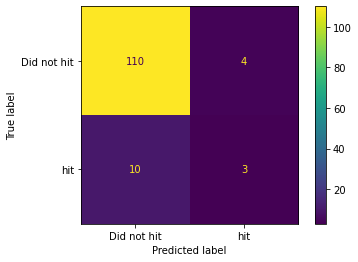

[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   1.4s
[CV] END gamma=1.0, learning_rate=0.01, max_depth=1, reg_lambda=10.0, scale_pos_weight=1; total time=   0.3s
[CV] END gamma=1.0, learning_rate=0.01, max_depth=1, reg_lambda=10.0, scale_pos_weight=1; total time=   0.3s
[CV] END gamma=1.0, learning_rate=0.01, max_depth=1, reg_lambda=10.0, scale_pos_weight=1; total time=   0.3s
[CV] END gamma=1.0, learning_rate=0.01, max_depth=2, reg_lambda=10.0, scale_pos_weight=1; total time=   0.3s
[CV] END gamma=1.0, learning_rate=0.01, max_depth=2, reg_lambda=10.0, scale_pos_weight=1; total time=   0.3s
[CV] END gamma=1.0, learning_rate=0.01, max_depth=2, reg_lambda=10.0, scale_pos_weight=1; total time=   0.3s
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   0.4s
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   0.4s
[CV] END gamma=1.0,

In [276]:
plot_confusion_matrix(clf_xgb2,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not hit","hit"])

In [270]:
X.columns

Index(['starter', 'age', 'max_pts', 'last_pts', '3_yr_trail_avg_fppg',
       'hit_rate', 'Draft Pick', 'breakout_age', 'konami', 'supporting_cast',
       'games_played_rate'],
      dtype='object')

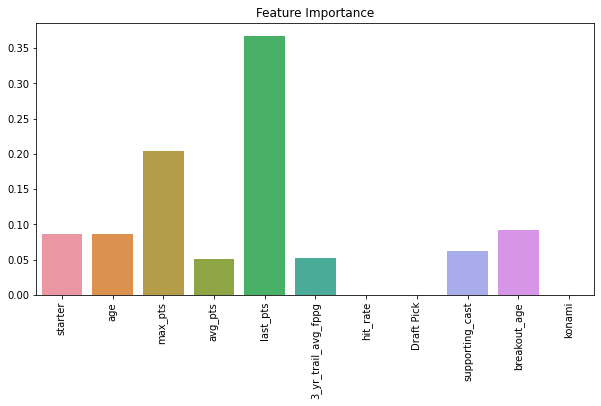

In [271]:
features = ['starter', 'age', 'max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'hit_rate', 'Draft Pick', 'supporting_cast',
       'breakout_age', 'konami']
f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=features, y=clf_xgb2.feature_importances_)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

## Score 2022

In [272]:
brady_scores_2022 = pd.DataFrame(clf_xgb2.predict_proba(df_2022)).set_index(df_2022_id['id']).sort_values(
    1, axis=0, ascending=False)
brady_scores_2022.to_csv('brady_scores_2022.csv')

In [274]:
brady_scores_2022.head(20)

,0,1
id,,
Deshaun Watson,0.213112,0.786888
Justin Herbert,0.238023,0.761977
Lamar Jackson,0.262504,0.737496
Kyler Murray,0.262504,0.737496
Josh Allen,0.262504,0.737496
Dak Prescott,0.289211,0.710789
Patrick Mahomes,0.323256,0.676744
Tom Brady,0.419587,0.580413
Ryan Tannehill,0.516768,0.483232


winner_df = j_scores_2022.reset_index().merge(adp_df[['Full Name','ADP']], left_on='id',right_on='Full Name')
winner_df.to_csv('winner_df.csv')

## Backtest

### 2021

In [117]:
X_2021 = df_2021.drop(columns=['y'])
X_2021

,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate
0,1,37.5,388.2592,307.094171,388.2592,20.288733,0.714286,1.24,1.662298,19.8,1.857143,0.919643
1,0,22.6,NaN,NaN,NaN,NaN,NaN,1.26,1.662298,19.8,NaN,NaN
2,0,25.9,NaN,NaN,NaN,NaN,NaN,NaN,1.662298,21.1,NaN,NaN
3,1,33.6,268.8000,218.014243,144.8997,15.490900,0.000000,2.03,1.754124,20.9,2.142857,0.857143
4,0,22.2,NaN,NaN,NaN,NaN,NaN,1.11,1.754124,20.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
80,1,32.9,351.3600,247.743333,351.3600,18.153333,0.166667,1.08,1.524542,22.1,2.333333,0.875000
81,1,24.4,423.0000,308.259833,341.7795,20.328433,0.666667,1.32,1.224198,18.7,6.333333,0.958333
82,0,23.3,2.9000,2.900000,2.9000,1.450000,0.000000,NaN,1.224198,21.6,0.000000,0.125000
83,0,26.2,NaN,NaN,NaN,NaN,NaN,5.34,0.989744,21.5,NaN,NaN


In [118]:
df_2021_id

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id,year
0,1,1,37.5,388.2592,307.094171,388.2592,20.288733,0.714286,1.24,1.662298,19.8,1.857143,0.919643,Aaron Rodgers,2021
1,0,0,22.6,NaN,NaN,NaN,NaN,NaN,1.26,1.662298,19.8,NaN,NaN,Jordan Love,2021
2,0,0,25.9,NaN,NaN,NaN,NaN,NaN,NaN,1.662298,21.1,NaN,NaN,Kurt Benkert,2021
3,0,1,33.6,268.8000,218.014243,144.8997,15.490900,0.000000,2.03,1.754124,20.9,2.142857,0.857143,Andy Dalton,2021
4,0,0,22.2,NaN,NaN,NaN,NaN,NaN,1.11,1.754124,20.5,NaN,NaN,Justin Fields,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0,1,32.9,351.3600,247.743333,351.3600,18.153333,0.166667,1.08,1.524542,22.1,2.333333,0.875000,Ryan Tannehill,2021
81,0,1,24.4,423.0000,308.259833,341.7795,20.328433,0.666667,1.32,1.224198,18.7,6.333333,0.958333,Lamar Jackson,2021
82,0,0,23.3,2.9000,2.900000,2.9000,1.450000,0.000000,NaN,1.224198,21.6,0.000000,0.125000,Tyler Huntley,2021
83,0,0,26.2,NaN,NaN,NaN,NaN,NaN,5.34,0.989744,21.5,NaN,NaN,Mike White,2021


In [119]:
id_2021 = qb_final_df[['Full Name','Fantasy Points Per Game (2021)']].dropna(subset=['Fantasy Points Per Game (2021)'])
id_2021

,Full Name,Fantasy Points Per Game (2021)
1,Aaron Rodgers,21.0813
5,Andy Dalton,11.6500
7,Baker Mayfield,13.8500
9,Ben Roethlisberger,14.2562
10,Blaine Gabbert,0.3300
...,...,...
167,Trey Lance,11.1533
168,Tua Tagovailoa,14.6862
170,Tyler Huntley,12.3771
171,Tyrod Taylor,14.4567


In [120]:
brady_scores_2021 = pd.DataFrame(clf_xgb2.predict_proba(X_2021)).set_index(df_2021_id['id']).sort_values(
    1, axis=0, ascending=False)
brady_scores_2021

,0,1
id,,
Lamar Jackson,0.121480,0.878520
Josh Allen,0.134733,0.865267
Patrick Mahomes,0.139754,0.860246
Kyler Murray,0.151242,0.848758
Justin Herbert,0.226411,0.773589
...,...,...
Mike White,0.994326,0.005674
Trevor Siemian,0.994326,0.005674
Kevin Hogan,0.994326,0.005674


In [121]:
brady_scores_2021_check = brady_scores_2021.reset_index()
brady_scores_2021_check

,id,0,1
0,Lamar Jackson,0.121480,0.878520
1,Josh Allen,0.134733,0.865267
2,Patrick Mahomes,0.139754,0.860246
3,Kyler Murray,0.151242,0.848758
4,Justin Herbert,0.226411,0.773589
...,...,...,...
80,Mike White,0.994326,0.005674
81,Trevor Siemian,0.994326,0.005674
82,Kevin Hogan,0.994326,0.005674
83,Josh Rosen,0.994326,0.005674


In [122]:
df_2021['id'] = df_2021_id['id']
df_2021

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id
0,1,1,37.5,388.2592,307.094171,388.2592,20.288733,0.714286,1.24,1.662298,19.8,1.857143,0.919643,Aaron Rodgers
1,0,0,22.6,NaN,NaN,NaN,NaN,NaN,1.26,1.662298,19.8,NaN,NaN,Jordan Love
2,0,0,25.9,NaN,NaN,NaN,NaN,NaN,NaN,1.662298,21.1,NaN,NaN,Kurt Benkert
3,0,1,33.6,268.8000,218.014243,144.8997,15.490900,0.000000,2.03,1.754124,20.9,2.142857,0.857143,Andy Dalton
4,0,0,22.2,NaN,NaN,NaN,NaN,NaN,1.11,1.754124,20.5,NaN,NaN,Justin Fields
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0,1,32.9,351.3600,247.743333,351.3600,18.153333,0.166667,1.08,1.524542,22.1,2.333333,0.875000,Ryan Tannehill
81,0,1,24.4,423.0000,308.259833,341.7795,20.328433,0.666667,1.32,1.224198,18.7,6.333333,0.958333,Lamar Jackson
82,0,0,23.3,2.9000,2.900000,2.9000,1.450000,0.000000,NaN,1.224198,21.6,0.000000,0.125000,Tyler Huntley
83,0,0,26.2,NaN,NaN,NaN,NaN,NaN,5.34,0.989744,21.5,NaN,NaN,Mike White


In [123]:
brady_scores_2021_check2 = brady_scores_2021_check.merge(df_2021, on='id',how='inner')
brady_scores_2021_check2.to_csv('brady_scores_2021_check.csv')

### 2020

In [124]:
X_2020 = df_2020.drop(columns=['y'])
X_2020

,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate
0,0,29.7,57.4,19.500000,17.8,3.433333,0.000000,5.24,1.037354,21.0,0.250000,0.203125
1,1,24.7,340.8,281.233333,330.0,22.666667,0.666667,1.12,1.037354,20.0,4.666667,0.791667
2,1,36.5,382.4,293.566667,276.8,18.666667,0.666667,1.24,1.473486,19.8,1.666667,0.906250
3,0,25.7,0.0,0.000000,0.0,0.000000,0.000000,NaN,1.473486,NaN,0.000000,0.187500
4,0,36.1,300.0,234.220000,NaN,17.150000,0.000000,1.01,0.865133,19.3,2.000000,0.887500
...,...,...,...,...,...,...,...,...,...,...,...,...
77,0,28.4,-2.0,-2.000000,NaN,-2.000000,0.000000,NaN,1.447192,18.7,0.000000,0.062500
78,0,25.3,NaN,NaN,NaN,NaN,NaN,NaN,1.616799,18.5,NaN,NaN
79,1,27.6,208.0,99.000000,92.7,3.700000,0.000000,1.32,1.616799,18.8,0.800000,0.537500
80,1,37.5,300.8,191.133333,252.0,17.200000,0.166667,7.36,0.364208,20.8,1.666667,0.739583


In [125]:
df_2020_id

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id,year
0,0,0,29.7,57.4,19.500000,17.8,3.433333,0.000000,5.24,1.037354,21.0,0.250000,0.203125,A.J. McCarron,2020
1,1,1,24.7,340.8,281.233333,330.0,22.666667,0.666667,1.12,1.037354,20.0,4.666667,0.791667,Deshaun Watson,2020
2,1,1,36.5,382.4,293.566667,276.8,18.666667,0.666667,1.24,1.473486,19.8,1.666667,0.906250,Aaron Rodgers,2020
3,0,0,25.7,0.0,0.000000,0.0,0.000000,0.000000,NaN,1.473486,NaN,0.000000,0.187500,Tim Boyle,2020
4,0,0,36.1,300.0,234.220000,NaN,17.150000,0.000000,1.01,0.865133,19.3,2.000000,0.887500,Alex Smith,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0,0,28.4,-2.0,-2.000000,NaN,-2.000000,0.000000,NaN,1.447192,18.7,0.000000,0.062500,Tyler Bray,2020
78,0,0,25.3,NaN,NaN,NaN,NaN,NaN,NaN,1.616799,18.5,NaN,NaN,P.J. Walker,2020
79,0,1,27.6,208.0,99.000000,92.7,3.700000,0.000000,1.32,1.616799,18.8,0.800000,0.537500,Teddy Bridgewater,2020
80,0,1,37.5,300.8,191.133333,252.0,17.200000,0.166667,7.36,0.364208,20.8,1.666667,0.739583,Ryan Fitzpatrick,2020


In [126]:
brady_scores_2020 = pd.DataFrame(clf_xgb2.predict_proba(X_2020)).set_index(df_2020_id['id']).sort_values(
    1, axis=0, ascending=False)
brady_scores_2020

,0,1
id,,
Deshaun Watson,0.118928,0.881072
Aaron Rodgers,0.175499,0.824501
Lamar Jackson,0.193739,0.806261
Tom Brady,0.231233,0.768767
Patrick Mahomes,0.324724,0.675276
...,...,...
Geno Smith,0.994326,0.005674
P.J. Walker,0.994326,0.005674
Chris Streveler,0.994326,0.005674


In [127]:
brady_scores_2020_check = brady_scores_2020.reset_index()
brady_scores_2020_check

,id,0,1
0,Deshaun Watson,0.118928,0.881072
1,Aaron Rodgers,0.175499,0.824501
2,Lamar Jackson,0.193739,0.806261
3,Tom Brady,0.231233,0.768767
4,Patrick Mahomes,0.324724,0.675276
...,...,...,...
77,Geno Smith,0.994326,0.005674
78,P.J. Walker,0.994326,0.005674
79,Chris Streveler,0.994326,0.005674
80,Easton Stick,0.994326,0.005674


In [128]:
df_2020['id'] = df_2020_id['id']
df_2020

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id
0,0,0,29.7,57.4,19.500000,17.8,3.433333,0.000000,5.24,1.037354,21.0,0.250000,0.203125,A.J. McCarron
1,1,1,24.7,340.8,281.233333,330.0,22.666667,0.666667,1.12,1.037354,20.0,4.666667,0.791667,Deshaun Watson
2,1,1,36.5,382.4,293.566667,276.8,18.666667,0.666667,1.24,1.473486,19.8,1.666667,0.906250,Aaron Rodgers
3,0,0,25.7,0.0,0.000000,0.0,0.000000,0.000000,NaN,1.473486,NaN,0.000000,0.187500,Tim Boyle
4,0,0,36.1,300.0,234.220000,NaN,17.150000,0.000000,1.01,0.865133,19.3,2.000000,0.887500,Alex Smith
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0,0,28.4,-2.0,-2.000000,NaN,-2.000000,0.000000,NaN,1.447192,18.7,0.000000,0.062500,Tyler Bray
78,0,0,25.3,NaN,NaN,NaN,NaN,NaN,NaN,1.616799,18.5,NaN,NaN,P.J. Walker
79,0,1,27.6,208.0,99.000000,92.7,3.700000,0.000000,1.32,1.616799,18.8,0.800000,0.537500,Teddy Bridgewater
80,0,1,37.5,300.8,191.133333,252.0,17.200000,0.166667,7.36,0.364208,20.8,1.666667,0.739583,Ryan Fitzpatrick


In [129]:
brady_scores_2020_check2 = brady_scores_2020_check.merge(df_2020, on='id',how='inner')
brady_scores_2020_check2.to_csv('brady_scores_2020_check.csv')

[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   0.3s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=20.0, scale_pos_weight=1; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=30.0, scale_pos_weight=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=20.0, scale_pos_weight=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   0.3s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=30.0, scale_pos_weight=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=20.0, scale_pos_weight=1; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   0.3s
[CV] END gamma=0, learning_rate=0.0